<a href="https://colab.research.google.com/github/MavielS/Projets_DS/blob/master/P4/Preprocessing_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Avant toute chose, il est nécessaire d'importer les datasets (train_80_20.csv & test_80_20.csv) ainsi qu'un fichier tiers (exploration.py)** <br>
Cela peut prendre un peu de temps en fonction de votre débit internet. <br>

Les datasets sont à télécharger à [cette adresse](https://github.com/MavielS/Projets_DS/tree/master/P4).

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('Vous avez importé le fichier "{name}" qui a une taille de {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Il faut aussi installer certaines dépendances

In [ ]:
!pip install squarify

# Sommaire

* [Preprocessing](#Preprocessing)
    * [Traitement des colonnes](#Traitement-des-colonnes)
    * [Traitement des NaNs](#Traitement-des-NaNs)
    * [Traitement des outliers](#Traitement-des-outliers)
    * [Feature Scaling](#Feature-Scaling)
    * [Feature Engineering](#Feature-Engineering)
    * [Application](#Application)
* [Modélisation](#Modélisation)
    * [Choix du modèle](#Choix-du-modèle)
    * [Intérêt de l'EnergyStarScore](#Intérêt-de-l'EnergyStarScore)
* [Tests](#Tests)
    * [Résultats sans EnergyStarScore](#Résultats-sans-EnergyStarScore)
    * [Résultats avec EnergyStarScore](#Résultats-avec-EnergyStarScore)
* [Amélioration envisageable](#Amélioration-envisageable)


In [1]:
import pandas as pd
import exploration as ex
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
import pickle
import time

pd.options.display.max_columns = 50

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

In [2]:
train = pd.read_csv('train_80_20.csv')
test = pd.read_csv('test_80_20.csv')

tmp_train = train.copy()

+----+----------+-------------+---------------+------------+----------------+
|    |   Taille |   Nb lignes |   Nb colonnes |   % de NaN |   Nb duplicats |
|----+----------+-------------+---------------+------------+----------------|
|  0 |   226665 |        5037 |            45 |      11.03 |              0 |
+----+----------+-------------+---------------+------------+----------------+


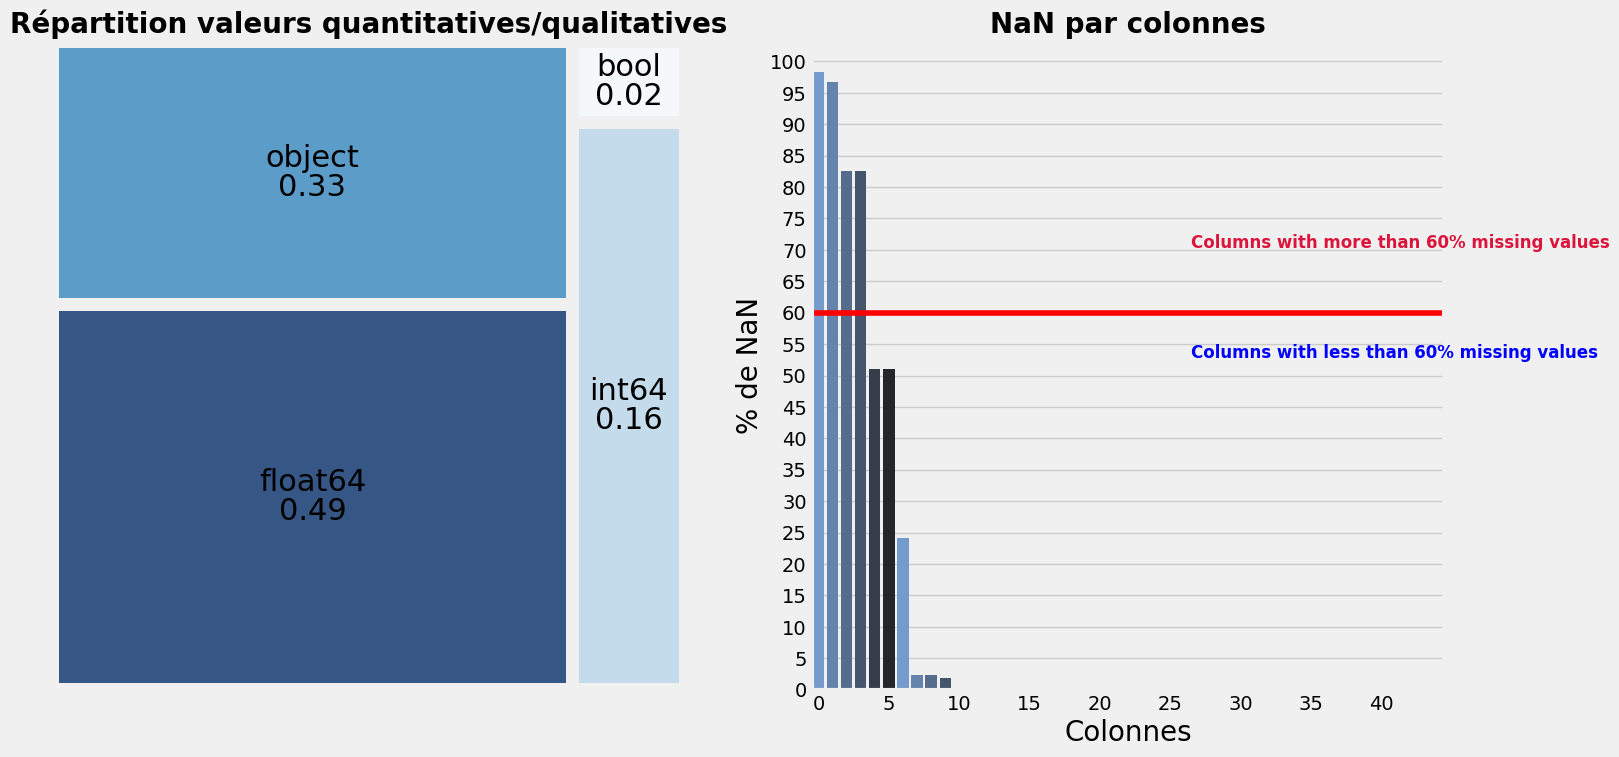

In [ ]:
ex.analyse_forme(train, all=True)

# Preprocessing

## Traitement des colonnes

Ici, je sélectionne les colonnes pertinentes avec mon étude, je supprime les batiments résidentiels, je corrige le nom de certaines variables quantitatives et je regroupe le contenu de certaines colonnes dans des categories prédéfinies.

In [3]:
to_keep = [   # 'OSEBuildingID', # Inutile
            # 'DataYear', # Inutile
              'BuildingType',
              'PrimaryPropertyType',
              'PropertyName',
            # 'TaxParcelIdentificationNumber', # Inutile
            # 'CouncilDistrictCode',
            # 'Neighborhood',
              'YearBuilt',
            # 'YearsENERGYSTARCertified', # Inutile
              'NumberofBuildings',
              'NumberofFloors',
              'PropertyGFATotal',
              'PropertyGFAParking',
              'PropertyGFABuilding(s)',
            # 'ListOfAllPropertyUseTypes', # Redondant avec Largest/SecondLargest/ThirdLargest
              'LargestPropertyUseType',
              'LargestPropertyUseTypeGFA',
              'SecondLargestPropertyUseType', # NaNs à traiter
            # 'SecondLargestPropertyUseTypeGFA',
              'ThirdLargestPropertyUseType', # NaNs à traiter
            # 'ThirdLargestPropertyUseTypeGFA',
              'ENERGYSTARScore',
              #'SiteEUI(kBtu/sf)',
              'SiteEUIWN(kBtu/sf)', # Pour FE 
              #'SourceEUI(kBtu/sf)',
              'SourceEUIWN(kBtu/sf)', # Pour FE 
              'SiteEnergyUse(kBtu)',
              'SiteEnergyUseWN(kBtu)', # Pour feature engineering 
              'SteamUse(kBtu)',
            # 'Electricity(kWh)', # Redondant 
              'Electricity(kBtu)', 
            # 'NaturalGas(therms)', # Redondant 
              'NaturalGas(kBtu)', 
              'TotalGHGEmissions',
              'GHGEmissionsIntensity',
              'DefaultData',
              'ComplianceStatus',
              'Outlier',
            # 'Latitude',
            # 'Longitude',
            # 'Address',
            # 'City',
            # 'State',
            # 'ZipCode'
              ]

def change_prim(prop):
    if prop == 'Distribution Center\n':
        return 'Distribution Center'
    elif prop == 'Supermarket / Grocery Store' or prop == 'Supermarket/Grocery Store':
        return 'Supermarket'
    elif prop == 'Self-Storage Facility\n':
        return 'Self-Storage Facility'
    elif prop == 'College/University':
        return 'University'
    elif prop == 'Restaurant\n':
        return 'Restaurant'
    elif prop == 'Office':
        return 'Small- and Mid-Sized Office'
    else:
        return prop


def change_outlier(value):
    if value == 'Low Outlier':
        return 'Low outlier'
    elif value == 'High Outlier':
        return 'High outlier'
    else:
        return value

def clean_categories(data):
    '''Regroupe le contenu des colonnes ci-dessous dans des categories prédéfinies '''
    property_use_types_columns = ['LargestPropertyUseType','PrimaryPropertyType',
                                  'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
    
    usetype_dict = {
                'Retail Store' : 'Retail',
                'Supermarket/Grocery Store' : 'Retail',
                'Repair Services (Vehicle, Shoe, Locksmith, etc)' : 'Retail',
                'Automobile Dealership': 'Retail',
                'Convenience Store without Gas Station': 'Retail',
                'Personal Services': 'Retail',
                'Enclosed Mall': 'Retail',
                'Strip Mall': 'Retail',
                'Wholesale Club/Supercenter': 'Retail',
                'Other - Mall': 'Retail',
                'Supermarket / Grocery Stor': 'Retail',
                'Retail (Health/Beauty, Dry Cleaning, etc)' : 'Retail',
                'Retaile' : 'Retail',
                
                'Food Sales': 'Leisure',
                'Restaurant' : 'Leisure',
                'Other - Restaurant/Bar' : 'Leisure',
                'Food Service': 'Leisure' ,
                'Worship Facility': 'Leisure',
                'Other - Recreation': 'Leisure',
                'Other - Entertainment/Public Assembly': 'Leisure',
                'Performing Arts': 'Leisure',
                'Bar/Nightclub': 'Leisure',
                'Movie Theater': 'Leisure',
                'Museum': 'Leisure',
                'Social/Meeting Hall': 'Leisure',
                'Fitness Center/Health Club/Gym': 'Leisure',
                'Lifestyle Center ': 'Leisure',
                'Fast Food Restaurant': 'Leisure',
                'Other - Leisure/Bar' : 'Leisure',
                'Lifestyle Center' : 'Leisure',
                'Fast Food Leisure' : 'Leisure',
        
                
                'Hotel' : 'Residence/Hotel/Senior Care/Housing',
                'Mid-Rise Multifamily' : 'Residence/Hotel/Senior Care/Housing',
                'Low-Rise Multifamily' : 'Residence/Hotel/Senior Care/Housing',
                'Mixed Use Property' : 'Residence/Hotel/Senior Care/Housing',
                'Multifamily Housing' : 'Residence/Hotel/Senior Care/Housing',
                'Other - Lodging/Residential': 'Residence/Hotel/Senior Care/Housing',
                'Residence Hall/Dormitory': 'Residence/Hotel/Senior Care/Housing',
                'Senior Care Community' :'Residence/Hotel/Senior Care/Housing',
                'Residential Care Facility' : 'Residence/Hotel/Senior Care/Housing',
                'High-Rise Multifamily': 'Residence/Hotel/Senior Care/Housing',
                'Prison/Incarceration': 'Residence/Hotel/Senior Care/Housing',
                'Residence Hall': 'Residence/Hotel/Senior Care/Housing',
                
                'Medical Office' : 'Health',
                'Urgent Care/Clinic/Other Outpatient' : 'Health',
                'Laboratory' : 'Health',
                'Hospital (General Medical & Surgical)' : 'Health',
                'Health (General Medical & Surgical)' : 'Health',
                'Other/Specialty Hospital' : 'Health',
                'Outpatient Rehabilitation/Physical Therapy' : 'Health',
                'Hospital' : 'Health',
                'Personal Services (Health/Beauty, Dry Cleaning, etc)' : 'Health',
        
                'Small- and Mid-Sized Office' : 'Offices',
                'Other - Services' : 'Offices',
                'Bank Branch' : 'Offices',
                'Financial Office' : 'Offices',
                'Other - Public Services': 'Offices',
                'Police Station' : 'Offices',
                'Courthouse' : 'Offices',
                'Large Office' : 'Offices',
                'Convention Center': 'Offices',
                'Offices' : 'Office',

                'K-12 School' : 'Education',
                'SPS-District K-12' : 'Education',
                'Other - Education': 'Education',
                'Vocational School' : 'Education', 
                'Adult Education' : 'Education',
                'Pre-school/Daycare': 'Education',
                'University': 'Education',
                'College/University': 'Education',
                'Library': 'Education',
                'College/Education' : 'Education',
        
                 'Self-Storage Facility' : 'Storage',
                 'Non-Refrigerated Warehouse' : 'Storage',
                 'Distribution Center' : 'Storage',
        
                'Data Center' : 'Facility',
                'Manufacturing/Industrial Plant' : 'Facility',
                'Refrigerated Warehouse' : 'Facility',
                
                'Fire Station' : 'Other',
                'Other - Utility' : 'Other',
                'Swimming Pool' : 'Other',
                'No Use' : 'Other',
                'Repair Services (Vehicle, Shoe, Locksmith, etc)' : 'Other',
                'Other - Technology/Science' : 'Other',
        
                'No information' : 'Other',
               }
    
    
    for column in property_use_types_columns:
        data[column] = data[column].astype('object')
        data[column] = data[column].replace(usetype_dict, regex=False)
        # data[column] = data[column].astype('category')

    return data

def proc_name_var(data):
    tmp = data[to_keep]
    
    tmp = tmp[~tmp.BuildingType.str.contains('Multifamily')]  #Suppression des batiments résidentiels
    tmp.PrimaryPropertyType = tmp.PrimaryPropertyType.apply(change_prim) # Correction des noms
    tmp.Outlier = tmp.Outlier.apply(change_outlier)
    tmp.NumberofFloors = tmp.NumberofFloors.apply(lambda x: 1 if x==0 else x)
    tmp = clean_categories(tmp)
    
    return tmp

In [ ]:
proc_name_var(tmp_train).dtypes.value_counts()

float64    13
object      8
int64       4
bool        1
dtype: int64

In [ ]:
proc_name_var(tmp_train)

BuildingType                  PrimaryPropertyType  \
0        NonResidential                            Warehouse   
1        NonResidential                              Storage   
2     SPS-District K-12                            Education   
3        NonResidential  Residence/Hotel/Senior Care/Housing   
8        NonResidential                              Storage   
...                 ...                                  ...   
5028     NonResidential                               Office   
5030     NonResidential                                Other   
5031     NonResidential                              Storage   
5032     NonResidential                               Office   
5034     NonResidential                               Retail   

                                         PropertyName  YearBuilt  \
0                           3401 Colorado Ave S. Whse       1964   
1                                        GTE SYLVANIA       1963   
2                                Viewlands Elementary       1954   
3                                   Scargo Apartments       1910   
8                                      PUBLIC STORAGE       1982   
...                                               ...        ...   
5028                                400 Mercer Street       1987   
5030                                          Laidlaw       1963   
5031                                   VISKO BUILDING       1953   
5032  WATERFRONT PLACE BUILDING MIXED USE CONDOMINIUM       1983   
5034                           PATAGONIA RETAIL STORE       1920   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                   1.0             1.0             33462                   0   
1                   1.0             1.0            106000                   0   
2                   1.0             1.0             42128                   0   
3                   1.0             3.0             29340                   0   
8                   1.0             2.0             36600                   0   
...                 ...             ...               ...                 ...   
5028                1.0             6.0             78672               28427   
5030                1.0             1.0             23260                   0   
5031                1.0             1.0             31521                   0   
5032                1.0            13.0            307557               83064   
5034                1.0             2.0             26400                   0   

      PropertyGFABuilding(s) LargestPropertyUseType  \
0                      33462                Storage   
1                     106000                Storage   
2                      42128              Education   
3                      29340                 Office   
8                      36600                Storage   
...                      ...                    ...   
5028                   50245                 Office   
5030                   23260                  Other   
5031                   31521                Storage   
5032                  224493                 Office   
5034                   26400                 Retail   

      LargestPropertyUseTypeGFA         SecondLargestPropertyUseType  \
0                       33462.0                                  NaN   
1                      106001.0                                  NaN   
2                       42128.0                                  NaN   
3                       12714.0  Residence/Hotel/Senior Care/Housing   
8                       43556.0                                  NaN   
...                         ...                                  ...   
5028                    78672.0                                  NaN   
5030                    13075.0                               Office   
5031                    31521.0                                  NaN   
5032                   162869.0                              Parking   

## Traitement des NaNs

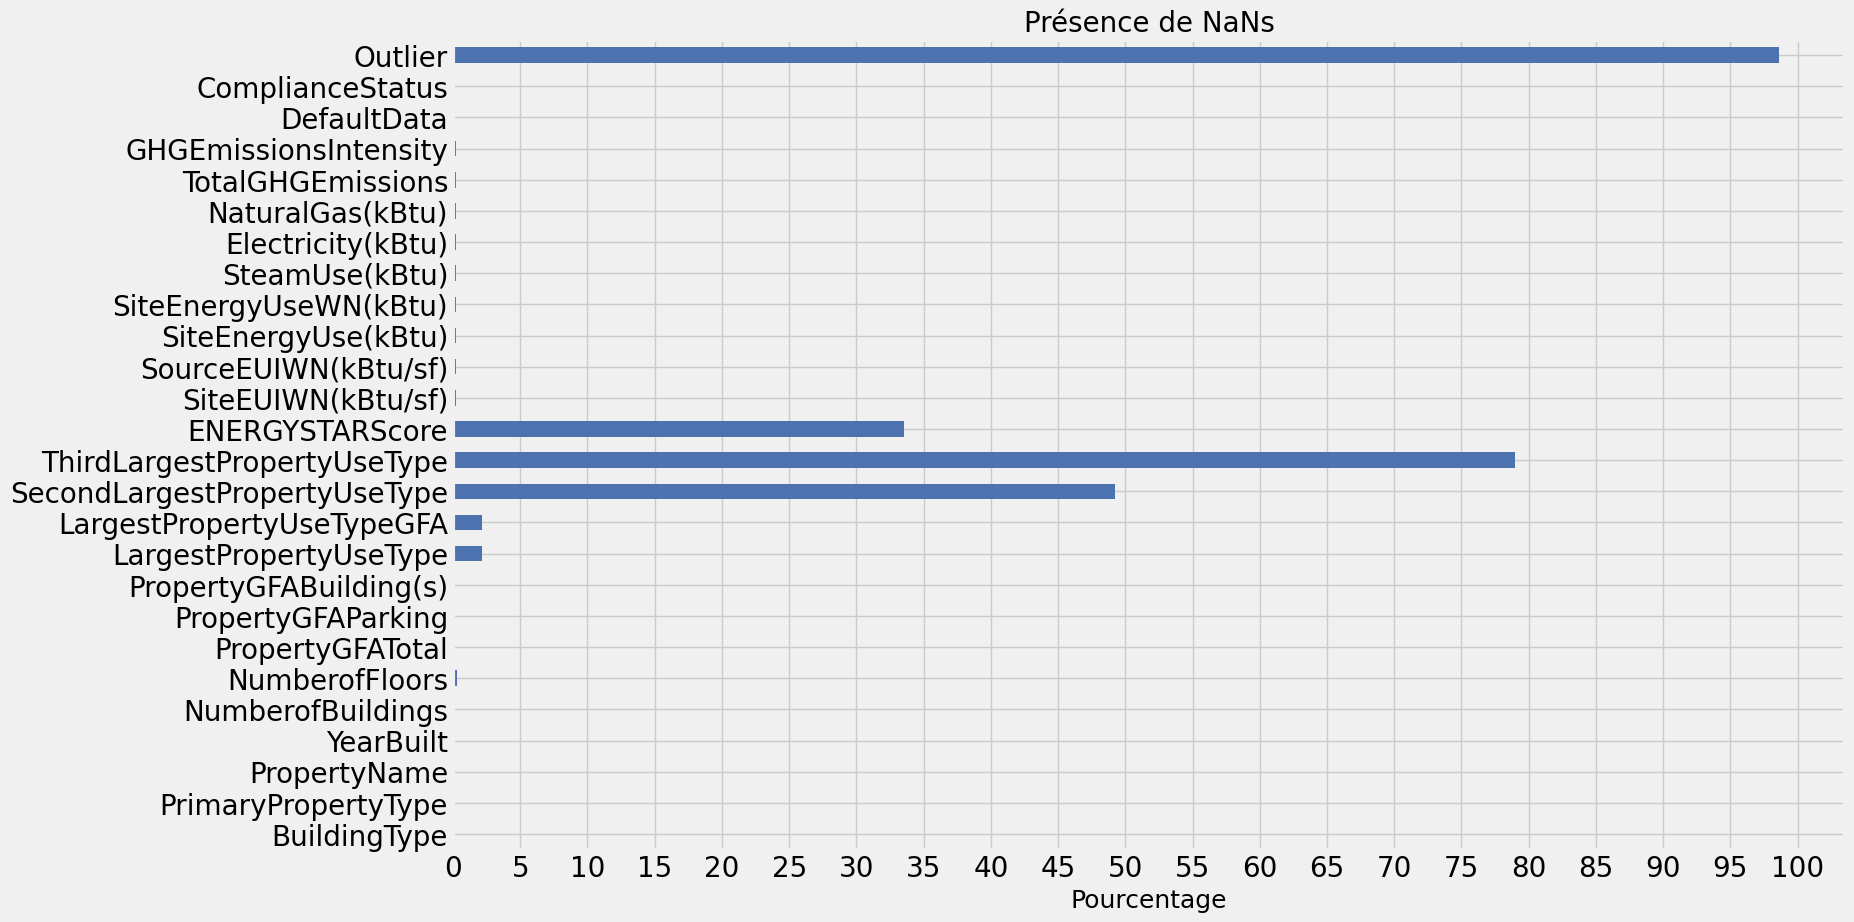

In [ ]:
tmp = proc_name_var(tmp_train)

plt.figure(figsize=(16,10))
ax = plt.subplot(1,1,1)
((tmp.isna().sum()/tmp.shape[0])*100).plot(kind='barh' , fontsize=20, xticks=np.arange(0,101,5), color=sns.color_palette('deep')[0])
ax.set_title('Présence de NaNs', fontsize=20)
ax.set_ylabel('')
ax.set_xlabel('Pourcentage', fontsize = 18)
plt.show()

Ici, je supprime les lignes ayant Default Data à True -> Cela m'indique que ces valeurs ne sont pas des valeurs mesurées mais des valeurs prises par défaut. <br>
Je supprime les lignes non 'Compliant'<br>
Je remplis les non-outliers par 'Not-Outlier'. <br>
Je supprime le reste des lignes comportant toujours des NaNs.

Outlier nous permettra d'avoir une méthode supplémentaire pour traiter les outliers, on le supprimera après l'avoir exploité. <br>
Je ferai un entrainement avec et sans l'EnergyStarScore <br>
Je remplis les lignes Third/SecondLargestPropertyUseType par la valeur "Other" lorsqu'un NaN est présent <br>
Pour le reste, je supprime l'ensemble de mes NaNs. <br>


In [4]:
def proc_nan(data):
    tmp = data.copy()
    
    # Remplissage colonne outlier
    tmp.Outlier = tmp.Outlier.fillna('Not Outlier')
    
    # Remplissage des "ThirdLargest / SecondLargest"
    tmp.SecondLargestPropertyUseType = tmp.SecondLargestPropertyUseType.fillna('Other')
    tmp.ThirdLargestPropertyUseType = tmp.ThirdLargestPropertyUseType.fillna('Other')
    
    # Suppression des données par défaut
    default = tmp[tmp.DefaultData == True]
    tmp = tmp.drop(default.index)
    
    # Suppression des données 'non-conforme'
    non_compliant = tmp[tmp.ComplianceStatus != 'Compliant']
    tmp = tmp.drop(non_compliant.index)
    
    # Suppression des NaNs restants
    tmp = tmp.dropna(subset=data.columns[~((data.columns == 'Outlier') | (data.columns == 'ENERGYSTARScore'))])
    
    # Suppression des colonnes DefaultData et ComplianceStatus
    try:
        tmp = tmp.drop(labels=['DefaultData', 'ComplianceStatus'], axis='columns')
    except KeyError as e:
        print(e)
    
    print(f'Suppression de {data.shape[0] - tmp.shape[0]} lignes.')
    return tmp

In [ ]:
tmp = proc_name_var(tmp_train)
proc_nan(tmp)

Suppression de 287 lignes.


BuildingType                  PrimaryPropertyType  \
0        NonResidential                            Warehouse   
1        NonResidential                              Storage   
2     SPS-District K-12                            Education   
3        NonResidential  Residence/Hotel/Senior Care/Housing   
8        NonResidential                              Storage   
...                 ...                                  ...   
5026     NonResidential                               Health   
5028     NonResidential                               Office   
5030     NonResidential                                Other   
5031     NonResidential                              Storage   
5032     NonResidential                               Office   

                                         PropertyName  YearBuilt  \
0                           3401 Colorado Ave S. Whse       1964   
1                                        GTE SYLVANIA       1963   
2                                Viewlands Elementary       1954   
3                                   Scargo Apartments       1910   
8                                      PUBLIC STORAGE       1982   
...                                               ...        ...   
5026                                      James Tower       1910   
5028                                400 Mercer Street       1987   
5030                                          Laidlaw       1963   
5031                                   VISKO BUILDING       1953   
5032  WATERFRONT PLACE BUILDING MIXED USE CONDOMINIUM       1983   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                   1.0             1.0             33462                   0   
1                   1.0             1.0            106000                   0   
2                   1.0             1.0             42128                   0   
3                   1.0             3.0             29340                   0   
8                   1.0             2.0             36600                   0   
...                 ...             ...               ...                 ...   
5026                1.0             6.0            320946                   0   
5028                1.0             6.0             78672               28427   
5030                1.0             1.0             23260                   0   
5031                1.0             1.0             31521                   0   
5032                1.0            13.0            307557               83064   

      PropertyGFABuilding(s) LargestPropertyUseType  \
0                      33462                Storage   
1                     106000                Storage   
2                      42128              Education   
3                      29340                 Office   
8                      36600                Storage   
...                      ...                    ...   
5026                  320946                 Health   
5028                   50245                 Office   
5030                   23260                  Other   
5031                   31521                Storage   
5032                  224493                 Office   

      LargestPropertyUseTypeGFA         SecondLargestPropertyUseType  \
0                       33462.0                                Other   
1                      106001.0                                Other   
2                       42128.0                                Other   
3                       12714.0  Residence/Hotel/Senior Care/Housing   
8                       43556.0                                Other   
...                         ...                                  ...   
5026                   236359.0                               Health   
5028                    78672.0                                Other   
5030                    13075.0                               Office   
5031                    31521.0                                Other   

## Traitement des outliers

In [ ]:
tmp = proc_name_var(tmp_train)
tmp = proc_nan(tmp)

Suppression de 287 lignes.


### Utilisation de la colonne 'Outlier'

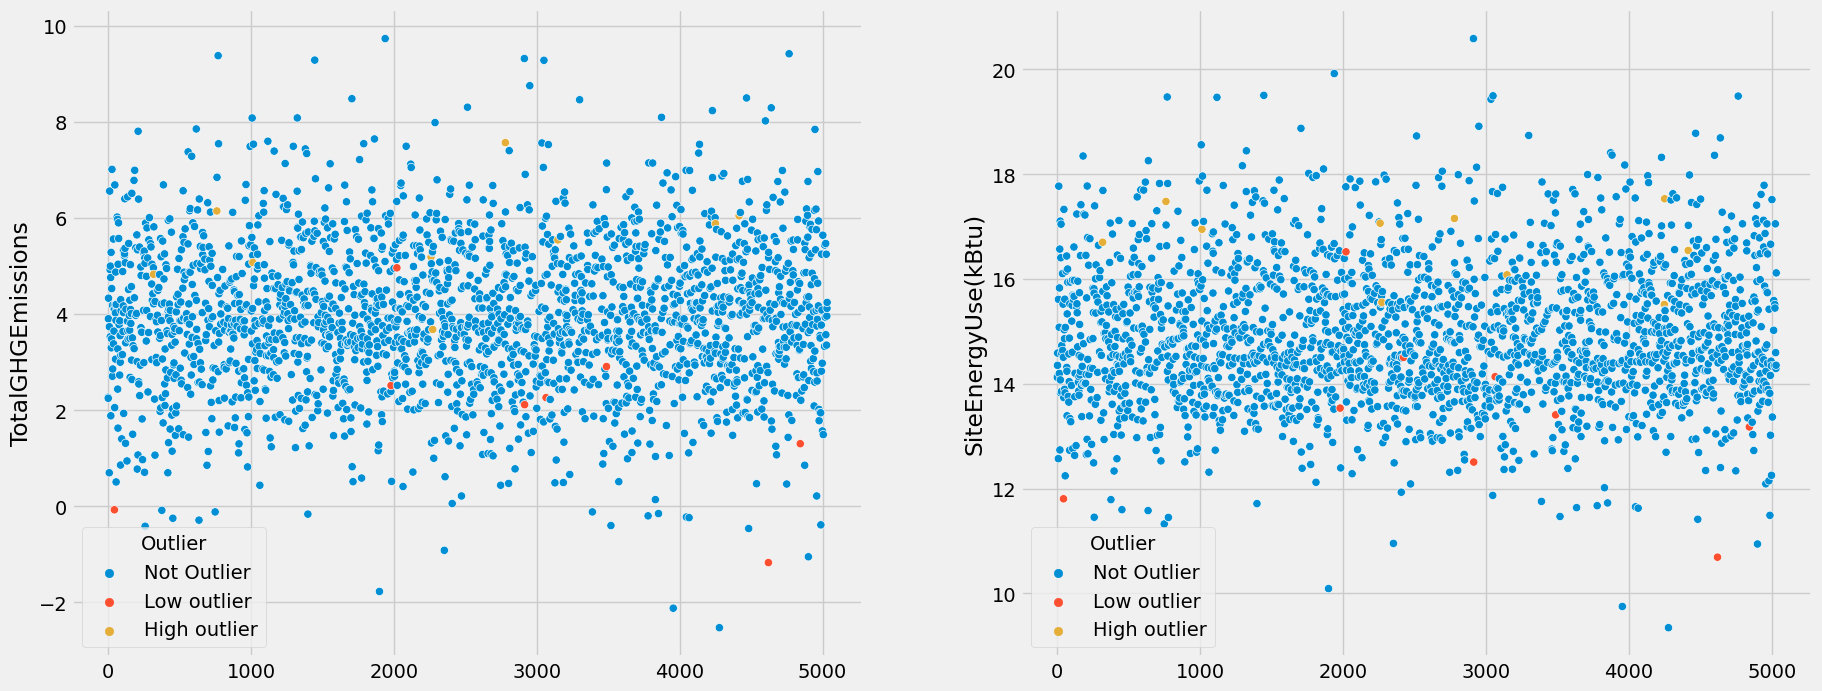

In [ ]:
fig , axs = plt.subplots(1,2,figsize=(20,8))

sns.scatterplot(y=np.log(tmp[tmp['TotalGHGEmissions']>0]['TotalGHGEmissions']), x=np.log(tmp[tmp['TotalGHGEmissions']>0]['TotalGHGEmissions']).index,
           hue=tmp[tmp['TotalGHGEmissions']>0].Outlier, ax=axs[0])

sns.scatterplot(y=np.log(tmp[tmp['SiteEnergyUse(kBtu)']>0]['SiteEnergyUse(kBtu)']), x=np.log(tmp[tmp['SiteEnergyUse(kBtu)']>0]['SiteEnergyUse(kBtu)']).index,
           hue=tmp[tmp['SiteEnergyUse(kBtu)']>0].Outlier, ax=axs[1])

plt.show()

On remarque que le colonne indique certaines valeurs extremes de nos targets, mais pas l'ensemble de ces dernières. <br>
La question que l'on peut légitimement se poser est **comment cette catégorisation d'outliers a-t-elle été faite ?** <br> 
En effet, la définition du mot 'outlier' est vaste: <br> 
S'agit-il d'outliers car ils sont non-représentatifs d'une population ? Car ce sont des anomalies ? Car ce sont des valeurs aberrantes ? <br>
Sans connaitre cette info il est difficile de savoir comment gérer ces derniers. <br>

### Valeurs négatives et nulles

In [ ]:
index_list = []

for col in tmp.select_dtypes(exclude=['object', 'bool', 'category']).columns:
    index_list.extend(tmp[tmp[col] < 0].index)

index_list.extend(tmp[((tmp.TotalGHGEmissions == 0))].index)
index_list.extend(tmp[((tmp['SiteEnergyUse(kBtu)'] == 0))].index)

tmp.loc[index_list]

BuildingType PrimaryPropertyType                    PropertyName  \
2886  NonResidential              Office                   625 5TH AVE S   
1064  NonResidential              Office   QUEEN ANNE SQUARE WEST (2013)   
3692  NonResidential               Other  FREEWAY MOTORS UNIVERSITY AUDI   
2102  NonResidential              Office                  Bullitt Center   
2102  NonResidential              Office                  Bullitt Center   
2102  NonResidential              Office                  Bullitt Center   
2102  NonResidential              Office                  Bullitt Center   
2452  NonResidential              Office                   SEATTLE TOWER   
3027  NonResidential         Supermarket       IUC- Whole Foods Interbay   
3854  NonResidential              Retail           CENTURY SQUARE RETAIL   
2452  NonResidential              Office                   SEATTLE TOWER   
3854  NonResidential              Retail           CENTURY SQUARE RETAIL   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
2886       2000                1.0            11.0             68452   
1064       1982                1.0             5.0             54015   
3692       2014                1.0             3.0             33648   
2102       2013                1.0             6.0             52000   
2102       2013                1.0             6.0             52000   
2102       2013                1.0             6.0             52000   
2102       2013                1.0             6.0             52000   
2452       1929                1.0            27.0            216571   
3027       2008                1.0             1.0             57176   
3854       1920                1.0             2.0             57428   
2452       1929                1.0            27.0            216571   
3854       1920                1.0             2.0             57428   

      PropertyGFAParking  PropertyGFABuilding(s) LargestPropertyUseType  \
2886                  -2                   68454                 Office   
1064               97325                  -43310                 Office   
3692               84198                  -50550                Parking   
2102                   0                   52000                 Office   
2102                   0                   52000                 Office   
2102                   0                   52000                 Office   
2102                   0                   52000                 Office   
2452               13320                  203251                 Office   
3027                   0                   57176                 Retail   
3854                   0                   57428                 Retail   
2452               13320                  203251                 Office   
3854                   0                   57428                 Retail   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
2886                    61665.0                      Offices   
1064                    54015.0                        Other   
3692                    83600.0                       Retail   
2102                    48159.0                        Other   
2102                    48159.0                        Other   
2102                    48159.0                        Other   
2102                    48159.0                        Other   
2452                   182604.0                      Parking   
3027                    39500.0                       Retail   
3854                    34617.0                      Storage   
2452                   182604.0                      Parking   
3854                    34617.0                      Storage   

     ThirdLargestPropertyUseType  ENERGYSTARScore  SiteEUIWN(kBtu/sf)  \
2886                       Other             81.0           58.300000   
1064                       Other             65.0           64.000000   
3692                       Other              NaN     

Je remarque que j'ai certaines lignes ou l'ensemble des valeurs énergétiques sont des 0 ! <br>
Je remarque aussi que certaines colonnes ont des valeurs négatives, ce sont surement des valeurs aberrantes, je les supprime.

### Méthode IQR

In [ ]:
tmp.select_dtypes(exclude=['object','bool']).columns

Index(['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

L'utilisation de la méthode de l'IQR ne fait sens qu'en présence d'une distribution normale. <br>
Je veux donc vérifier quelles variables ont une telle distribution. <br>
<br>
**Test de Shapiro-Wilk**
Hypothèse H0: Ma variable suit une loi normale. <br>

In [ ]:
from scipy.stats import shapiro

for col in tmp.select_dtypes(exclude=['object','bool', 'category']).columns:
    # normality test
    stat, p = shapiro(tmp[col])
    print(f'{col}')
    print(f'Statistics={stat:.3f}, p={p:.3f}')
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    print()

YearBuilt
Statistics=0.947, p=0.000
Sample does not look Gaussian (reject H0)

NumberofBuildings
Statistics=0.036, p=0.000
Sample does not look Gaussian (reject H0)

NumberofFloors
Statistics=0.432, p=0.000
Sample does not look Gaussian (reject H0)

PropertyGFATotal
Statistics=0.286, p=0.000
Sample does not look Gaussian (reject H0)

PropertyGFAParking
Statistics=0.350, p=0.000
Sample does not look Gaussian (reject H0)

PropertyGFABuilding(s)
Statistics=0.246, p=0.000
Sample does not look Gaussian (reject H0)

LargestPropertyUseTypeGFA
Statistics=0.236, p=0.000
Sample does not look Gaussian (reject H0)

ENERGYSTARScore
Statistics=nan, p=1.000
Sample looks Gaussian (fail to reject H0)

SiteEUIWN(kBtu/sf)
Statistics=0.683, p=0.000
Sample does not look Gaussian (reject H0)

SourceEUIWN(kBtu/sf)
Statistics=0.652, p=0.000
Sample does not look Gaussian (reject H0)

SiteEnergyUse(kBtu)
Statistics=0.214, p=0.000
Sample does not look Gaussian (reject H0)

SiteEnergyUseWN(kBtu)
Statistics=0.293,

Pour mes données je ne peux pas utiliser la méthode IQR.

### Méthode Z-Score modifié

Mes distributions quantitatives n'étant pas des gaussiennes, je ne peux appliquer mon Z-score "classique". <br> 
Je peux cependant appliquer mon Z-Score "modifié" (utilisant la médiane)

A l'aide de mon z-score j'observe les batiments pour lesquelles les valeurs sont "anormales", je les supprime. <br>

In [ ]:
# Suppression valeurs négatives + valeurs nulles pour targets
index_list = []

for col in tmp.select_dtypes(exclude=['object', 'bool', 'category']).columns:
    index_list.extend(tmp[tmp[col] < 0].index)

index_list.extend(tmp[((tmp.TotalGHGEmissions == 0))].index)
index_list.extend(tmp[((tmp['SiteEnergyUse(kBtu)'] == 0))].index)

tmp = tmp.drop(index=index_list)

# Suppression des LargestPropertyUseTypeGFA > PropertyGFATotal
shape_tmp = tmp.shape[0]
tmp = tmp.drop(index=tmp[tmp.LargestPropertyUseTypeGFA > tmp.PropertyGFATotal].index)

# Suppression des lignes "multi-batiments"
shape_tmp = tmp.shape[0]
tmp = tmp.drop(index=tmp[tmp.NumberofBuildings > 1].index)

y_gh = np.log(tmp.TotalGHGEmissions)
y_en = np.log(tmp['SiteEnergyUse(kBtu)'])

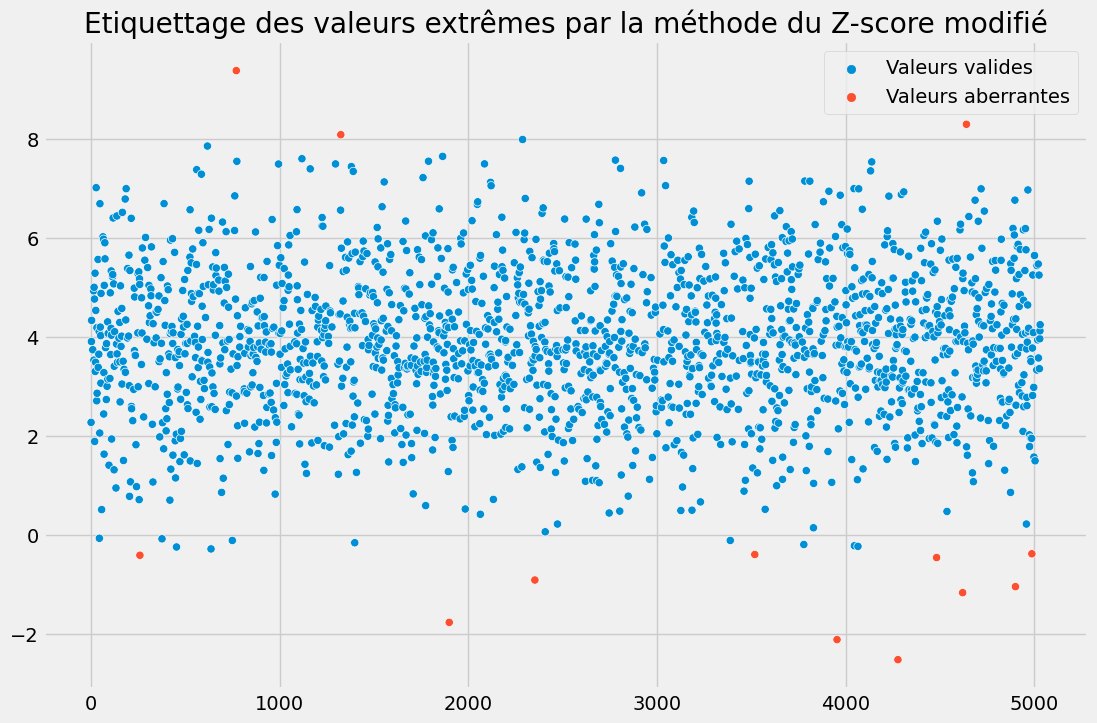

In [ ]:
col = y_gh
sns.scatterplot(x=col.index,y=col.values, hue=np.abs(ex.mod_z(col))>3)
plt.title('Etiquettage des valeurs extrêmes par la méthode du Z-score modifié')
L=plt.legend()
L.get_texts()[0].set_text('Valeurs valides')
L.get_texts()[1].set_text('Valeurs aberrantes')
plt.show()

In [ ]:
tmp.loc[y_en[np.abs(ex.mod_z(y_gh)>3)].index]

BuildingType PrimaryPropertyType  \
259   NonResidential             Storage   
770   NonResidential              Health   
1324  NonResidential              Health   
1899  NonResidential               Other   
2353  NonResidential             Storage   
3519  NonResidential             Storage   
3955  NonResidential               Other   
4278  NonResidential             Storage   
4483  NonResidential           Warehouse   
4621  NonResidential              Office   
4641          Campus               Other   
4901  NonResidential           Education   
4988  NonResidential             Storage   

                                           PropertyName  YearBuilt  \
259                                 5055 Properties LLC       1932   
770   SWEDISH HOSPITAL MEDICAL CENTER First Hill Campus       1994   
1324                                     Central Campus       1964   
1899                            SULTAN HOTEL/LUSTY LADY       1900   
2353                               A1 Self Storage, LLC       1915   
3519                                     MINI-WAREHOUSE       1980   
3955                                     1701 1ST AVE S       1910   
4278                   SALMON BAY TERMINALS - RSVP BLDG       1948   
4483                                    Meaves Building       1900   
4621                                1518 5TH AVE OFFICE       1903   
4641                        Weintraub/Hutchinson/Thomas       1997   
4901                          ISLAMIC SCHOOL OF SEATTLE       1929   
4988                                  Mahoney Warehouse       1980   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
259                 1.0             1.0             24617                   0   
770                 1.0            14.0           1765970                   0   
1324                1.0             3.0            591981                   0   
1899                1.0             3.0             49760                   0   
2353                1.0             3.0             39952                   0   
3519                1.0             3.0             30989                   0   
3955                1.0             3.0             27690                   0   
4278                1.0             1.0             46970                   0   
4483                1.0             5.0             33300                   0   
4621                1.0             3.0             57720                   0   
4641                1.0             5.0            535947                   0   
4901                1.0             2.0             24152                   0   
4988                1.0             3.0             30989                   0   

      PropertyGFABuilding(s) LargestPropertyUseType  \
259                    24617                Storage   
770                  1765970                 Health   
1324                  591981                 Health   
1899                   49760                  Other   
2353                   39952                Storage   
3519                   30989                Storage   
3955                   27690                  Other   
4278                   46970                Storage   
4483                   33300                Storage   
4621                   57720                 Office   
4641                  535947                  Other   
4901                   24152              Education   
4988                   30989                Storage   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
259                     22763.0                        Other   
770                   1639334.0                      Parking   
1324                   520187.0                      Parking   
1899                    24019.0                        Other   
2353                    39952.0                        Other   
3519                    30989.0                        Other   
3955                    24717.0                      Par

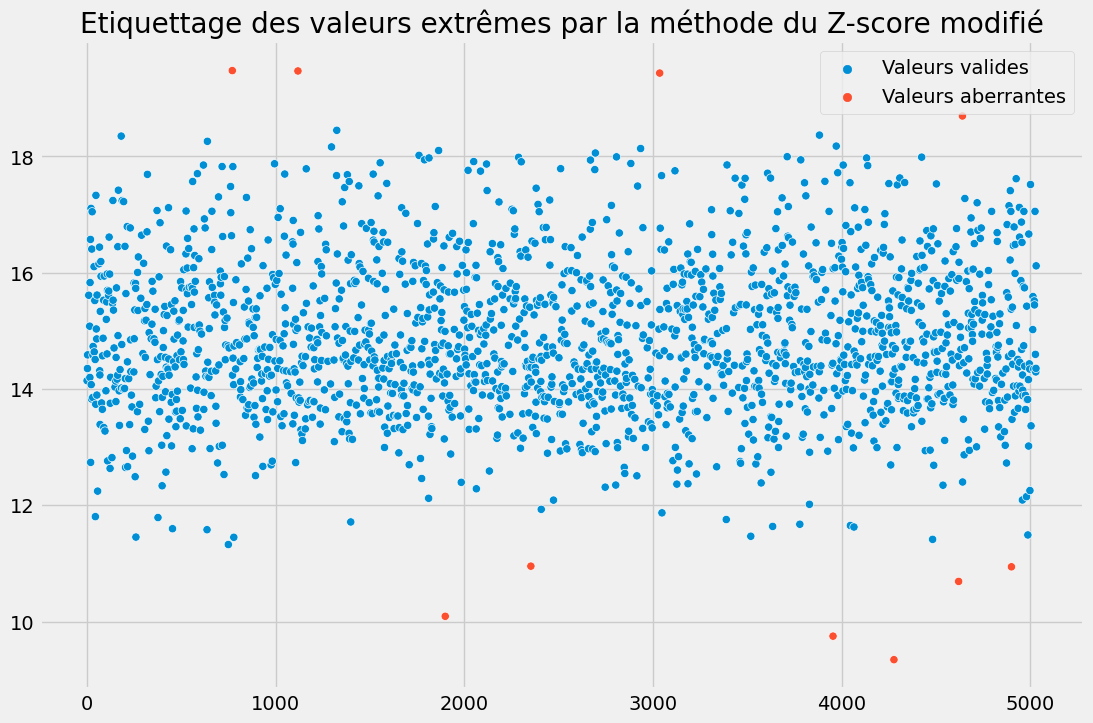

In [ ]:
col = y_en

sns.scatterplot(x=col.index,y=col.values, hue=np.abs(ex.mod_z(col)>3))
plt.title('Etiquettage des valeurs extrêmes par la méthode du Z-score modifié')
L=plt.legend()
L.get_texts()[0].set_text('Valeurs valides')
L.get_texts()[1].set_text('Valeurs aberrantes')
plt.show()

In [ ]:
tmp.loc[y_en[np.abs((ex.mod_z(y_en)>3))].index]

BuildingType PrimaryPropertyType  \
770   NonResidential              Health   
1118  NonResidential               Other   
1899  NonResidential               Other   
2353  NonResidential             Storage   
3036  NonResidential               Other   
3955  NonResidential               Other   
4278  NonResidential             Storage   
4621  NonResidential              Office   
4641          Campus               Other   
4901  NonResidential           Education   

                                           PropertyName  YearBuilt  \
770   SWEDISH HOSPITAL MEDICAL CENTER First Hill Campus       1994   
1118                                THE WESTIN BUILDING       1981   
1899                            SULTAN HOTEL/LUSTY LADY       1900   
2353                               A1 Self Storage, LLC       1915   
3036                                     WestinBuilding       1981   
3955                                     1701 1ST AVE S       1910   
4278                   SALMON BAY TERMINALS - RSVP BLDG       1948   
4621                                1518 5TH AVE OFFICE       1903   
4641                        Weintraub/Hutchinson/Thomas       1997   
4901                          ISLAMIC SCHOOL OF SEATTLE       1929   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
770                 1.0            14.0           1765970                   0   
1118                1.0            33.0            429405                   0   
1899                1.0             3.0             49760                   0   
2353                1.0             3.0             39952                   0   
3036                1.0            33.0            429405                   0   
3955                1.0             3.0             27690                   0   
4278                1.0             1.0             46970                   0   
4621                1.0             3.0             57720                   0   
4641                1.0             5.0            535947                   0   
4901                1.0             2.0             24152                   0   

      PropertyGFABuilding(s) LargestPropertyUseType  \
770                  1765970                 Health   
1118                  429405               Facility   
1899                   49760                  Other   
2353                   39952                Storage   
3036                  429405               Facility   
3955                   27690                  Other   
4278                   46970                Storage   
4621                   57720                 Office   
4641                  535947                  Other   
4901                   24152              Education   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
770                   1639334.0                      Parking   
1118                   218997.0                       Office   
1899                    24019.0                        Other   
2353                    39952.0                        Other   
3036                   218997.0                       Office   
3955                    24717.0                      Parking   
4278                    46970.0                        Other   
4621                    25000.0                        Other   
4641                   535947.0                      Parking   
4901                    24152.0                        Other   

     ThirdLargestPropertyUseType  ENERGYSTARScore  SiteEUIWN(kBtu/sf)  \
770                        Other             59.0          178.600000   
1118                       Other             71.0          663.400000   
1899                       Other              NaN            1.000000   
2353                       Other              NaN            1.500000   
3036                       Other             98.0          639.799988   
3955                       Other              NaN            0.700000   
4278                       Other      

### proc_outlier

In [5]:
def proc_outlier(data):
    tmp = data.copy()
    
    # Il est difficile d'exploiter cette colonne
    try:
        tmp = tmp.drop('Outlier', axis='columns')
    except KeyError as e:
        print(f'Colonne "Outlier" non présente.')
    
    # Suppression valeurs négatives + valeurs nulles pour targets
    index_list = []

    for col in data.select_dtypes(exclude=['object', 'bool', 'category']).columns:
        index_list.extend(tmp[tmp[col] < 0].index)

    index_list.extend(tmp[((tmp.TotalGHGEmissions == 0))].index)
    index_list.extend(tmp[((tmp['SiteEnergyUse(kBtu)'] == 0))].index)

    tmp = tmp.drop(index=index_list)
    print(f'Suppression des valeurs négatives et nulles... ({data.shape[0] - tmp.shape[0]} valeurs supprimées)')
    
    # Suppression des LargestPropertyUseTypeGFA > PropertyGFATotal
    shape_tmp = tmp.shape[0]
    tmp = tmp.drop(index=tmp[tmp.LargestPropertyUseTypeGFA > tmp.PropertyGFATotal].index)
    
    print(f'Suppression  LargestPropertyUseTypeGFA > PropertyGFATotal... ({shape_tmp - tmp.shape[0]} valeurs supprimées)')
    
    # Suppression des lignes "multi-batiments"
    shape_tmp = tmp.shape[0]
    tmp = tmp.drop(index=tmp[tmp.NumberofBuildings > 1].index)
    
    print(f'Suppression multi-batiments... ({shape_tmp - tmp.shape[0]} valeurs supprimées)')
    
    # Suppression avec z-score
    shape_tmp = tmp.shape[0]
    thresh=3
    
    y_gh = np.log(tmp.TotalGHGEmissions)
    y_en = np.log(tmp['SiteEnergyUse(kBtu)'])
    targ = pd.DataFrame()
    targ['log_GHG'] = y_gh ; targ['log_EN'] = y_en
    
    out_to_drop = []
    
    print('log_GHG')
    out_inf, out_sup = ex.outliers_mod_z(targ, 'log_GHG',thresh)
    out_to_drop.extend(out_inf.index) ; out_to_drop.extend(out_sup.index) 
    
    print('log_EN')
    out_inf, out_sup = ex.outliers_mod_z(targ, 'log_EN',thresh)
    out_to_drop.extend(out_inf.index) ; out_to_drop.extend(out_sup.index)
    
    tmp = tmp.drop(index=out_to_drop)
    
    print(f'Suppression par z-score... ({shape_tmp - tmp.shape[0]} valeurs supprimées)')

    
    print(f'TOTAL: {data.shape[0] - tmp.shape[0]} valeurs aberrantes trouvées.')
        
    return tmp

In [ ]:
tmp = proc_name_var(tmp_train)
tmp = proc_nan(tmp)
proc_outlier(tmp)

Suppression de 287 lignes.
Suppression des valeurs négatives et nulles... (7 valeurs supprimées)
Suppression  LargestPropertyUseTypeGFA > PropertyGFATotal... (268 valeurs supprimées)
Suppression multi-batiments... (25 valeurs supprimées)
log_GHG
Outliers inf: 0; Outliers sup: 13 
Outliers inf: 0; Outliers sup: 0 
log_EN
Outliers inf: 0; Outliers sup: 10 
Outliers inf: 0; Outliers sup: 0 
Suppression par z-score... (15 valeurs supprimées)
TOTAL: 315 valeurs aberrantes trouvées.


BuildingType                  PrimaryPropertyType  \
0        NonResidential                            Warehouse   
2     SPS-District K-12                            Education   
3        NonResidential  Residence/Hotel/Senior Care/Housing   
9        NonResidential                               Office   
14       NonResidential                                Other   
...                 ...                                  ...   
5026     NonResidential                               Health   
5028     NonResidential                               Office   
5030     NonResidential                                Other   
5031     NonResidential                              Storage   
5032     NonResidential                               Office   

                                         PropertyName  YearBuilt  \
0                           3401 Colorado Ave S. Whse       1964   
2                                Viewlands Elementary       1954   
3                                   Scargo Apartments       1910   
9                                     NORTHGATE PLAZA       1983   
14                                   CASCADE BUILDING       1949   
...                                               ...        ...   
5026                                      James Tower       1910   
5028                                400 Mercer Street       1987   
5030                                          Laidlaw       1963   
5031                                   VISKO BUILDING       1953   
5032  WATERFRONT PLACE BUILDING MIXED USE CONDOMINIUM       1983   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                   1.0             1.0             33462                   0   
2                   1.0             1.0             42128                   0   
3                   1.0             3.0             29340                   0   
9                   1.0             5.0            122250                   0   
14                  1.0             1.0             22405                   0   
...                 ...             ...               ...                 ...   
5026                1.0             6.0            320946                   0   
5028                1.0             6.0             78672               28427   
5030                1.0             1.0             23260                   0   
5031                1.0             1.0             31521                   0   
5032                1.0            13.0            307557               83064   

      PropertyGFABuilding(s) LargestPropertyUseType  \
0                      33462                Storage   
2                      42128              Education   
3                      29340                 Office   
9                     122250                 Office   
14                     22405                  Other   
...                      ...                    ...   
5026                  320946                 Health   
5028                   50245                 Office   
5030                   23260                  Other   
5031                   31521                Storage   
5032                  224493                 Office   

      LargestPropertyUseTypeGFA         SecondLargestPropertyUseType  \
0                       33462.0                                Other   
2                       42128.0                                Other   
3                       12714.0  Residence/Hotel/Senior Care/Housing   
9                       91281.0                            Education   
14                      11000.0                               Retail   
...                         ...                                  ...   
5026                   236359.0                               Health   
5028                    78672.0                                Other   
5030                    13075.0                               Office   
5031                    31521.0                                Other   

## Feature Scaling

On met chacune de nos données à la même échelle tout en conservant les proportions de notre échantillon. <br>
On passe aussi au log les variables ayant une asymétrie importante.

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def scale(data):
    '''
    Renvoie log(target GHG), log(target EN), df normalisé
    '''
    tmp = data.copy()
    
    y_gh = np.log(tmp.TotalGHGEmissions+1)
    y_en = np.log(tmp['SiteEnergyUse(kBtu)']+1)
    tmp.drop(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], axis='columns', inplace=True)
    
    # Je récupère les colonnes avec une asymétrie importante
    col_high_var = (abs(tmp.skew().sort_values(ascending=False)).index[np.abs(tmp.skew().sort_values(ascending=False) ) > 3]).to_list()

    for col in col_high_var:
        print(f'Passage au log de {col}')
        tmp[col] = np.log(tmp[col]+1)
    
    # scaler = RobustScaler() # (X-med)/ IQR
    # scaled = scaler.fit_transform(tmp.select_dtypes(exclude=['object', 'category', 'bool']))
    # tmp[tmp.select_dtypes(exclude=['object', 'category', 'bool']).columns] = scaled    
    
    return y_gh, y_en, tmp, col_high_var

In [ ]:
tmp = proc_name_var(tmp_train)
tmp = proc_nan(tmp)
tmp = proc_outlier(tmp)

_,_,tmp,_ = scale(tmp)

Suppression de 287 lignes.
Suppression des valeurs négatives et nulles... (7 valeurs supprimées)
Suppression  LargestPropertyUseTypeGFA > PropertyGFATotal... (268 valeurs supprimées)
Suppression multi-batiments... (25 valeurs supprimées)
log_GHG
Outliers inf: 0; Outliers sup: 13 
Outliers inf: 0; Outliers sup: 0 
log_EN
Outliers inf: 0; Outliers sup: 10 
Outliers inf: 0; Outliers sup: 0 
Suppression par z-score... (15 valeurs supprimées)
TOTAL: 315 valeurs aberrantes trouvées.
Passage au log de SteamUse(kBtu)
Passage au log de NumberofFloors
Passage au log de LargestPropertyUseTypeGFA
Passage au log de NaturalGas(kBtu)
Passage au log de PropertyGFABuilding(s)
Passage au log de GHGEmissionsIntensity
Passage au log de PropertyGFATotal
Passage au log de PropertyGFAParking
Passage au log de SourceEUIWN(kBtu/sf)
Passage au log de Electricity(kBtu)
Passage au log de SiteEUIWN(kBtu/sf)
Passage au log de SiteEnergyUseWN(kBtu)
Passage au log de NumberofBuildings


## Feature Engineering

Je construis des proportions à l'aide de variables responsables de data leakage pour chaque type de propriété.

In [ ]:
tmp = proc_name_var(tmp_train)
tmp = proc_nan(tmp)
tmp = proc_outlier(tmp)

tmp.head()

Suppression de 287 lignes.
Suppression des valeurs négatives et nulles... (7 valeurs supprimées)
Suppression  LargestPropertyUseTypeGFA > PropertyGFATotal... (268 valeurs supprimées)
Suppression multi-batiments... (25 valeurs supprimées)
log_GHG
Outliers inf: 0; Outliers sup: 13 
Outliers inf: 0; Outliers sup: 0 
log_EN
Outliers inf: 0; Outliers sup: 10 
Outliers inf: 0; Outliers sup: 0 
Suppression par z-score... (15 valeurs supprimées)
TOTAL: 315 valeurs aberrantes trouvées.


BuildingType                  PrimaryPropertyType  \
0      NonResidential                            Warehouse   
2   SPS-District K-12                            Education   
3      NonResidential  Residence/Hotel/Senior Care/Housing   
9      NonResidential                               Office   
14     NonResidential                                Other   

                 PropertyName  YearBuilt  NumberofBuildings  NumberofFloors  \
0   3401 Colorado Ave S. Whse       1964                1.0             1.0   
2        Viewlands Elementary       1954                1.0             1.0   
3           Scargo Apartments       1910                1.0             3.0   
9             NORTHGATE PLAZA       1983                1.0             5.0   
14           CASCADE BUILDING       1949                1.0             1.0   

    PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0              33462                   0                   33462   
2              42128                   0                   42128   
3              29340                   0                   29340   
9             122250                   0                  122250   
14             22405                   0                   22405   

   LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                 Storage                    33462.0   
2               Education                    42128.0   
3                  Office                    12714.0   
9                  Office                    91281.0   
14                  Other                    11000.0   

           SecondLargestPropertyUseType ThirdLargestPropertyUseType  \
0                                 Other                       Other   
2                                 Other                       Other   
3   Residence/Hotel/Senior Care/Housing                     Leisure   
9                             Education                     Offices   
14                               Retail                       Other   

    ENERGYSTARScore  SiteEUIWN(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0               1.0           41.400002            130.100006   
2              93.0           44.400002             92.900002   
3               NaN           87.300003            157.600006   
9              91.0           47.300000            148.400000   
14              NaN          194.300000            322.200000   

    SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
0           1386445.375            1386445.375             0.0   
2           1709307.500            1869043.875             0.0   
3           2160420.000            2370772.250             0.0   
9           6022054.000            6022054.000             0.0   
14          3537977.000            3594204.000             0.0   

    Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
0           1386445.0               0.0               9.67   
2            893537.0          815770.0              49.55   
3            839832.0         1320588.0              75.99   
9           6022304.0               0.0              41.98   
14          1085193.0         2452829.0             137.83   

    GHGEmissionsIntensity  
0                    0.29  
2                    1.18  
3                    2.59  
9                    0.13  
14                   5.94

In [ ]:
tmp.groupby('PrimaryPropertyType').mean()[['SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)','SiteEnergyUseWN(kBtu)', 
                                                  'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
                                                  'GHGEmissionsIntensity']]

SiteEUIWN(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
PrimaryPropertyType                                                             
Education                                     57.027660            104.895745   
Facility                                      63.700000            189.727273   
Health                                        92.811765            243.991176   
Leisure                                       62.052459            112.967213   
Offices                                       65.653285            181.440389   
Other                                        117.515024            265.702347   
Residence/Hotel/Senior Care/Housing           93.748634            207.573224   
Retail                                        74.620000            191.702500   
Storage                                       35.261321             82.314151   
Supermarket                                  255.261538            602.603846   
Warehouse                                     74.133334            120.300001   

                                     SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
PrimaryPropertyType                                                          
Education                                     4.713027e+06    15797.468085   
Facility                                      3.022652e+06        0.000000   
Health                                        1.153843e+07   996844.823529   
Leisure                                       2.095692e+06    11857.950820   
Offices                                       8.104876e+06   205829.513382   
Other                                         8.623539e+06   413171.507042   
Residence/Hotel/Senior Care/Housing           8.619819e+06   701857.841530   
Retail                                        4.321087e+06        0.000000   
Storage                                       1.877423e+06        0.000000   
Supermarket                                   9.957116e+06        0.000000   
Warehouse                                     2.443900e+06        0.000000   

                                     Electricity(kBtu)  NaturalGas(kBtu)  \
PrimaryPropertyType                                                        
Education                                 2.403435e+06      2.289573e+06   
Facility                                  2.937391e+06      1.399032e+05   
Health                                    8.411811e+06      1.896192e+06   
Leisure                                   7.404556e+05      1.143883e+06   
Offices                                   7.376930e+06      6.566885e+05   
Other                                     5.624577e+06      2.312488e+06   
Residence/Hotel/Senior Care/Housing       5.135006e+06      2.501517e+06   
Retail                                    3.136365e+06      1.013599e+06   
Storage                                   1.168380e+06      5.502730e+05   
Supermarket                               6.368975e+06      3.190208e+06   
Warehouse                                 6.173090e+05      1.549973e+06   

                                     GHGEmissionsIntensity  
PrimaryPropertyType                                         
Education                                         1.408511  
Facility                                          0.382727  
Health                                            1.054118  
Leisure                                           1.857213  
Offices                                           0.643528  
Other                                             2.361596  
Residence/Hotel/Senior Care/Housing               2.117104  
Retail                                            1.046250  
Storage                                           0.623208  
Supermarket                                       4.121923  
Warehouse                                         2.596667

In [7]:
tmp = proc_name_var(tmp_train)
tmp = proc_nan(tmp)
tmp = proc_outlier(tmp)

proportion_CST = tmp.groupby('PrimaryPropertyType').median()[['SiteEnergyUseWN(kBtu)', 
                                                  'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
                                                  'GHGEmissionsIntensity']]

def add_proportion(data, proportion=proportion_CST):
    tmp = data.copy()
    
    # Ajout d'une colonne indiquant l'énergie moyenne consommée par ces batiments
    tmp['SiteEnergyUse_PropertyType'] = 0
    for ind in tmp.index:
        tmp.loc[ind,'SiteEnergyUse_PropertyType'] = proportion.loc[tmp.loc[ind,'PrimaryPropertyType'],'SiteEnergyUseWN(kBtu)']
    
    # Ajout d'une colonne indiquant l'intensité de GHG émise par ces batiments
    tmp['GHGEmissionsIntensity_PropertyType'] = 0
    for ind in tmp.index:
        tmp.loc[ind,'GHGEmissionsIntensity_PropertyType'] = proportion.loc[tmp.loc[ind,'PrimaryPropertyType'],'GHGEmissionsIntensity']
    
    # Ajout d'une colonne indiquant la vapeur moyenne consommée par ces batiments
    tmp['SteamUse_PropertyType'] = 0
    for ind in tmp.index:
        tmp.loc[ind,'SteamUse_PropertyType'] = proportion.loc[tmp.loc[ind,'PrimaryPropertyType'],'SteamUse(kBtu)']
    
    # Ajout d'une colonne indiquant l'électricité moyenne consommée par ces batiments
    tmp['Electricity_PropertyType'] = 0
    for ind in tmp.index:
        tmp.loc[ind,'Electricity_PropertyType'] = proportion.loc[tmp.loc[ind,'PrimaryPropertyType'],'Electricity(kBtu)']
    
    # Ajout d'une colonne indiquant le gaz moyen consommé par ces batiments
    tmp['NaturalGas_PropertyType'] = 0
    for ind in tmp.index:
        tmp.loc[ind,'NaturalGas_PropertyType'] = proportion.loc[tmp.loc[ind,'PrimaryPropertyType'],'NaturalGas(kBtu)']
        
    return tmp

def feature_engineering(data):
    tmp=data.copy()
    
    # ...
    
    tmp = tmp.drop(['SiteEnergyUseWN(kBtu)',
                    'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
                    'GHGEmissionsIntensity', 
                    'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',], axis='columns')
    
    return tmp

Suppression de 300 lignes.
Suppression des valeurs négatives et nulles... (5 valeurs supprimées)
Suppression  LargestPropertyUseTypeGFA > PropertyGFATotal... (243 valeurs supprimées)
Suppression multi-batiments... (28 valeurs supprimées)
log_GHG
Outliers inf: 0; Outliers sup: 7 
Outliers inf: 0; Outliers sup: 0 
log_EN
Outliers inf: 0; Outliers sup: 8 
Outliers inf: 0; Outliers sup: 0 
Suppression par z-score... (9 valeurs supprimées)
TOTAL: 285 valeurs aberrantes trouvées.


## Application 

In [8]:
def preproc(data, starscore=False):
    tmp = proc_name_var(data)
    tmp = tmp.drop(labels='PropertyName', axis=1)
    tmp = proc_nan(tmp)
    if starscore:
        tmp = tmp.dropna(subset=['ENERGYSTARScore'])

    tmp = proc_outlier(tmp)

    tmp = feature_engineering(tmp)
    
    y_gh, y_en, tmp, col_high_var = scale(tmp)

    return y_gh, y_en, tmp, col_high_var

In [9]:
def preproc_test(data, col_high_var, starscore=False):
    tmp = proc_name_var(data)
    tmp = tmp.drop(labels='PropertyName', axis=1)
    tmp = proc_nan(tmp)
    if starscore:
        tmp = tmp.dropna(subset=['ENERGYSTARScore'])

    tmp = proc_outlier(tmp)

    tmp = feature_engineering(tmp)
    
                ### SCALING VARIABLES ###
    # Je transforme mes targets comme mon train
    y_gh = np.log(tmp.TotalGHGEmissions+1)
    y_en = np.log(tmp['SiteEnergyUse(kBtu)']+1)
    tmp.drop(['TotalGHGEmissions', 'SiteEnergyUse(kBtu)'], axis='columns', inplace=True)
    
    # Je posse au log les mêmes variables que dans mon train
    for col in col_high_var:
        print(f'Passage au log de {col}')
        tmp[col] = np.log(tmp[col]+1)
                ### FIN SCALING VARIABLES ###

    return y_gh, y_en, tmp

# Modélisation

In [10]:
from sklearn.dummy import DummyRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV, validation_curve, RandomizedSearchCV, StratifiedShuffleSplit

from sklearn.pipeline import make_pipeline

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import xgboost as xgb

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [11]:
def errors_measures(model,  X, y, name_model, name_target, cv=10, random_state=42):
    '''
    Build a dataframe with severals measures of errors.
    '''
    
    d = {'model':[name_model],
     'target':[name_target], 
     'RMSE':[round(cross_val_score(model, X, y, cv=cv,scoring='neg_root_mean_squared_error').mean(),3)],
     #'MAPE':[cross_val_score(model, X, y, cv=cv,scoring='neg_mean_absolute_percentage_error').mean()],
     'MAE':[round(cross_val_score(model, X, y, cv=cv,scoring='neg_mean_absolute_error').mean(),3)],
     #'MedAE':[cross_val_score(model, X, y, cv=cv,scoring='neg_median_absolute_error').mean()],
     'MSE':[round(cross_val_score(model, X, y, cv=cv,scoring='neg_mean_squared_error').mean(),3)],
     'R2':[round(cross_val_score(model, X, y, cv=cv,scoring='r2').mean(),3)],
        }

    return pd.DataFrame.from_dict(d,orient='columns')

def evaluate_estimators(X, y, name_target, cv=5, random_state=42):
    '''
    Evaluate and determine the best hyperparameters for LinearRegression, RidgeRegression, LassoRegression, ElasticNet Regression and SVR
    Then, display residuals plots for each estimators
    '''
    d = {'model':[],
     'target':[], 
     'RMSE':[],
     'MSE':[],
     'MAE':[],
     'R2':[],
    }

    results = pd.DataFrame.from_dict(d)
    
    # DummyOne
    results = results.append(errors_measures(DummyRegressor(strategy="mean"), X, y, 'DummyMean', name_target))
    # results = results.append(errors_measures(DummyRegressor(strategy="median"), X, y, 'DummyMedian', name_target))
    
    # The classic One
    results = results.append(errors_measures(linear_model.LinearRegression(), X, y, 'LinearRegression', name_target))

    # The Ridge aka the Square Penalty One
    parameters = {"alpha": np.logspace(-10,10,50)}

    grid_ridge = GridSearchCV(estimator = linear_model.Ridge(random_state=random_state), 
                      param_grid = parameters,
                      scoring = 'r2',
                      cv=cv,
                      n_jobs=-1,
                      verbose=0
                     )

    grid_ridge.fit(X, y)
    
    res = {key : round(grid_ridge.best_params_[key], 3) for key in grid_ridge.best_params_}
    print(f'RIDGE - Meilleurs params: {res}')
    
    results = results.append(errors_measures(grid_ridge.best_estimator_, X, y, 'RidgeRegression', name_target))

    
    # The Lasso aka the Absolute Penalty One
    parameters = {"alpha": np.logspace(-10,10,80)}

    grid_lasso = GridSearchCV(estimator = linear_model.Lasso(random_state=random_state), 
                          param_grid = parameters,
                          scoring = 'r2',
                          cv=cv,
                          n_jobs=-1,
                          verbose=0
                         )

    grid_lasso.fit(X, y)
    res = {key : round(grid_lasso.best_params_[key], 3) for key in grid_lasso.best_params_}

    print(f'LASSO - Meilleurs params: {res}')

    results = results.append(errors_measures(grid_lasso.best_estimator_, X, y, 'LassoRegression', name_target))
    
    # The Elastic One
    parameters = {"alpha": np.logspace(-10,10,80),"l1_ratio": np.arange(0.0, 1.0, 0.05)}

    grid_elasticNet = GridSearchCV(estimator = linear_model.ElasticNet(random_state=random_state), 
                      param_grid = parameters,
                      scoring = 'r2',
                      cv=cv,
                      n_jobs=-1,
                      verbose=0
                     )

    grid_elasticNet.fit(X, y)
    res = {key : round(grid_elasticNet.best_params_[key], 3) for key in grid_elasticNet.best_params_}
    
    print(f'Elastic - Meilleurs params: {res}')
    
    results = results.append(errors_measures(grid_elasticNet.best_estimator_, X, y, 'Elastic-net', name_target))

    
    # The Support vector One
    parameters = {'C' :[3,5,10],
         'epsilon': np.linspace(0.1,1,5),
         'gamma': np.linspace(0,0.04,11),
         }

    grid_svr_gh = GridSearchCV(estimator = SVR(), 
                               param_grid = parameters, 
                               cv = cv,
                               n_jobs = -1, 
                               verbose = 0)

    grid_svr_gh.fit(X, y)
    res = {key : round(grid_svr_gh.best_params_[key], 3) for key in grid_svr_gh.best_params_}
    
    print(f'SVR - Meilleurs params: {res}')

    results = results.append(errors_measures(grid_svr_gh.best_estimator_, X, y, 'SVR', name_target))
    
    # Affichage
    
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(27, 20), dpi= 80, facecolor='w', edgecolor='k')

    sns.regplot(ax=axs[0,0],x=y,y=grid_ridge.best_estimator_.predict(X), marker='.', label='Data', scatter_kws={"color": "black"}, scatter=True, line_kws={'label':'Corrélation obtenue', "color": "orange"})
    axs[0,0].plot([y.min()-0.1, y.max()+0.1], [y.min()-0.1, y.max()+0.1], 'r--', lw=4, label='Corrélation attendue')
    axs[0,0].set_title('Ridge',fontsize=30)
    axs[0,0].set_xlabel('Valeur réelle',fontsize=22)
    axs[0,0].set_ylabel('Prédiction',fontsize=22)
    axs[0,0].tick_params(axis="x", labelsize=22)
    axs[0,0].tick_params(axis="y", labelsize=22)
    axs[0,0].legend()

    sns.scatterplot(ax=axs[1,0], x=y,y=grid_ridge.best_estimator_.predict(X)-y, color='black', marker='o', label='Data')
    axs[1,0].plot([y.min()-0.1, y.max()+0.1],[0,0], 'r--', lw=2)
    axs[1,0].plot([], [], ' ', label=f'Moyenne des résidus = {round((grid_ridge.best_estimator_.predict(X)-y).mean(), 4)}')
    axs[1,0].set_xlabel('Valeur réelle',fontsize=22)
    axs[1,0].set_ylabel('Résidus',fontsize=22)
    axs[1,0].tick_params(axis="x", labelsize=22)
    axs[1,0].tick_params(axis="y", labelsize=22)
    axs[1,0].legend()

    ###
    
    sns.regplot(ax=axs[0,1],x=y,y=grid_lasso.best_estimator_.predict(X), marker='.', label='Data', scatter_kws={"color": "black"}, scatter=True, line_kws={'label':'Corrélation obtenue', "color": "orange"})
    axs[0,1].plot([y.min()-0.1, y.max()+0.1], [y.min()-0.1, y.max()+0.1], 'r--', lw=4, label= 'Corrélation attendue')
    axs[0,1].set_title('Lasso',fontsize=30)
    axs[0,1].set_xlabel('Valeur réelle',fontsize=22)
    axs[0,1].set_ylabel('Prédiction',fontsize=22)
    axs[0,1].tick_params(axis="x", labelsize=22)
    axs[0,1].tick_params(axis="y", labelsize=22)
    axs[0,1].legend()
    
    sns.scatterplot(ax=axs[1,1], x=y,y=grid_lasso.best_estimator_.predict(X)-y, color='black', marker='o', label='Data')
    axs[1,1].plot([y.min()-0.1, y.max()+0.1],[0,0], 'r--', lw=2)
    axs[1,1].plot([], [], ' ', label=f'Moyenne des résidus = {round((grid_lasso.best_estimator_.predict(X)-y).mean(), 4)}')
    axs[1,1].set_xlabel('Valeur réelle',fontsize=22)
    axs[1,1].set_ylabel('Résidus',fontsize=22)
    axs[1,1].tick_params(axis="x", labelsize=22)
    axs[1,1].tick_params(axis="y", labelsize=22)
    axs[1,1].legend()
    
    ###
    
    sns.regplot(ax=axs[0,2],x=y,y=grid_elasticNet.best_estimator_.predict(X), marker='.', label='Data', scatter_kws={"color": "black"}, scatter=True, line_kws={'label':'Corrélation obtenue', "color": "orange"})
    axs[0,2].plot([y.min()-0.1, y.max()+0.1], [y.min()-0.1, y.max()+0.1], 'r--', lw=4, label='Corrélation attendue')
    axs[0,2].set_title('ElasticNet',fontsize=30)
    axs[0,2].set_xlabel('Valeur réelle',fontsize=22)
    axs[0,2].set_ylabel('Prédiction',fontsize=22)
    axs[0,2].tick_params(axis="x", labelsize=22)
    axs[0,2].tick_params(axis="y", labelsize=22)
    axs[0,2].legend()
    
    sns.scatterplot(ax=axs[1,2], x=y,y=grid_elasticNet.best_estimator_.predict(X)-y, color='black', marker='o', label='Data')
    axs[1,2].plot([y.min()-0.1, y.max()+0.1],[0,0], 'r--', lw=2)
    axs[1,2].plot([], [], ' ', label=f'Moyenne des résidus = {round((y - grid_elasticNet.best_estimator_.predict(X)).mean(), 4)}')
    axs[1,2].set_xlabel('Valeur réelle',fontsize=22)
    axs[1,2].set_ylabel('Résidus',fontsize=22)
    axs[1,2].tick_params(axis="x", labelsize=22)
    axs[1,2].tick_params(axis="y", labelsize=22)
    axs[1,2].legend()
    
    ### 
    
    sns.regplot(ax=axs[0,3],x=y,y=grid_svr_gh.best_estimator_.predict(X), marker='.', label='Data', scatter_kws={"color": "black"}, scatter=True, line_kws={'label':'Corrélation obtenue', "color": "orange"})
    axs[0,3].plot([y.min()-0.1, y.max()+0.1], [y.min()-0.1, y.max()+0.1], 'r--', lw=4, label='Corrélation attendue')
    axs[0,3].set_title('SVR',fontsize=30)
    axs[0,3].set_xlabel('Valeur réelle',fontsize=22)
    axs[0,3].set_ylabel('Prédiction',fontsize=22)
    axs[0,3].tick_params(axis="x", labelsize=22)
    axs[0,3].tick_params(axis="y", labelsize=22)
    axs[0,3].legend()

    sns.scatterplot(ax=axs[1,3], x=y,y=grid_svr_gh.best_estimator_.predict(X)-y, color='black', marker='o', label='Data')
    axs[1,3].plot([y.min()-0.1, y.max()+0.1],[0,0], 'r--', lw=2)
    axs[1,3].plot([], [], ' ', label=f'Moyenne des résidus = {round((y - grid_svr_gh.best_estimator_.predict(X)).mean(), 4)}')
    axs[1,3].set_xlabel('Valeur réelle',fontsize=22)
    axs[1,3].set_ylabel('Résidus',fontsize=22)
    axs[1,3].tick_params(axis="x", labelsize=22)
    axs[1,3].tick_params(axis="y", labelsize=22)
    axs[1,3].legend()

    plt.show()
    
    return results, [grid_ridge, grid_lasso, grid_elasticNet, grid_svr_gh]

## Choix du modèle

In [12]:
y_train_gh, y_train_en, X_train, col_high_var = preproc(train)

scaler_train = StandardScaler() # (X-med)/ IQR
scaled = scaler_train.fit_transform(X_train.select_dtypes(exclude=['object', 'category', 'bool']))
X_train[X_train.select_dtypes(exclude=['object', 'category', 'bool']).columns] = scaled

X_train = add_proportion(X_train)

X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object', 'category']).columns)

X_train = X_train.drop(labels=['ENERGYSTARScore'],axis='columns')
X_train.shape

Suppression de 300 lignes.
Suppression des valeurs négatives et nulles... (5 valeurs supprimées)
Suppression  LargestPropertyUseTypeGFA > PropertyGFATotal... (243 valeurs supprimées)
Suppression multi-batiments... (28 valeurs supprimées)
log_GHG
Outliers inf: 0; Outliers sup: 7 
Outliers inf: 0; Outliers sup: 0 
log_EN
Outliers inf: 0; Outliers sup: 8 
Outliers inf: 0; Outliers sup: 0 
Suppression par z-score... (9 valeurs supprimées)
TOTAL: 285 valeurs aberrantes trouvées.
Passage au log de NumberofFloors
Passage au log de LargestPropertyUseTypeGFA
Passage au log de PropertyGFABuilding(s)
Passage au log de PropertyGFATotal
Passage au log de PropertyGFAParking
Passage au log de NumberofBuildings


(1919, 60)

### Récupération des modèles précédemment entrainés

In [13]:
# Sauvegarde des modèles GHG

# Ridge, Lasso, Elastic, SVR
pickle_in = open('.models_saved/grids_gh.pickle', 'rb')
grids_gh = pickle.load(pickle_in)
pickle_in.close()

# RF
# RandomizedSearch
pickle_in = open('.models_saved/model_param_search_gh.pickle', 'rb')
model_param_search_gh = pickle.load(pickle_in)
pickle_in.close()

# GridSearch
pickle_in = open('.models_saved/grid_rf_gh.pickle', 'rb')
grid_rf_gh = pickle.load(pickle_in)
pickle_in.close()

# XGB
# Randomized
pickle_in = open('.models_saved/model_param_search_xg_gh.pickle', 'rb')
model_param_search_xg_gh = pickle.load(pickle_in)
pickle_in.close()

# GridSearch
pickle_in = open('.models_saved/grid_xgb_en.pickle', 'rb')
grid_xgb_en = pickle.load(pickle_in)
pickle_in.close()


# Sauvegarde mes modèles EN

# Ridge, Lasso, Elastic, SVR
pickle_in = open('.models_saved/grids_en.pickle', 'rb')
grids_en = pickle.load(pickle_in)
pickle_in.close()

# RF
# RandomizedSearch
pickle_in = open('.models_saved/model_param_search_en.pickle', 'rb')
model_param_search_en = pickle.load(pickle_in)
pickle_in.close()

# GridSearch
pickle_in = open('.models_saved/grid_rf_en.pickle', 'rb')
grid_rf_en = pickle.load(pickle_in)
pickle_in.close()

# XGB
# Randomized
pickle_in = open('.models_saved/model_param_search_xg_en.pickle', 'rb')
model_param_search_xg_en = pickle.load(pickle_in)
pickle_in.close()

# GridSearch
pickle_in = open('.models_saved/grid_xgb_gh.pickle', 'rb')
grid_xgb_gh = pickle.load(pickle_in)
pickle_in.close()



### TotalGHGEmissions

#### Linear - Ridge - Lasso - Elastic - SVR

RIDGE - Meilleurs params: {'alpha': 10.481}
LASSO - Meilleurs params: {'alpha': 0.002}
Elastic - Meilleurs params: {'alpha': 0.004, 'l1_ratio': 0.15}
SVR - Meilleurs params: {'C': 5, 'epsilon': 0.325, 'gamma': 0.02}


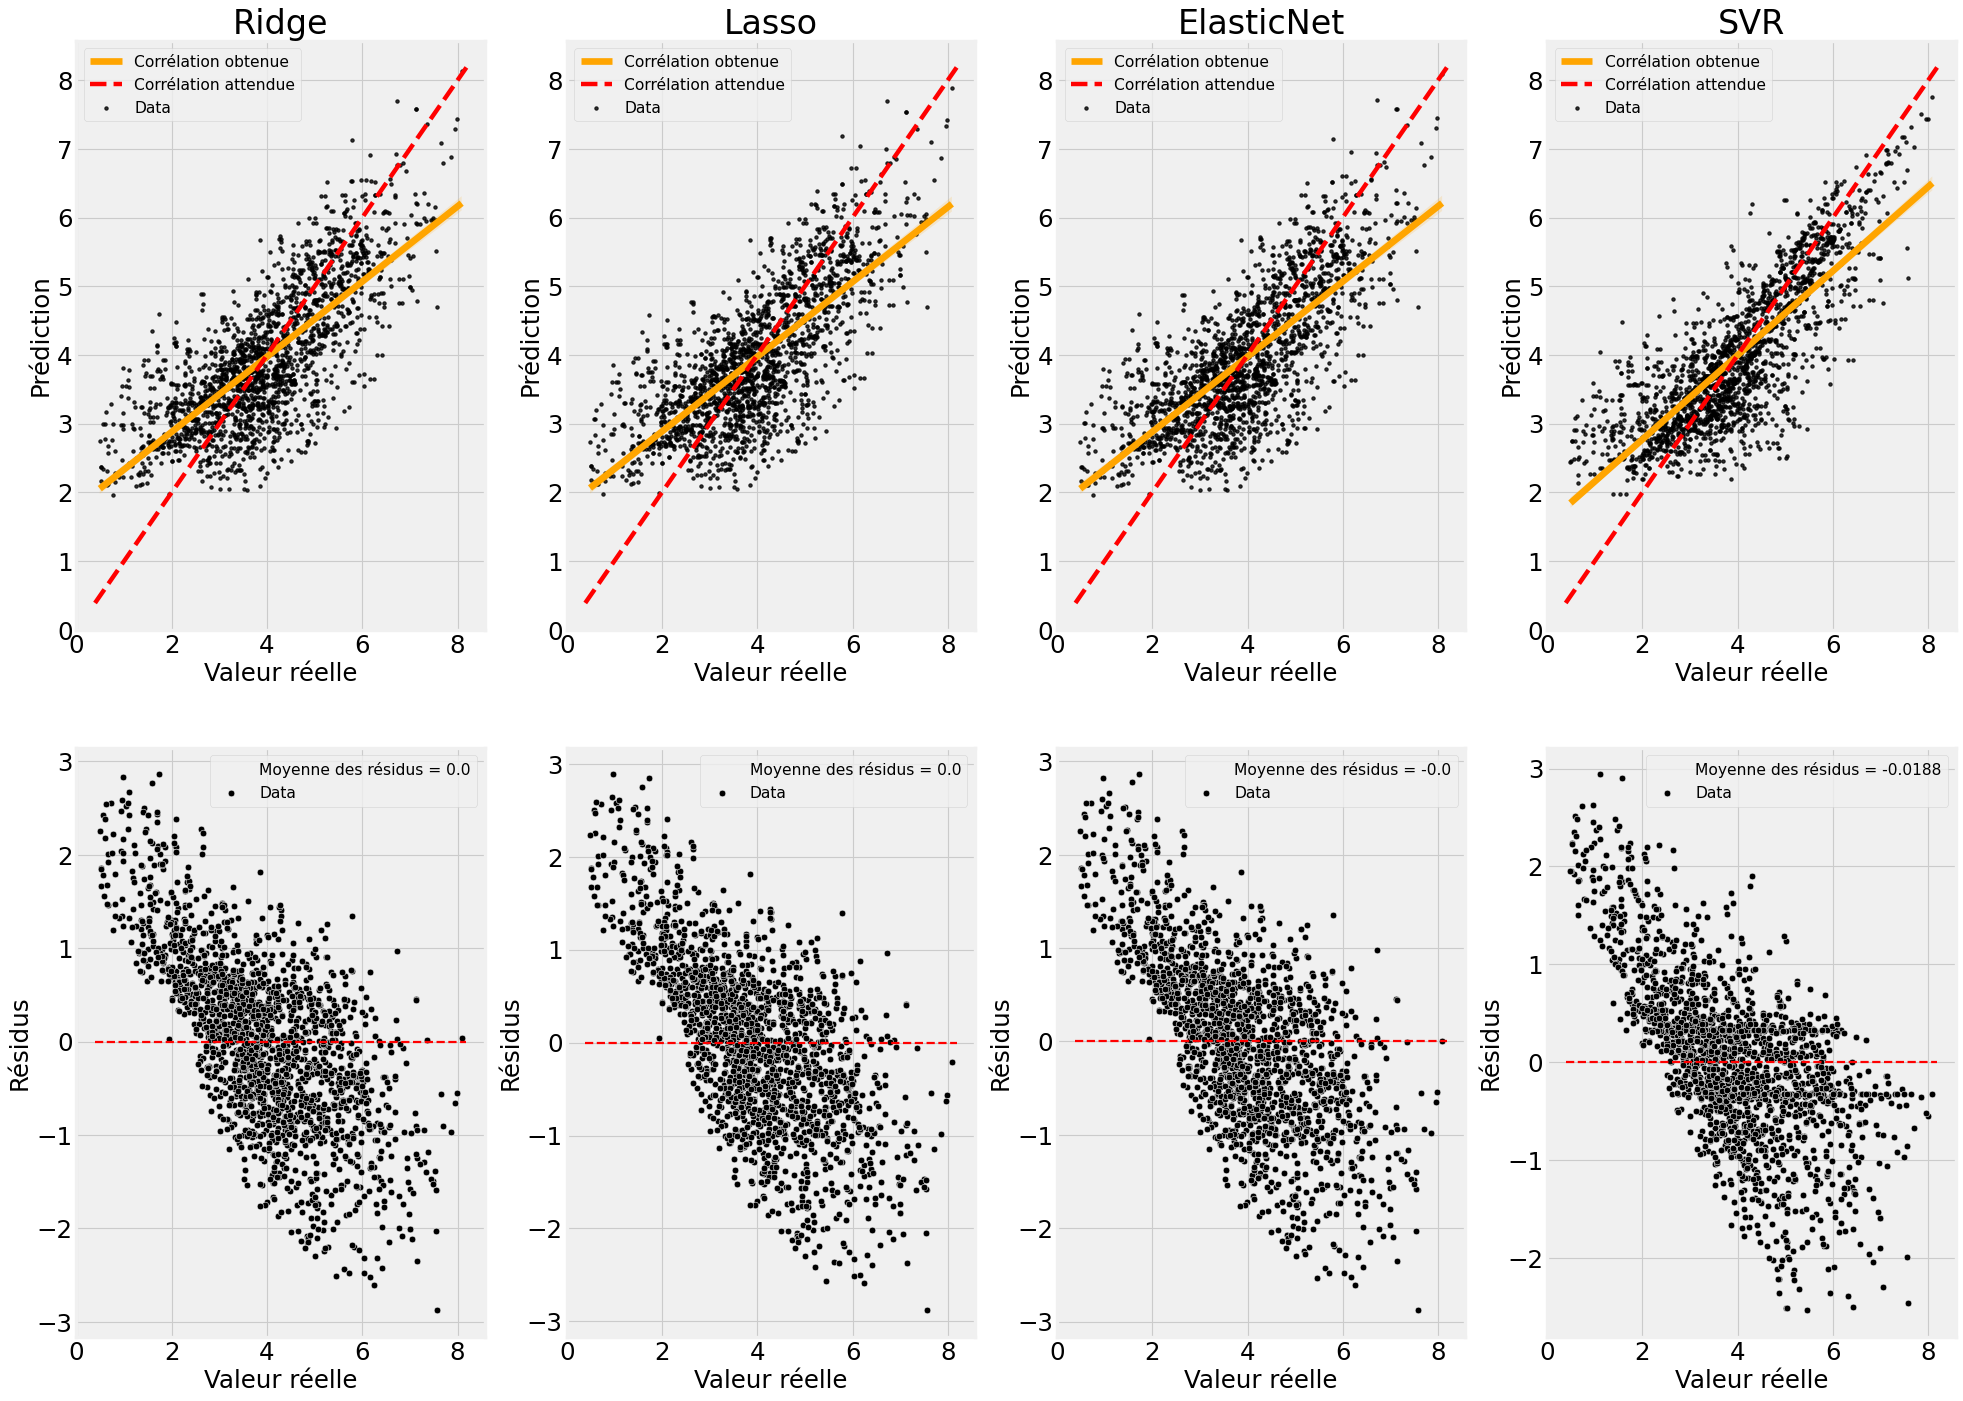

Wall time: 1min 23s


model target   RMSE    MSE    MAE     R2
0         DummyMean    GHG -1.392 -1.942 -1.116 -0.007
0  LinearRegression    GHG -0.953 -0.910 -0.756  0.526
0   RidgeRegression    GHG -0.949 -0.902 -0.755  0.530
0   LassoRegression    GHG -0.950 -0.904 -0.756  0.529
0       Elastic-net    GHG -0.949 -0.902 -0.755  0.530
0               SVR    GHG -0.928 -0.864 -0.716  0.549

In [14]:
%%time
r, grids_gh = evaluate_estimators(X=X_train, y=y_train_gh, name_target='GHG', cv=5, random_state=42)
r

#### Random Forest

In [16]:
%%time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

param_grid = {
    'n_estimators': np.arange(1, 800, 1), # Nombre d'arbres dans notre forêt
    'max_leaf_nodes': np.arange(1, 1200, 1), # Le nombre max de feuilles par arbres
    'max_depth': np.arange(1, 200, 1), # La profondeur maximale d'un arbre
    'max_features' : ['auto', 'sqrt', 'log2'], # Le nombre de features à regarder pour construire un arbre
    }

scoring = {'MAE':'neg_mean_absolute_error',  "R2": 'r2'}

model_param_search_gh = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), param_distributions=param_grid,
                                 n_jobs=-1, cv=5, n_iter=600, scoring=scoring, return_train_score=True, refit=False)

model_param_search_gh.fit(X_train,y_train_gh)

Wall time: 10min 15s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=600, n_jobs=-1,
                   param_distributions={'max_depth': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,...
       729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741,
       742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754,
       755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767,
       768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780,
       781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793,
       794, 795, 796, 797, 798, 799])},
          

In [17]:
cv_results =  pd.DataFrame(model_param_search_gh.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_features', 'param_n_estimators', 'param_max_leaf_nodes', 'param_max_depth']].sort_values(by='mean_test_R2',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_MAE  mean_train_MAE  \
439      0.711938       0.957009      -0.539596       -0.209278   
233      0.711925       0.957006      -0.539636       -0.209288   
249      0.711788       0.956899      -0.539851       -0.209460   
163      0.711680       0.957077      -0.539765       -0.209251   
74       0.711678       0.956991      -0.539834       -0.209313   
312      0.711607       0.957212      -0.539966       -0.208887   
128      0.711593       0.957079      -0.539768       -0.209263   
556      0.711548       0.957210      -0.540094       -0.208900   
11       0.711511       0.957222      -0.540160       -0.208892   
321      0.711497       0.957180      -0.539983       -0.208974   

    param_max_features param_n_estimators param_max_leaf_nodes param_max_depth  
439               auto                420                 1072             114  
233               auto                421                 1098             186  
249               auto                406                  925             146  
163               auto                465                 1091             122  
74                auto                431                 1015             182  
312               auto                720                  874              38  
128               auto                468                 1174             174  
556               auto                753                 1113             149  
11                auto                770                  816             175  
321               auto                712                  853             139

In [32]:
%%time

param_grid = {
    'n_estimators': np.arange(370, 450, 10), # Nombre d'arbres dans notre forêt
    'max_leaf_nodes': np.arange(900, 960, 10), # Le nombre max de feuilles par arbres
    'max_depth': np.arange(130, 160, 5), # La profondeur maximale d'un arbre
    'max_features' : ['auto'], # Le nombre de features à regarder pour construire un arbre
    }

scoring = {'RMSE': 'neg_root_mean_squared_error', 'MAE':'neg_mean_absolute_error', "R2": 'r2'}

grid_rf_gh = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid,
                                 n_jobs=-1, cv=5, scoring=scoring, return_train_score=True, refit=False)

grid_rf_gh.fit(X_train,y_train_gh)

Wall time: 10min 41s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([130, 135, 140, 145, 150, 155]),
                         'max_features': ['auto'],
                         'max_leaf_nodes': array([900, 910, 920, 930, 940, 950]),
                         'n_estimators': array([370, 380, 390, 400, 410, 420, 430, 440])},
             refit=False, return_train_score=True,
             scoring={'MAE': 'neg_mean_absolute_error', 'R2': 'r2',
                      'RMSE': 'neg_root_mean_squared_error'})

In [33]:
cv_results =  pd.DataFrame(grid_rf_gh.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_RMSE', 'mean_train_RMSE',  'mean_test_MAE', 'mean_train_MAE',
    'param_max_features', 'param_n_estimators', 'param_max_leaf_nodes', 'param_max_depth']].sort_values(by='mean_test_R2',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_RMSE  mean_train_RMSE  \
125      0.711938       0.957009       -0.746781         -0.28871   
53       0.711938       0.957009       -0.746781         -0.28871   
29       0.711938       0.957009       -0.746781         -0.28871   
109      0.711938       0.957009       -0.746781         -0.28871   
37       0.711938       0.957009       -0.746781         -0.28871   
221      0.711938       0.957009       -0.746781         -0.28871   
261      0.711938       0.957009       -0.746781         -0.28871   
269      0.711938       0.957009       -0.746781         -0.28871   
45       0.711938       0.957009       -0.746781         -0.28871   
213      0.711938       0.957009       -0.746781         -0.28871   

     mean_test_MAE  mean_train_MAE param_max_features param_n_estimators  \
125      -0.539596       -0.209278               auto                420   
53       -0.539596       -0.209278               auto                420   
29       -0.539596       -0.209278               auto                420   
109      -0.539596       -0.209278               auto                420   
37       -0.539596       -0.209278               auto                420   
221      -0.539596       -0.209278               auto                420   
261      -0.539596       -0.209278               auto                420   
269      -0.539596       -0.209278               auto                420   
45       -0.539596       -0.209278               auto                420   
213      -0.539596       -0.209278               auto                420   

    param_max_leaf_nodes param_max_depth  
125                  930             140  
53                   900             135  
29                   930             130  
109                  910             140  
37                   940             130  
221                  930             150  
261                  920             155  
269                  930             155  
45                   950             130  
213                  920             150

Mes résultats ici sont bien meilleurs que pour mon SVR.

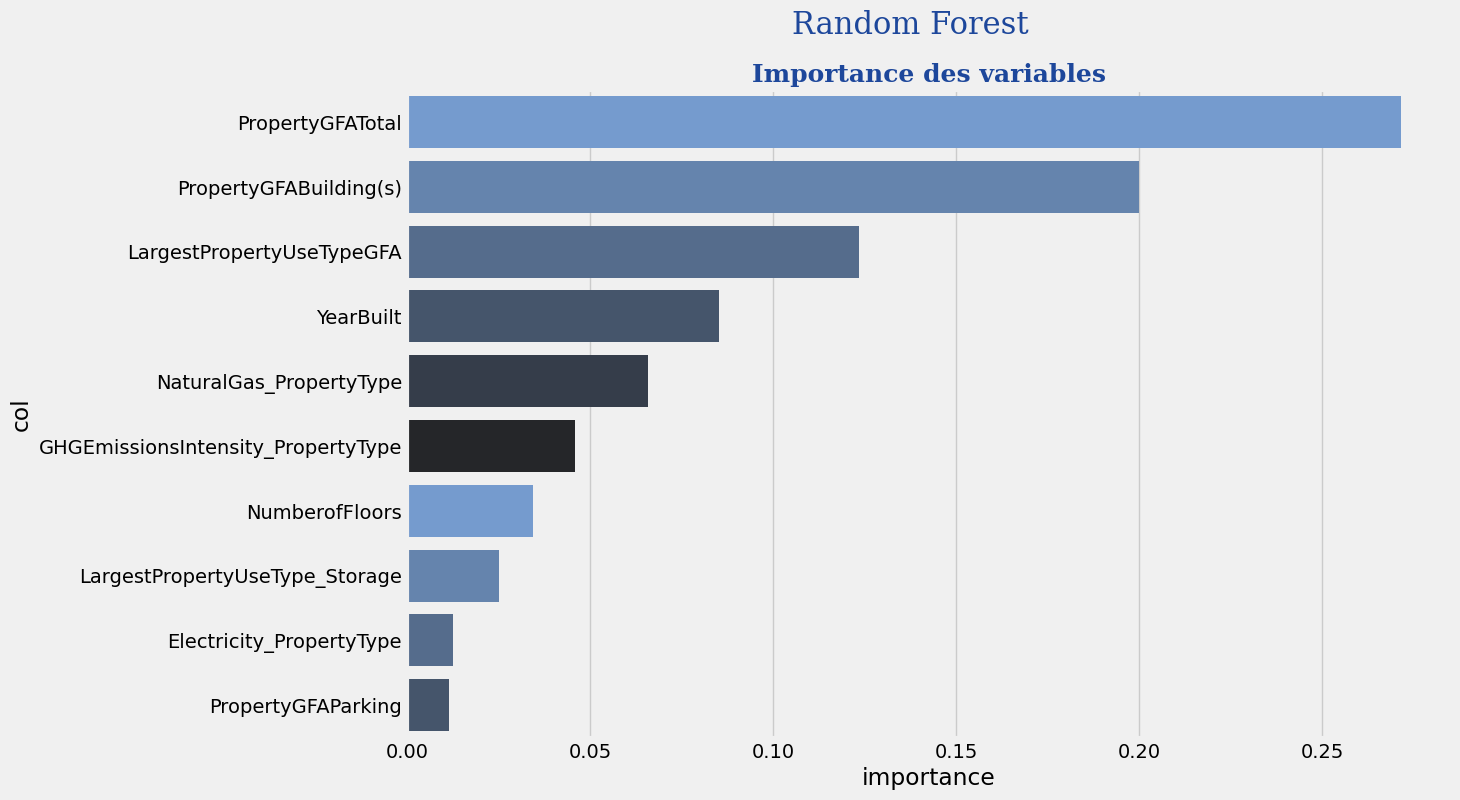

In [15]:
rfe_gh = RandomForestRegressor(max_features='auto', n_estimators= 420, max_leaf_nodes=900 , max_depth=140)
rfe_gh.fit(X_train, y_train_gh)

to_disp = pd.DataFrame().from_dict({'col':X_train.columns, 'importance':rfe_gh.feature_importances_}).sort_values(by='importance',ascending=False).head(10)
sns.barplot(x=to_disp.importance,y=to_disp.col, palette=sns.dark_palette("#69d", reverse=True), )
plt.suptitle('Random Forest', fontsize=22, fontdict=font_title)
plt.title('Importance des variables', fontsize=18, fontdict=font_title)
plt.show()

#### XGBoost

In [40]:
%%time
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

param_grid = {
    'max_depth': [8,16,32], # Max_depth of the trees
    'n_estimators': np.arange(1,800,5), # Nb of trees
    'eta': np.arange(0.01,0.51, 0.01), # Learning rate of our XGBoost trees
    'gamma': np.arange(1, 10, 1),# Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'lambda': np.arange(1, 100, 1) # L2 regularization
    }

scoring = {'MAE':'neg_mean_absolute_error',  "R2": 'r2'}

model_param_search_xg_gh = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=42), param_distributions=param_grid,
                                 n_jobs=-1, cv=5, n_iter=500, scoring=scoring, return_train_score=True, refit=False)

model_param_search_xg_gh.fit(X_train,y_train_gh)

Wall time: 32min 38s


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
       456, 461, 466, 471, 476, 481, 486, 491, 496, 501, 506, 511, 516,
       521, 526, 531, 536, 541, 546, 551, 556, 561, 566, 571, 576, 581,
       586, 591, 596, 601, 606, 611, 616, 621,

In [43]:
cv_results =  pd.DataFrame(model_param_search_xg_gh.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_depth', 'param_n_estimators', 'param_eta', 'param_gamma', 'param_lambda']].sort_values(by='mean_test_R2',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_MAE  mean_train_MAE  \
438      0.695174       0.928755      -0.566320       -0.291871   
23       0.681766       0.912586      -0.582660       -0.313278   
461      0.674383       0.912156      -0.589644       -0.315179   
402      0.673874       0.917552      -0.586325       -0.305092   
485      0.673081       0.899117      -0.593129       -0.338477   
166      0.668975       0.899753      -0.598621       -0.346496   
360      0.665734       0.899225      -0.600132       -0.336972   
331      0.661915       0.877250      -0.614198       -0.372377   
78       0.659408       0.906840      -0.611655       -0.323931   
148      0.659305       0.882624      -0.613037       -0.364323   

    param_max_depth param_n_estimators param_eta param_gamma param_lambda  
438              16                756      0.02           1            1  
23               32                141      0.12           1            7  
461              16                 56      0.24           1            4  
402              32                 41      0.37           1            8  
485              16                661      0.12           1            6  
166              32                 76      0.18           2            1  
360              32                186      0.25           1           13  
331              32                786      0.11           1           21  
78               32                661      0.49           1           11  
148              32                796      0.21           1           20

In [44]:
%%time

param_grid = {
    'max_depth': [32], # Max_depth of the trees
    'n_estimators': [60,65,70,75,80,85], # Nb of trees
    'eta': [0.16,0.20], # Learning rate of our XGBoost trees
    'gamma': np.arange(1,6,5),# Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'lambda': [1,2,3,4] # L2 regularization
    }

scoring = {'RMSE': 'neg_root_mean_squared_error', 'MAE':'neg_mean_absolute_error', "R2": 'r2'}

grid_xgb_gh = GridSearchCV(estimator=xgb.XGBRegressor(random_state=42), param_grid=param_grid,
                                 n_jobs=-1, cv=5, scoring=scoring, return_train_score=True, refit=False, verbose=3)

grid_xgb_gh.fit(X_train,y_train_gh)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Wall time: 1min 2s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=-1,
             param_grid={'eta': [0.16, 0.2], 'gamma': array(

In [45]:
cv_results =  pd.DataFrame(grid_xgb_gh.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_depth', 'param_n_estimators', 'param_eta', 'param_gamma', 'param_lambda']].sort_values(by='mean_test_R2',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_MAE  mean_train_MAE  \
24      0.702573       0.944662      -0.550166       -0.254361   
25      0.702573       0.944662      -0.550166       -0.254361   
27      0.702573       0.944662      -0.550166       -0.254361   
26      0.702573       0.944662      -0.550166       -0.254361   
28      0.702573       0.944662      -0.550166       -0.254361   
29      0.702573       0.944662      -0.550166       -0.254361   
11      0.700960       0.938278      -0.557011       -0.265701   
10      0.700960       0.938278      -0.557011       -0.265701   
9       0.700960       0.938278      -0.557011       -0.265700   
8       0.700959       0.938278      -0.557011       -0.265699   

   param_max_depth param_n_estimators param_eta param_gamma param_lambda  
24              32                 60       0.2           1            1  
25              32                 65       0.2           1            1  
27              32                 75       0.2           1            1  
26              32                 70       0.2           1            1  
28              32                 80       0.2           1            1  
29              32                 85       0.2           1            1  
11              32                 85      0.16           1            2  
10              32                 80      0.16           1            2  
9               32                 75      0.16           1            2  
8               32                 70      0.16           1            2

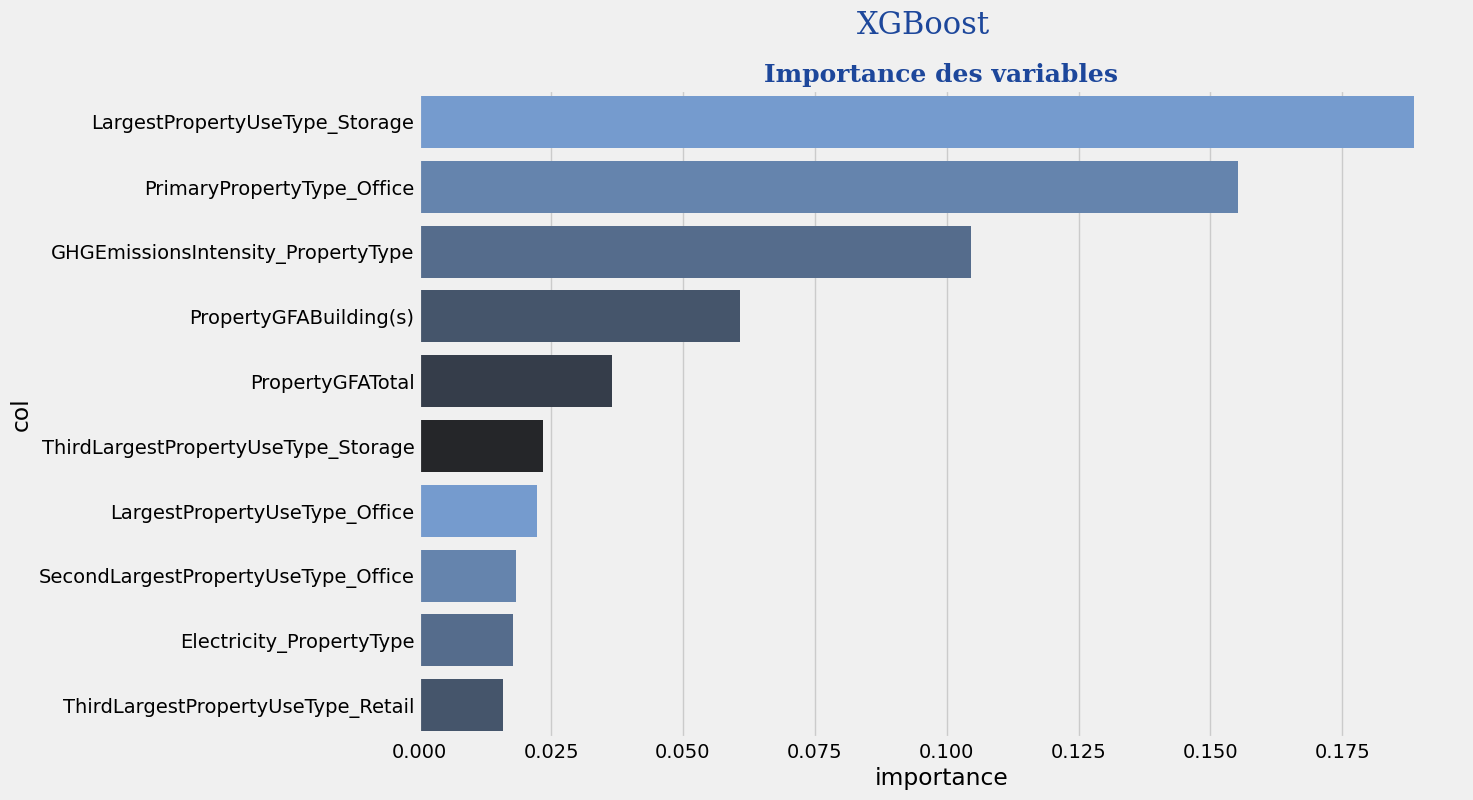

In [14]:
xgb_gh = xgb.XGBRegressor(random_state=42, max_depth=32, n_estimators=60, eta=0.2, gamma=1, reg_lambda=1)
xgb_gh.fit(X_train, y_train_gh)

to_disp = pd.DataFrame().from_dict({'col':X_train.columns, 'importance':xgb_gh.feature_importances_}).sort_values(by='importance',ascending=False).head(10)
sns.barplot(x=to_disp.importance,y=to_disp.col, palette=sns.dark_palette("#69d", reverse=True))
plt.suptitle('XGBoost', fontsize=22, fontdict=font_title)
plt.title('Importance des variables', fontsize=18, fontdict=font_title)
plt.show()

#### Conclusion quant au choix du modèle

In [16]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train_gh)

lin_m = linear_model.LinearRegression()
lin_m.fit(X_train, y_train_gh)

best_models_gh = {'DummyMean': dummy, 'Linear': lin_m, 'Ridge': grids_gh[0].best_estimator_, 'Lasso': grids_gh[1].best_estimator_, 'ElasticNet': grids_gh[2].best_estimator_, 'SVR': grids_gh[3].best_estimator_, 'RandomForest': rfe_gh, 'XGBoost': xgb_gh}

In [17]:
iterations = 300

dummy_start = time.time() 
for n in range(iterations):
    dummy.fit(X_train, y_train_gh)
dummy_time = (time.time() - dummy_start)/iterations 

lin_m_start = time.time() 
for n in range(iterations):
    lin_m.fit(X_train, y_train_gh)
lin_m_time = (time.time() - lin_m_start)/iterations 

fit_time_best_models_gh = {'DummyMean': dummy_time, 'Linear': lin_m_time, 'Ridge': grids_gh[0].cv_results_['mean_fit_time'].mean(), 'Lasso': grids_gh[1].cv_results_['mean_fit_time'].mean(), 'ElasticNet': grids_gh[2].cv_results_['mean_fit_time'].mean(), 'SVR': grids_gh[3].cv_results_['mean_fit_time'].mean(), 'RandomForest': grid_rf_gh.cv_results_['mean_fit_time'].mean(), 'XGBoost': grid_xgb_gh.cv_results_['mean_fit_time'].mean()}

#### Sauvegarde des grids/modèles

In [51]:
# Ridge, Lasso, Elastic, SVR
pickle_out = open('.models_saved/grids_gh.pickle', 'wb')
pickle.dump(grids_gh, pickle_out)
pickle_out.close()

# RF
# Randomized
pickle_out = open('.models_saved/model_param_search_gh.pickle', 'wb')
pickle.dump(model_param_search_gh, pickle_out)
pickle_out.close()

pickle_out = open('.models_saved/grid_rf_gh.pickle', 'wb')
pickle.dump(grid_rf_gh, pickle_out)
pickle_out.close()

# XGB
# Randomized
pickle_out = open('.models_saved/model_param_search_xg_gh.pickle', 'wb')
pickle.dump(model_param_search_xg_gh, pickle_out)
pickle_out.close()

pickle_out = open('.models_saved/grid_xgb_gh.pickle', 'wb')
pickle.dump(grid_xgb_gh, pickle_out)
pickle_out.close()

### SiteEnergyUse

#### Linear - Ridge - Lasso - Elastic - SVR

RIDGE - Meilleurs params: {'alpha': 4.095}
LASSO - Meilleurs params: {'alpha': 0.001}
Elastic - Meilleurs params: {'alpha': 0.001, 'l1_ratio': 0.2}
SVR - Meilleurs params: {'C': 10, 'epsilon': 0.325, 'gamma': 0.012}


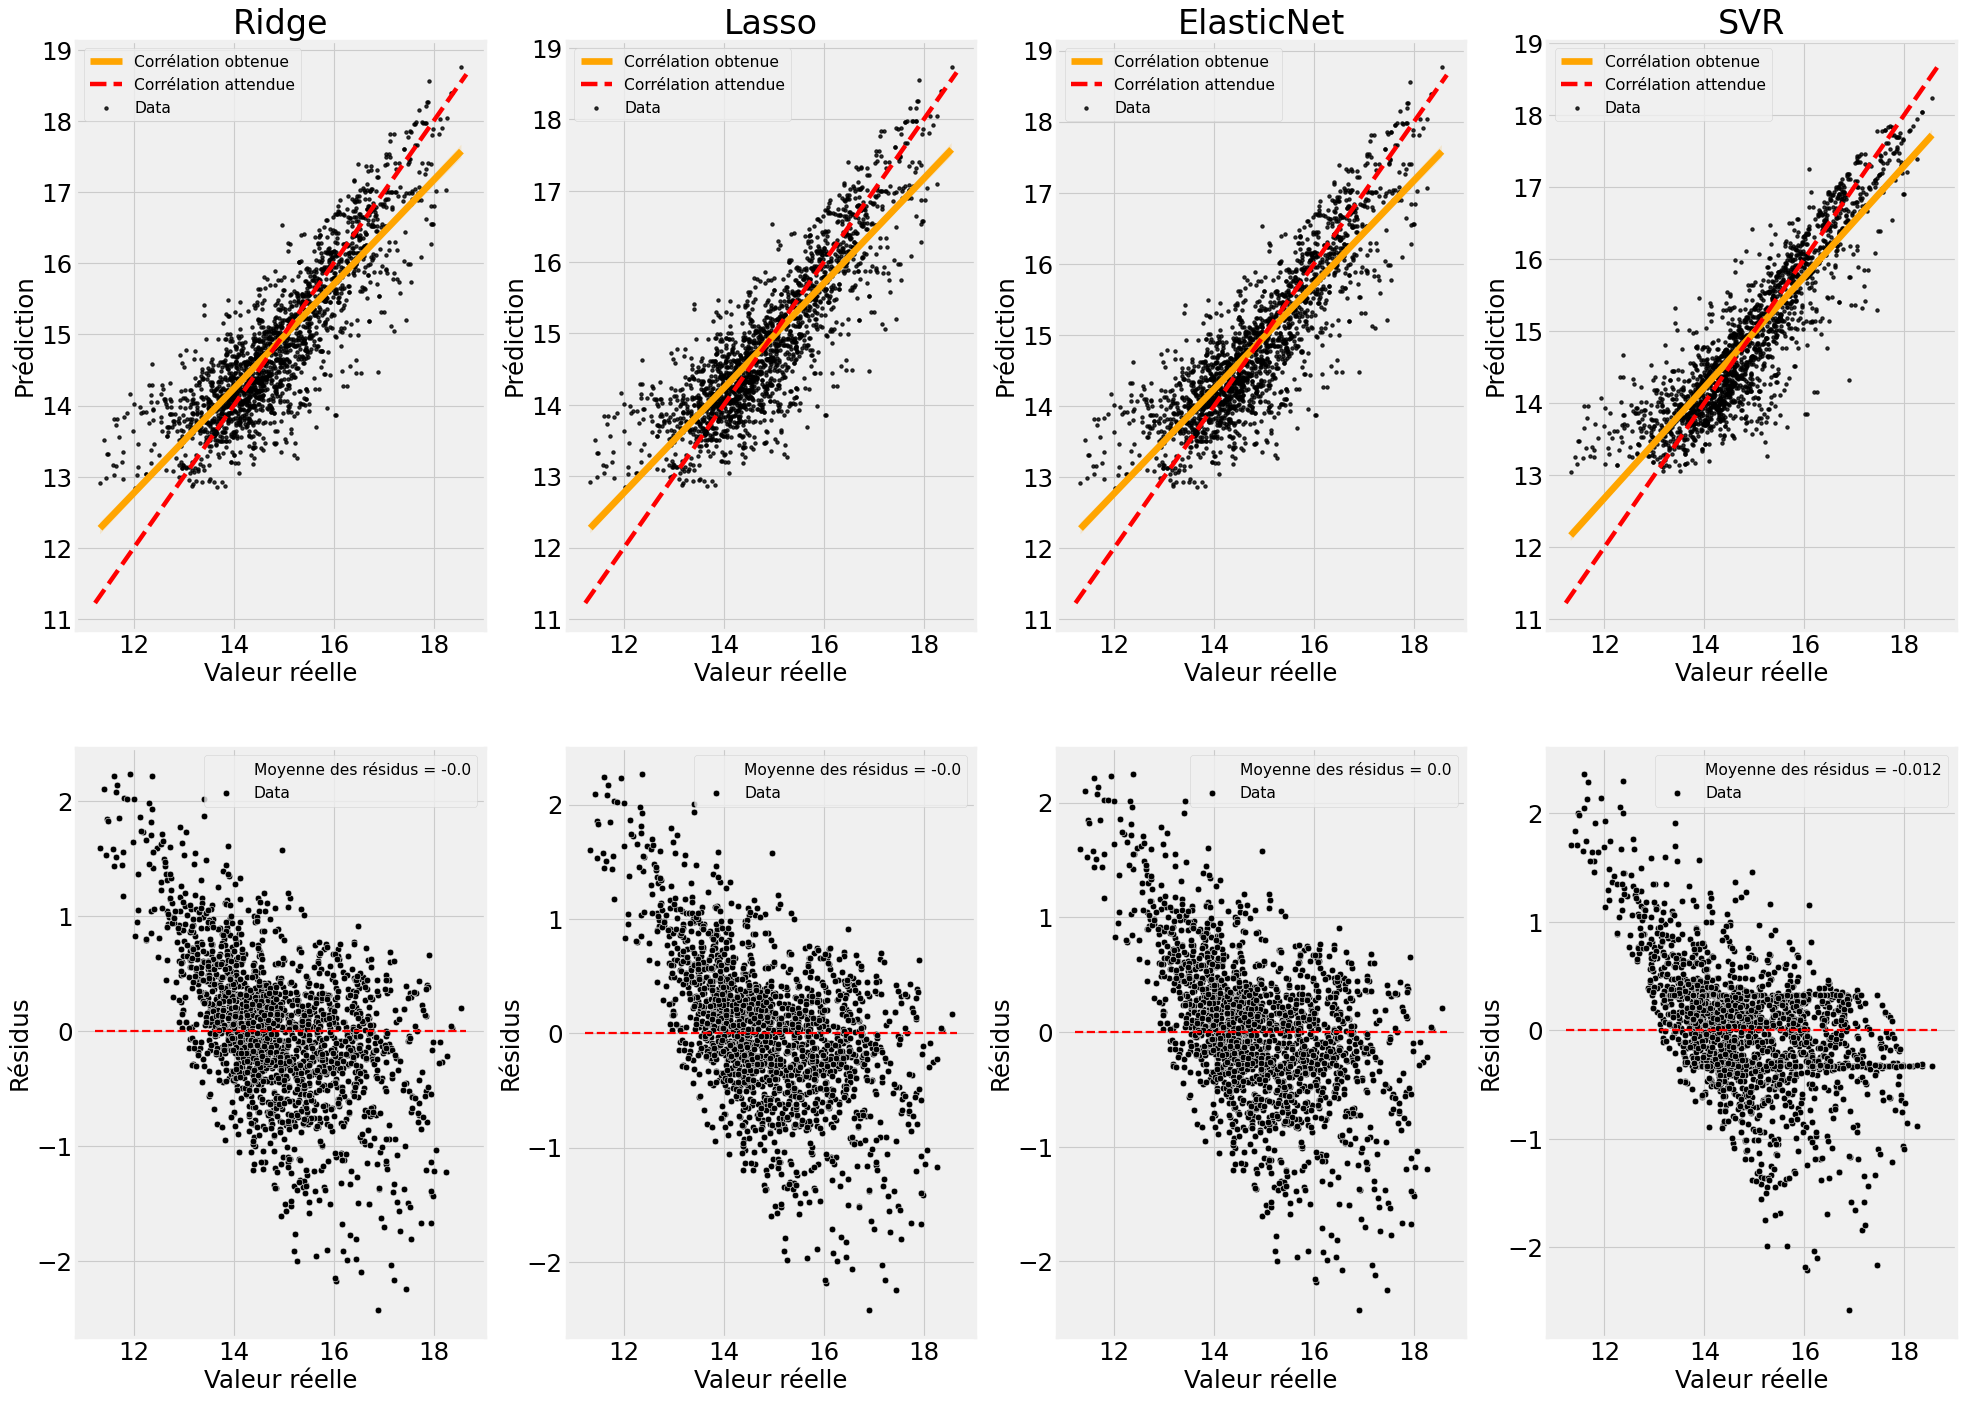

Wall time: 1min 10s


model target   RMSE    MSE    MAE     R2
0         DummyMean     EN -1.273 -1.625 -1.031 -0.006
0  LinearRegression     EN -0.671 -0.452 -0.508  0.719
0   RidgeRegression     EN -0.670 -0.450 -0.505  0.721
0   LassoRegression     EN -0.670 -0.451 -0.505  0.721
0       Elastic-net     EN -0.670 -0.450 -0.505  0.721
0               SVR     EN -0.651 -0.426 -0.482  0.735

In [20]:
%%time
r, grids_en = evaluate_estimators(X=X_train, y=y_train_en, name_target='EN', cv=5, random_state=42)
r

#### Random Forest

In [21]:
%%time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

param_grid = {
    'n_estimators': np.arange(1, 800, 1), # Nombre d'arbres dans notre forêt
    'max_leaf_nodes': np.arange(1, 1200, 1), # Le nombre max de feuilles par arbres
    'max_depth': np.arange(1, 200, 1), # La profondeur maximale d'un arbre
    'max_features' : ['auto', 'sqrt', 'log2'], # Le nombre de features à regarder pour construire un arbre
    }

scoring = {'MAE':'neg_mean_absolute_error',  "R2": 'r2'}

model_param_search_en = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), param_distributions=param_grid,
                                 n_jobs=-1, cv=5, n_iter=600, scoring=scoring, return_train_score=True, refit=False)

model_param_search_en.fit(X_train, y_train_en)

Wall time: 9min 58s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=600, n_jobs=-1,
                   param_distributions={'max_depth': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,...
       729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741,
       742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754,
       755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767,
       768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780,
       781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793,
       794, 795, 796, 797, 798, 799])},
          

In [52]:
cv_results =  pd.DataFrame(model_param_search_en.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_features', 'param_n_estimators', 'param_max_leaf_nodes', 'param_max_depth']].sort_values(by='mean_test_MAE', ascending=False).head(15)

mean_test_R2  mean_train_R2  mean_test_MAE  mean_train_MAE  \
105      0.813162       0.971104      -0.372754       -0.145721   
155      0.813162       0.971104      -0.372754       -0.145721   
577      0.812959       0.971111      -0.373029       -0.145779   
486      0.812562       0.971013      -0.373062       -0.146022   
410      0.812874       0.971032      -0.373071       -0.145993   
205      0.812874       0.971032      -0.373071       -0.145993   
393      0.813070       0.971115      -0.373085       -0.145772   
167      0.812914       0.971073      -0.373092       -0.145999   
438      0.812896       0.971050      -0.373095       -0.145948   
246      0.813052       0.971112      -0.373098       -0.145777   
26       0.812945       0.971124      -0.373133       -0.145755   
558      0.812849       0.971040      -0.373141       -0.145968   
552      0.812816       0.971037      -0.373145       -0.145986   
47       0.812922       0.971119      -0.373163       -0.145758   
191      0.812530       0.971045      -0.373173       -0.146035   

    param_max_features param_n_estimators param_max_leaf_nodes param_max_depth  
105               auto                796                 1100              65  
155               auto                796                 1093             181  
577               auto                763                  739             155  
486               auto                462                  823             189  
410               auto                630                  999             176  
205               auto                630                  983             192  
393               auto                716                 1011             175  
167               auto                757                  690              84  
438               auto                648                  849              34  
246               auto                720                  932             187  
26                auto                732                  913             113  
558               auto                643                  935              98  
552               auto                636                 1041             184  
47                auto                741                  843              29  
191               auto                487                  973             115

In [54]:
%%time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit

param_grid = {
    'n_estimators': [440,450,460,470,480], # Nombre d'arbres dans notre forêt
    'max_leaf_nodes': [800,810,820,830,840], # Le nombre max de feuilles par arbres
    'max_depth': [170,180,190,200,210], # La profondeur maximale d'un arbre
    'max_features' : ['auto'], # Le nombre de features à regarder pour construire un arbre
    }

scoring = {'MAE':'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error', "R2": 'r2'}

grid_rf_en = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid,
                                 n_jobs=-1, cv=5, scoring=scoring, return_train_score=True, refit=False, verbose=True)

grid_rf_en.fit(X_train, y_train_en)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
Wall time: 5min 37s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [170, 180, 190, 200, 210],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [800, 810, 820, 830, 840],
                         'n_estimators': [440, 450, 460, 470, 480]},
             refit=False, return_train_score=True,
             scoring={'MAE': 'neg_mean_absolute_error',
                      'MSE': 'neg_mean_squared_error', 'R2': 'r2'},
             verbose=True)

In [55]:
cv_results =  pd.DataFrame(grid_rf_en.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MSE', 'mean_train_MSE', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_features', 'param_n_estimators', 'param_max_leaf_nodes', 'param_max_depth']].sort_values(by='mean_test_R2',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_MSE  mean_train_MSE  \
94       0.812574       0.971045      -0.303678       -0.046998   
44       0.812574       0.971045      -0.303678       -0.046998   
119      0.812574       0.971045      -0.303678       -0.046998   
19       0.812574       0.971045      -0.303678       -0.046998   
69       0.812574       0.971045      -0.303678       -0.046998   
99       0.812574       0.971045      -0.303678       -0.046998   
24       0.812574       0.971045      -0.303678       -0.046998   
74       0.812574       0.971045      -0.303678       -0.046998   
124      0.812574       0.971045      -0.303678       -0.046998   
49       0.812574       0.971045      -0.303678       -0.046998   

     mean_test_MAE  mean_train_MAE param_max_features param_n_estimators  \
94       -0.373118       -0.146050               auto                480   
44       -0.373118       -0.146050               auto                480   
119      -0.373118       -0.146050               auto                480   
19       -0.373118       -0.146050               auto                480   
69       -0.373118       -0.146050               auto                480   
99       -0.373119       -0.146049               auto                480   
24       -0.373119       -0.146049               auto                480   
74       -0.373119       -0.146049               auto                480   
124      -0.373119       -0.146049               auto                480   
49       -0.373119       -0.146049               auto                480   

    param_max_leaf_nodes param_max_depth  
94                   830             200  
44                   830             180  
119                  830             210  
19                   830             170  
69                   830             190  
99                   840             200  
24                   840             170  
74                   840             190  
124                  840             210  
49                   840             180

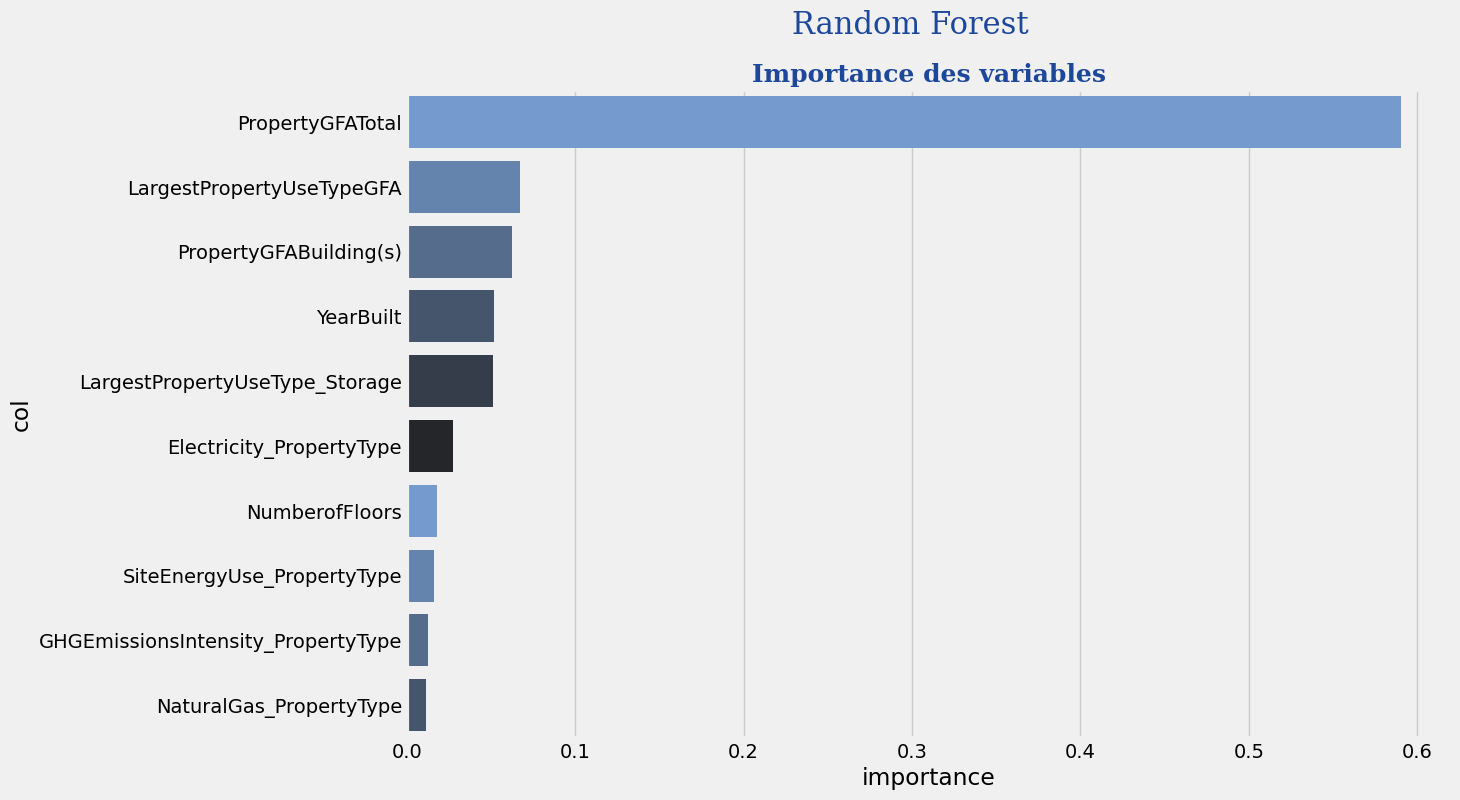

In [18]:
# Affichage importance features
rfe_en = RandomForestRegressor(max_features='auto', n_estimators=480, max_leaf_nodes=830, max_depth=170)
rfe_en.fit(X_train,y_train_en)

to_disp = pd.DataFrame().from_dict({'col':X_train.columns, 'importance':rfe_en.feature_importances_}).sort_values(by='importance',ascending=False).head(10)
sns.barplot(x=to_disp.importance,y=to_disp.col, palette=sns.dark_palette("#69d", reverse=True))
plt.suptitle('Random Forest', fontsize=22, fontdict=font_title)
plt.title('Importance des variables', fontsize=18, fontdict=font_title)
plt.show()

#### XGBoost

In [ ]:
%%time
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

param_grid = {
    'max_depth': [8,16,32], # Max_depth of the trees
    'n_estimators': np.arange(1,800,5), # Nb of trees
    'eta': np.arange(0.01,0.51, 0.01), # Learning rate of our XGBoost trees
    'gamma': np.arange(1, 10, 1),# Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'lambda': np.arange(1, 100, 1) # L2 regularization
    }


scoring = {'MAE':'neg_mean_absolute_error',  "R2": 'r2'}

model_param_search_xg_en = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=42), param_distributions=param_grid,
                                 n_jobs=-1, cv=5, n_iter=600, scoring=scoring, return_train_score=True, refit=False)

model_param_search_xg_en.fit(X_train,y_train_en)

In [53]:
cv_results =  pd.DataFrame(model_param_search_xg_en.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_depth', 'param_n_estimators', 'param_eta', 'param_gamma', 'param_lambda']].sort_values(by='mean_test_MAE',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_MAE  mean_train_MAE  \
302      0.795594       0.920063      -0.420172       -0.270499   
17       0.795885       0.922010      -0.420686       -0.271331   
141      0.784141       0.917791      -0.432590       -0.271531   
29       0.783757       0.909043      -0.433455       -0.288555   
401      0.779796       0.903509      -0.437810       -0.295170   
278      0.778916       0.898011      -0.440174       -0.302533   
358      0.779088       0.896886      -0.440247       -0.303633   
116      0.777766       0.879627      -0.444513       -0.329922   
398      0.772143       0.886016      -0.448610       -0.326103   
388      0.769053       0.867270      -0.454276       -0.344937   

    param_max_depth param_n_estimators param_eta param_gamma param_lambda  
302              32                691      0.03           1            3  
17               16                621      0.18           1            1  
141              32                281       0.3           1            7  
29               16                391      0.14           1            3  
401              32                 91      0.37           1           12  
278              32                206      0.16           1           14  
358              32                446      0.19           1           14  
116               8                731      0.25           1            2  
398              32                126      0.28           2            2  
388              16                491      0.04           1           19

In [59]:
%%time

param_grid = {
    'max_depth': [32], # Max_depth of the trees
    'n_estimators': [110,120,130,140,150], # Nb of trees
    'eta': [0.28], # Learning rate of our XGBoost trees
    'gamma': [1, 1.5, 2, 2.5],# Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'lambda': [1, 2, 3] # L2 regularization
    }

scoring = {'RMSE': 'neg_root_mean_squared_error', 'MAE':'neg_mean_absolute_error', "R2": 'r2'}

grid_xgb_en = GridSearchCV(estimator=xgb.XGBRegressor(random_state=42), param_grid=param_grid,
                                 n_jobs=-1, cv=5, scoring=scoring, return_train_score=True, refit=False, verbose=3)

grid_xgb_en.fit(X_train,y_train_en)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Wall time: 2min 28s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=-1,
             param_grid={'eta': [0.28], 'gamma': [1, 1.5, 2,

In [60]:
cv_results =  pd.DataFrame(grid_xgb_en.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_depth', 'param_n_estimators', 'param_eta', 'param_gamma', 'param_lambda']].sort_values(by='mean_test_R2',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_MAE  mean_train_MAE  \
11      0.796039       0.932680      -0.417026       -0.246715   
14      0.796039       0.932680      -0.417026       -0.246715   
13      0.796039       0.932680      -0.417026       -0.246715   
12      0.796039       0.932680      -0.417026       -0.246715   
10      0.796039       0.932680      -0.417026       -0.246715   
8       0.792057       0.934166      -0.414814       -0.246273   
5       0.792057       0.934166      -0.414814       -0.246273   
6       0.792057       0.934166      -0.414814       -0.246273   
7       0.792057       0.934166      -0.414814       -0.246273   
9       0.792057       0.934166      -0.414814       -0.246273   

   param_max_depth param_n_estimators param_eta param_gamma param_lambda  
11              32                120      0.28           1            3  
14              32                150      0.28           1            3  
13              32                140      0.28           1            3  
12              32                130      0.28           1            3  
10              32                110      0.28           1            3  
8               32                140      0.28           1            2  
5               32                110      0.28           1            2  
6               32                120      0.28           1            2  
7               32                130      0.28           1            2  
9               32                150      0.28           1            2

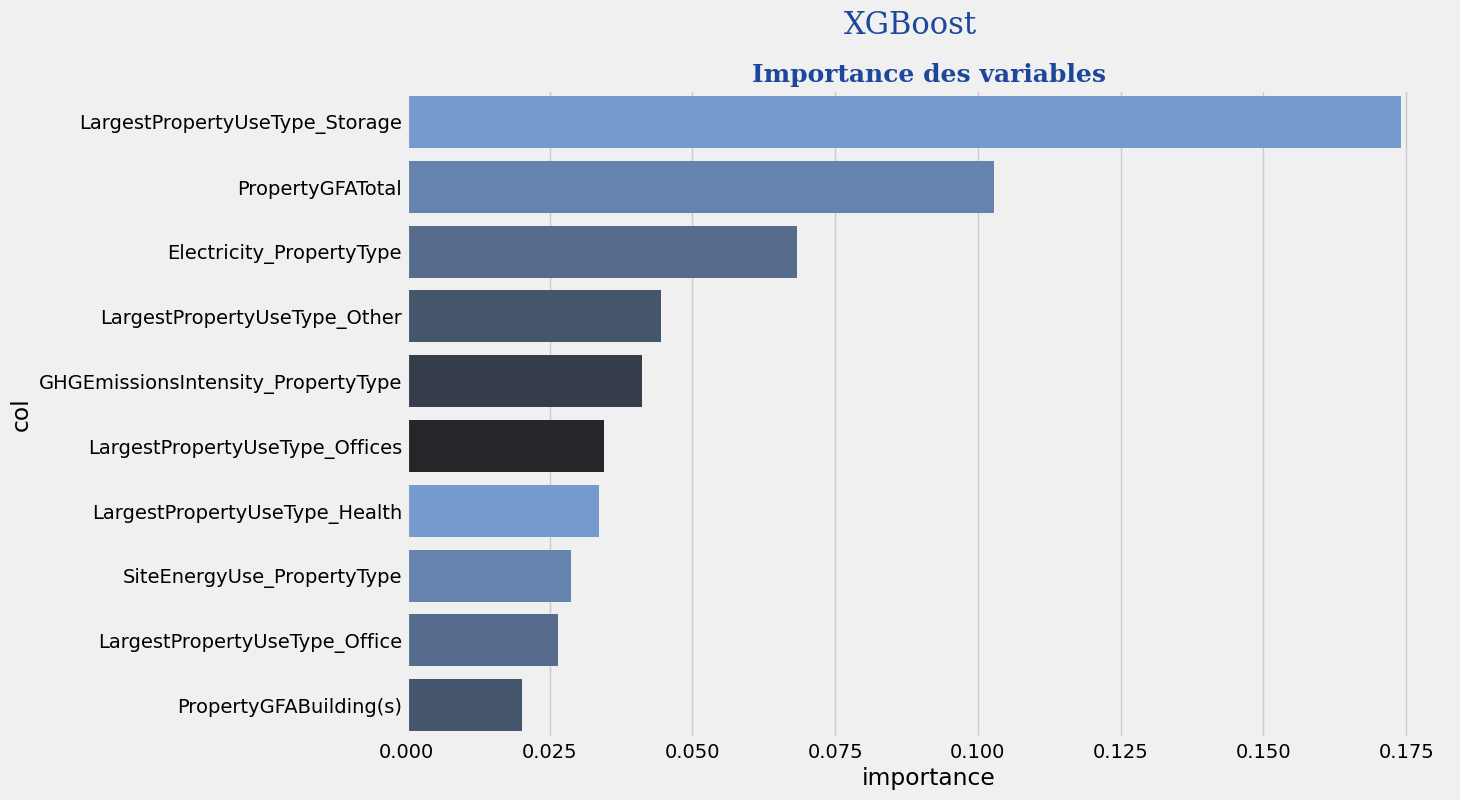

In [19]:
xgb_en = xgb.XGBRegressor(random_state=42, max_depth=32, n_estimators=110, eta=0.28, gamma=1, reg_lambda=3)
xgb_en.fit(X_train, y_train_en)

to_disp = pd.DataFrame().from_dict({'col':X_train.columns, 'importance':xgb_en.feature_importances_}).sort_values(by='importance',ascending=False).head(10)
sns.barplot(x=to_disp.importance,y=to_disp.col, palette=sns.dark_palette("#69d", reverse=True))
plt.suptitle('XGBoost', fontsize=22, fontdict=font_title)
plt.title('Importance des variables', fontsize=18, fontdict=font_title)
plt.show()

#### Conclusion quant au choix du modèle

In [20]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train_en)

lin_m = linear_model.LinearRegression()
lin_m.fit(X_train, y_train_en)

best_models_en = {'DummyMean': dummy, 'Linear': lin_m, 'Ridge': grids_en[0].best_estimator_, 'Lasso': grids_en[1].best_estimator_, 'ElasticNet': grids_en[2].best_estimator_, 'SVR': grids_en[3].best_estimator_,'RandomForest': rfe_en, 'XGBoost': xgb_en}

In [21]:
iterations = 500

dummy_start = time.time() 
for n in range(iterations):
    dummy.fit(X_train, y_train_en)
dummy_time = (time.time() - dummy_start)/iterations 

lin_m_start = time.time() 
for n in range(iterations):
    lin_m.fit(X_train, y_train_en)
lin_m_time = (time.time() - lin_m_start)/iterations 

fit_time_best_models_en = {'DummyMean': dummy_time, 'Linear': lin_m_time, 'Ridge': grids_en[0].cv_results_['mean_fit_time'].mean(), 'Lasso': grids_en[1].cv_results_['mean_fit_time'].mean(), 'ElasticNet': grids_en[2].cv_results_['mean_fit_time'].mean(), 'SVR': grids_en[3].cv_results_['mean_fit_time'].mean(), 'RandomForest': grid_rf_en.cv_results_['mean_fit_time'].mean(), 'XGBoost': grid_xgb_en.cv_results_['mean_fit_time'].mean()}

#### Sauvegarde des grids/modèles

In [64]:
# Ridge, Lasso, Elastic, SVR
pickle_out = open('.models_saved/grids_en.pickle', 'wb')
pickle.dump(grids_en, pickle_out)
pickle_out.close()

# RF
# Randomized
pickle_out = open('.models_saved/model_param_search_en.pickle', 'wb')
pickle.dump(model_param_search_en, pickle_out)
pickle_out.close()

pickle_out = open('.models_saved/grid_rf_en.pickle', 'wb')
pickle.dump(grid_rf_en, pickle_out)
pickle_out.close()

# XGB
# Randomized
pickle_out = open('.models_saved/model_param_search_xg_en.pickle', 'wb')
pickle.dump(model_param_search_xg_en, pickle_out)
pickle_out.close()

pickle_out = open('.models_saved/grid_xgb_en.pickle', 'wb')
pickle.dump(grid_xgb_en, pickle_out)
pickle_out.close()

## Intérêt de l'EnergyStarScore

In [27]:
y_train_gh_star, y_train_en_star, X_train_star, col_high_var_star = preproc(train, starscore=True)

scaler_train_star = StandardScaler() # (X-med)/ IQR
scaled_star = scaler_train_star.fit_transform(X_train_star.select_dtypes(exclude=['object', 'category', 'bool']))
X_train_star[X_train_star.select_dtypes(exclude=['object', 'category', 'bool']).columns] = scaled_star

X_train_star = add_proportion(X_train_star)

X_train_star = pd.get_dummies(X_train_star, columns=X_train_star.select_dtypes(['object', 'category']).columns)

X_train_star.shape

Suppression de 300 lignes.
Suppression des valeurs négatives et nulles... (3 valeurs supprimées)
Suppression  LargestPropertyUseTypeGFA > PropertyGFATotal... (162 valeurs supprimées)
Suppression multi-batiments... (5 valeurs supprimées)
log_GHG
Outliers inf: 0; Outliers sup: 3 
Outliers inf: 0; Outliers sup: 0 
log_EN
Outliers inf: 0; Outliers sup: 4 
Outliers inf: 0; Outliers sup: 0 
Suppression par z-score... (5 valeurs supprimées)
TOTAL: 175 valeurs aberrantes trouvées.
Passage au log de NumberofFloors
Passage au log de LargestPropertyUseTypeGFA
Passage au log de PropertyGFABuilding(s)
Passage au log de PropertyGFAParking
Passage au log de PropertyGFATotal
Passage au log de NumberofBuildings


(1250, 61)

Je vois que je perds environ 650 batiments en ajoutant l'EnergyStarScore

### Récupération des modèles précédemment entrainés

In [28]:
# Sauvegarde des modèles GHG

# Ridge, Lasso, Elastic, SVR
pickle_in = open('.models_saved/grids_gh_star.pickle', 'rb')
grids_gh_star = pickle.load(pickle_in)
pickle_in.close()

# RF
# RandomizedSearch
pickle_in = open('.models_saved/model_param_search_gh_star.pickle', 'rb')
model_param_search_gh_star = pickle.load(pickle_in)
pickle_in.close()

# GridSearch
pickle_in = open('.models_saved/grid_rf_gh_star.pickle', 'rb')
grid_rf_gh_star = pickle.load(pickle_in)
pickle_in.close()

# XGB
# Randomized
# pickle_in = open('.models_saved/model_param_search_xg_gh_star.pickle', 'rb')
# model_param_search_xg_gh_star = pickle.load(pickle_in)
# pickle_in.close()

# GridSearch
pickle_in = open('.models_saved/grid_xgb_gh_star.pickle', 'rb')
grid_xgb_gh_star = pickle.load(pickle_in)
pickle_in.close()

# Sauvegarde mes modèles EN

# Ridge, Lasso, Elastic, SVR
pickle_in = open('.models_saved/grids_en_star.pickle', 'rb')
grids_en_star = pickle.load(pickle_in)
pickle_in.close()

# RF
# RandomizedSearch
pickle_in = open('.models_saved/model_param_search_en_star.pickle', 'rb')
model_param_search_en_star = pickle.load(pickle_in)
pickle_in.close()

# GridSearch
pickle_in = open('.models_saved/grid_rf_en_star.pickle', 'rb')
grid_rf_en_star = pickle.load(pickle_in)
pickle_in.close()

# XGB
# Randomized
pickle_in = open('.models_saved/model_param_search_xg_en_star.pickle', 'rb')
model_param_search_xg_en_star = pickle.load(pickle_in)
pickle_in.close()

# GridSearch
pickle_in = open('.models_saved/grid_xgb_en_star.pickle', 'rb')
grid_xgb_en_star = pickle.load(pickle_in)
pickle_in.close()

### TotalGHGEmissions

#### Linear - Ridge - Lasso - Elastic - SVR

RIDGE - Meilleurs params: {'alpha': 4.095}
LASSO - Meilleurs params: {'alpha': 0.001}
Elastic - Meilleurs params: {'alpha': 0.004, 'l1_ratio': 0.0}
SVR - Meilleurs params: {'C': 10, 'epsilon': 0.55, 'gamma': 0.008}


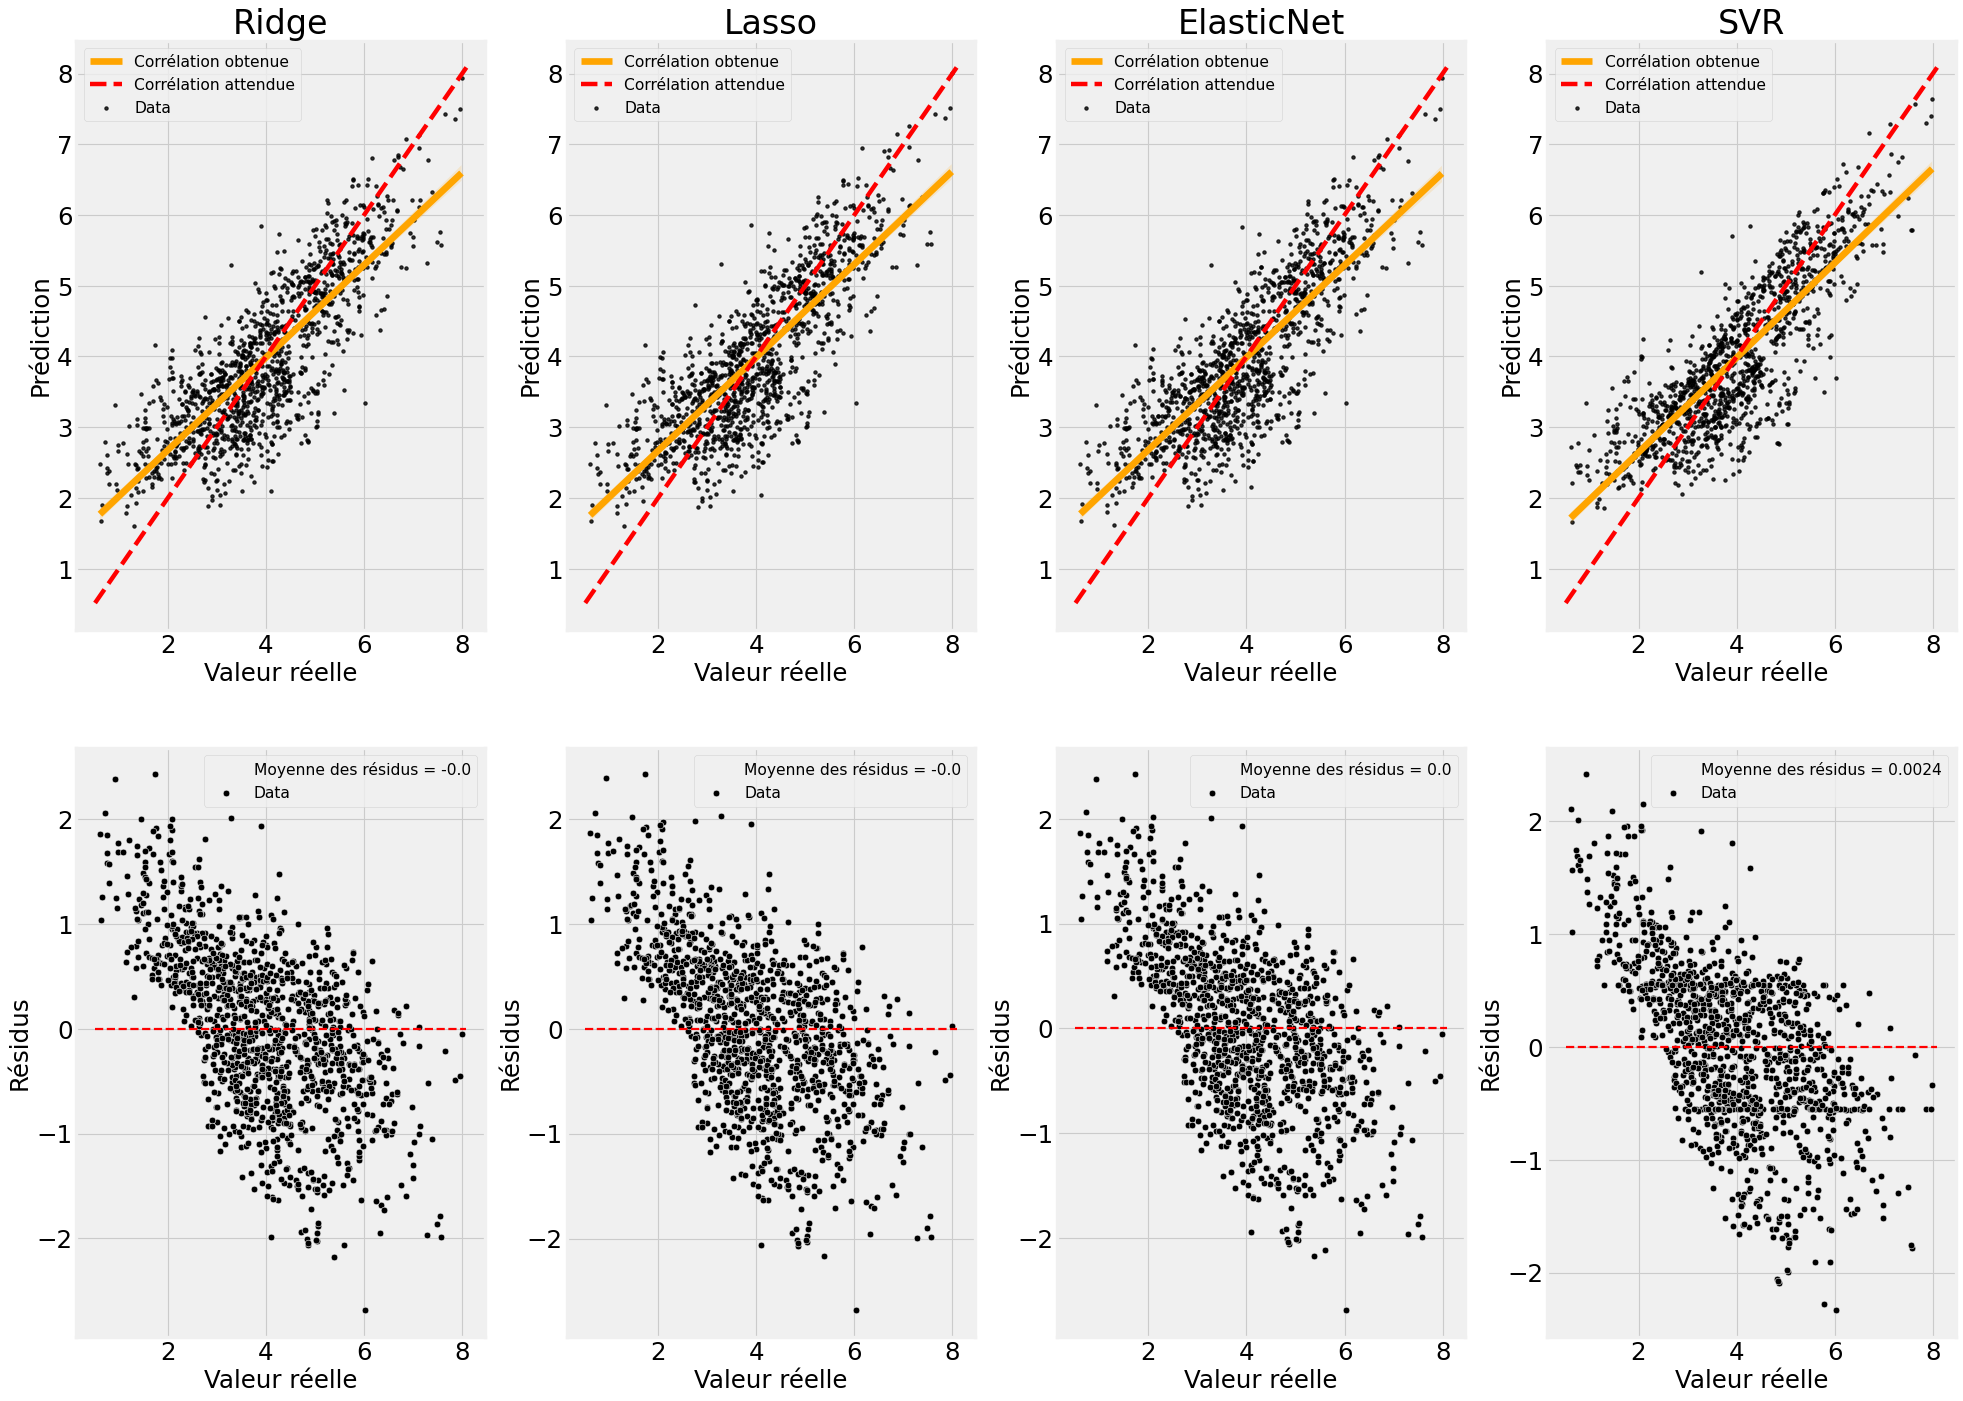

Wall time: 45.2 s


model target   RMSE    MSE    MAE     R2
0         DummyMean    GHG -1.348 -1.822 -1.090 -0.008
0  LinearRegression    GHG -0.815 -0.665 -0.650  0.630
0   RidgeRegression    GHG -0.811 -0.659 -0.650  0.633
0   LassoRegression    GHG -0.813 -0.662 -0.649  0.631
0       Elastic-net    GHG -0.811 -0.659 -0.650  0.633
0               SVR    GHG -0.806 -0.653 -0.646  0.636

In [26]:
%%time
r, grids_gh_star = evaluate_estimators(X=X_train_star, y=y_train_gh_star, name_target='GHG', cv=5, random_state=42)
r

#### Random Forest

In [27]:
%%time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

param_grid = {
    'n_estimators': np.arange(1, 800, 1), # Nombre d'arbres dans notre forêt
    'max_leaf_nodes': np.arange(1, 1200, 1), # Le nombre max de feuilles par arbres
    'max_depth': np.arange(1, 200, 1), # La profondeur maximale d'un arbre
    'max_features' : ['auto', 'sqrt', 'log2'], # Le nombre de features à regarder pour construire un arbre
    }

scoring = {'MAE':'neg_mean_absolute_error',  "R2": 'r2'}

model_param_search_gh_star = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), param_distributions=param_grid,
                                 n_jobs=-1, cv=10, n_iter=600, scoring=scoring, return_train_score=True, refit=False)

model_param_search_gh_star.fit(X_train_star,y_train_gh_star)

Wall time: 15min 40s


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_iter=600, n_jobs=-1,
                   param_distributions={'max_depth': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75...
       729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741,
       742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754,
       755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767,
       768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780,
       781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793,
       794, 795, 796, 797, 798, 799])},
          

In [77]:
cv_results =  pd.DataFrame(model_param_search_gh_star.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_features', 'param_n_estimators', 'param_max_leaf_nodes', 'param_max_depth']].sort_values(by='mean_test_MAE',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_MAE  mean_train_MAE  \
69       0.763252       0.967559      -0.480225       -0.179122   
175      0.763188       0.967603      -0.480334       -0.179039   
514      0.763249       0.967986      -0.480345       -0.178083   
567      0.762927       0.967994      -0.480352       -0.178074   
456      0.763198       0.967526      -0.480418       -0.179215   
289      0.763034       0.968000      -0.480432       -0.178063   
2        0.763226       0.967972      -0.480446       -0.178103   
355      0.762892       0.967733      -0.480471       -0.178768   
457      0.762962       0.967711      -0.480474       -0.178814   
527      0.762909       0.967970      -0.480513       -0.178135   

    param_max_features param_n_estimators param_max_leaf_nodes param_max_depth  
69                auto                339                  636              78  
175               auto                329                  874             115  
514               auto                726                  676             145  
567               auto                797                  823             179  
456               auto                343                  703              33  
289               auto                761                  709             132  
2                 auto                720                  797              90  
355               auto                459                  946             190  
457               auto                487                  968             191  
527               auto                767                 1134              42

In [78]:
%%time

param_grid = {
    'n_estimators': [320, 330, 340, 350, 360], # Nombre d'arbres dans notre forêt
    'max_leaf_nodes': [850,860,870,880,890], # Le nombre max de feuilles par arbres
    'max_depth': [100,110,120,130], # La profondeur maximale d'un arbre
    'max_features' : ['auto'], # Le nombre de features à regarder pour construire un arbre
    }

scoring = {'RMSE': 'neg_root_mean_squared_error', 'MAE':'neg_mean_absolute_error', "R2": 'r2'}

grid_rf_gh_star = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid,
                                 n_jobs=-1, cv=5, scoring=scoring, return_train_score=True, refit=False)

grid_rf_gh_star.fit(X_train_star, y_train_gh_star)

Wall time: 2min 6s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [100, 110, 120, 130],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [850, 860, 870, 880, 890],
                         'n_estimators': [320, 330, 340, 350, 360]},
             refit=False, return_train_score=True,
             scoring={'MAE': 'neg_mean_absolute_error', 'R2': 'r2',
                      'RMSE': 'neg_root_mean_squared_error'})

In [79]:
cv_results =  pd.DataFrame(grid_rf_gh_star.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_RMSE', 'mean_train_RMSE',  'mean_test_MAE', 'mean_train_MAE',
    'param_max_features', 'param_n_estimators', 'param_max_leaf_nodes', 'param_max_depth']].sort_values(by='mean_test_R2',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_RMSE  mean_train_RMSE  \
0       0.751942       0.965088       -0.669971        -0.251963   
20      0.751942       0.965088       -0.669971        -0.251963   
95      0.751942       0.965088       -0.669971        -0.251963   
90      0.751942       0.965088       -0.669971        -0.251963   
85      0.751942       0.965088       -0.669971        -0.251963   
80      0.751942       0.965088       -0.669971        -0.251963   
75      0.751942       0.965088       -0.669971        -0.251963   
70      0.751942       0.965088       -0.669971        -0.251963   
65      0.751942       0.965088       -0.669971        -0.251963   
60      0.751942       0.965088       -0.669971        -0.251963   

    mean_test_MAE  mean_train_MAE param_max_features param_n_estimators  \
0       -0.498702        -0.18746               auto                320   
20      -0.498702        -0.18746               auto                320   
95      -0.498702        -0.18746               auto                320   
90      -0.498702        -0.18746               auto                320   
85      -0.498702        -0.18746               auto                320   
80      -0.498702        -0.18746               auto                320   
75      -0.498702        -0.18746               auto                320   
70      -0.498702        -0.18746               auto                320   
65      -0.498702        -0.18746               auto                320   
60      -0.498702        -0.18746               auto                320   

   param_max_leaf_nodes param_max_depth  
0                   850             100  
20                  890             100  
95                  890             130  
90                  880             130  
85                  870             130  
80                  860             130  
75                  850             130  
70                  890             120  
65                  880             120  
60                  870             120

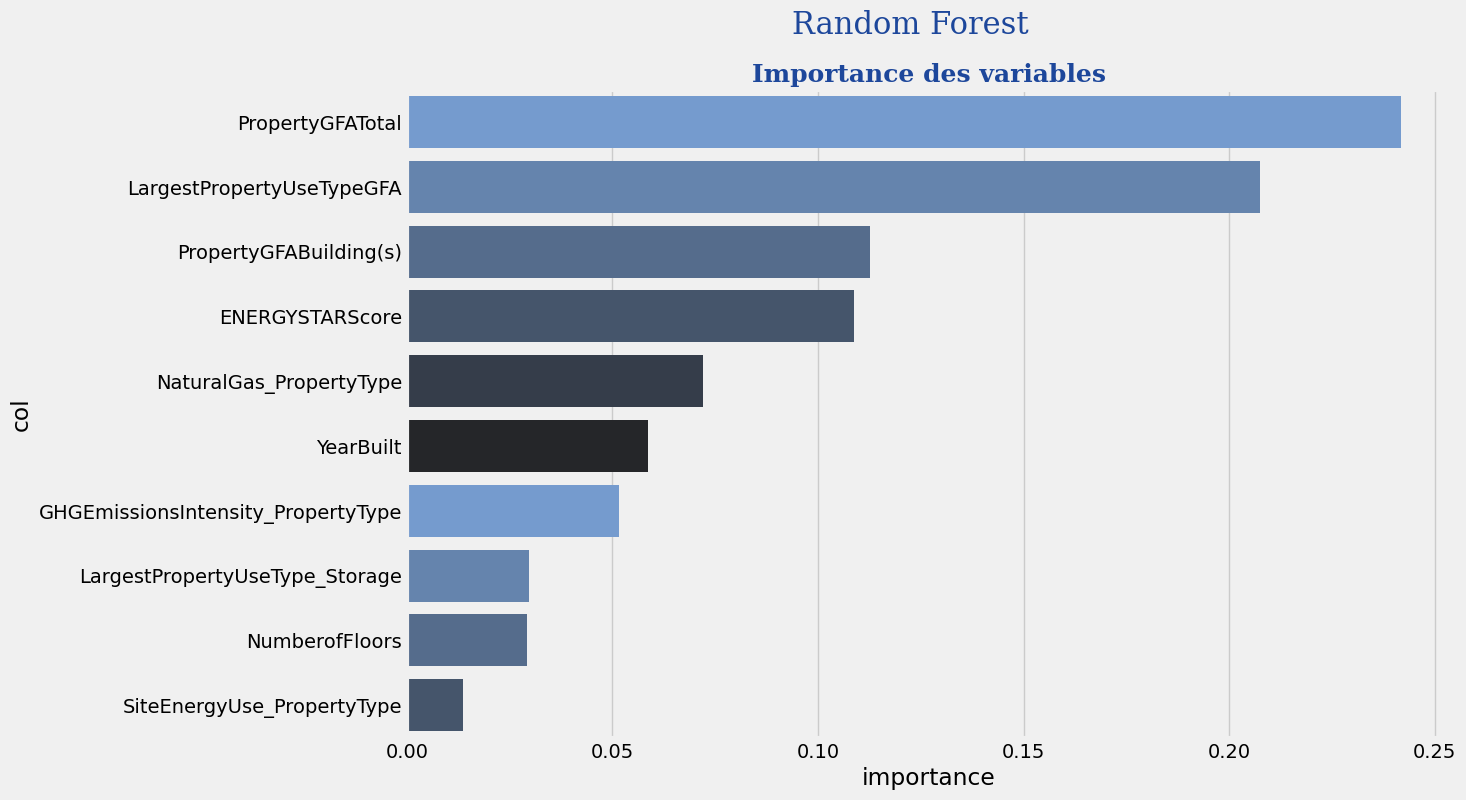

In [59]:
rfe_gh_star = RandomForestRegressor(max_features='auto', n_estimators=320, max_leaf_nodes=850, max_depth=100)
rfe_gh_star.fit(X_train_star, y_train_gh_star)

to_disp = pd.DataFrame().from_dict({'col':X_train_star.columns, 'importance':rfe_gh_star.feature_importances_}).sort_values(by='importance',ascending=False).head(10)
sns.barplot(x=to_disp.importance,y=to_disp.col, palette=sns.dark_palette("#69d", reverse=True))
plt.suptitle('Random Forest', fontsize=22, fontdict=font_title)
plt.title('Importance des variables', fontsize=18, fontdict=font_title)
plt.show()

#### XGBoost

In [28]:
%%time
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

param_grid = {
    'max_depth': [8,16,32], # Max_depth of the trees
    'n_estimators': np.arange(1,800,5), # Nb of trees
    'eta': np.arange(0.01,0.51, 0.01), # Learning rate of our XGBoost trees
    'gamma': np.linspace(1, 3, 100),# Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'lambda': np.arange(1, 100, 1) # L2 regularization
    }


scoring = {'MAE':'neg_mean_absolute_error',  "R2": 'r2'}

model_param_search_xg_gh_star = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=42), param_distributions=param_grid,
                                 n_jobs=-1, cv=5, n_iter=600, scoring=scoring, return_train_score=True, refit=False)

model_param_search_xg_gh_star.fit(X_train_star,y_train_gh_star)

Wall time: 26min 40s


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
       456, 461, 466, 471, 476, 481, 486, 491, 496, 501, 506, 511, 516,
       521, 526, 531, 536, 541, 546, 551, 556, 561, 566, 571, 576, 581,
       586, 591, 596, 601, 606, 611, 616, 621,

In [81]:
cv_results =  pd.DataFrame(model_param_search_xg_gh_star.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_depth', 'param_n_estimators', 'param_eta', 'param_gamma', 'param_lambda']].sort_values(by='mean_test_R2',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_MAE  mean_train_MAE  \
196      0.726751       0.921209      -0.534675       -0.295588   
541      0.725098       0.911339      -0.545104       -0.311236   
305      0.724236       0.902449      -0.548941       -0.328673   
486      0.717987       0.900935      -0.554580       -0.334345   
251      0.715987       0.879130      -0.555505       -0.367055   
217      0.715813       0.896010      -0.558375       -0.343893   
442      0.714101       0.897654      -0.557131       -0.341707   
422      0.711062       0.885614      -0.564480       -0.356730   
556      0.710826       0.942686      -0.534811       -0.252259   
107      0.709779       0.886517      -0.566352       -0.358356   

    param_max_depth param_n_estimators param_eta param_gamma param_lambda  
196              16                351      0.23    1.060606            5  
541              16                641      0.21    1.080808            8  
305              32                396      0.09     1.10101           11  
486              16                706      0.02    1.181818            6  
251              32                346      0.18    1.565657           10  
217              32                491      0.07    1.484848            5  
442               8                726      0.12     1.20202            2  
422              16                291      0.06    1.020202           18  
556              16                116      0.42     1.10101            1  
107              16                231      0.07    1.424242            7

In [83]:
%%time

param_grid = {
    'max_depth': [16, 32], # Max_depth of the trees
    'n_estimators': [100,110,120,130], # Nb of trees
    'eta': [0.40,0.45], # Learning rate of our XGBoost trees
    'gamma': [1,1.5,2],# Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'lambda': [1,2,3]# L2 regularization
    }

scoring = {'RMSE': 'neg_root_mean_squared_error', 'MAE':'neg_mean_absolute_error', "R2": 'r2'}

grid_xgb_gh_star = GridSearchCV(estimator=xgb.XGBRegressor(random_state=42), param_grid=param_grid,
                                 n_jobs=-1, cv=5, scoring=scoring, return_train_score=True, refit=False, verbose=3)

grid_xgb_gh_star.fit(X_train_star,y_train_gh_star)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Wall time: 3min


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=-1,
             param_grid={'eta': [0.4, 0.45], 'gamma': [1, 1.

In [84]:
cv_results =  pd.DataFrame(grid_xgb_gh_star.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_depth', 'param_n_estimators', 'param_eta', 'param_gamma', 'param_lambda']].sort_values(by='mean_test_R2',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_MAE  mean_train_MAE  \
23      0.717444       0.936532      -0.540707       -0.264154   
22      0.717444       0.936532      -0.540707       -0.264154   
21      0.717444       0.936532      -0.540707       -0.264154   
20      0.717444       0.936532      -0.540707       -0.264154   
4       0.715758       0.946399      -0.528234       -0.244629   
5       0.715758       0.946399      -0.528234       -0.244629   
6       0.715758       0.946399      -0.528234       -0.244629   
7       0.715758       0.946399      -0.528234       -0.244629   
1       0.714195       0.944421      -0.530863       -0.249700   
0       0.714195       0.944421      -0.530863       -0.249700   

   param_max_depth param_n_estimators param_eta param_gamma param_lambda  
23              32                130       0.4           1            3  
22              32                120       0.4           1            3  
21              32                110       0.4           1            3  
20              32                100       0.4           1            3  
4               32                100       0.4           1            1  
5               32                110       0.4           1            1  
6               32                120       0.4           1            1  
7               32                130       0.4           1            1  
1               16                110       0.4           1            1  
0               16                100       0.4           1            1

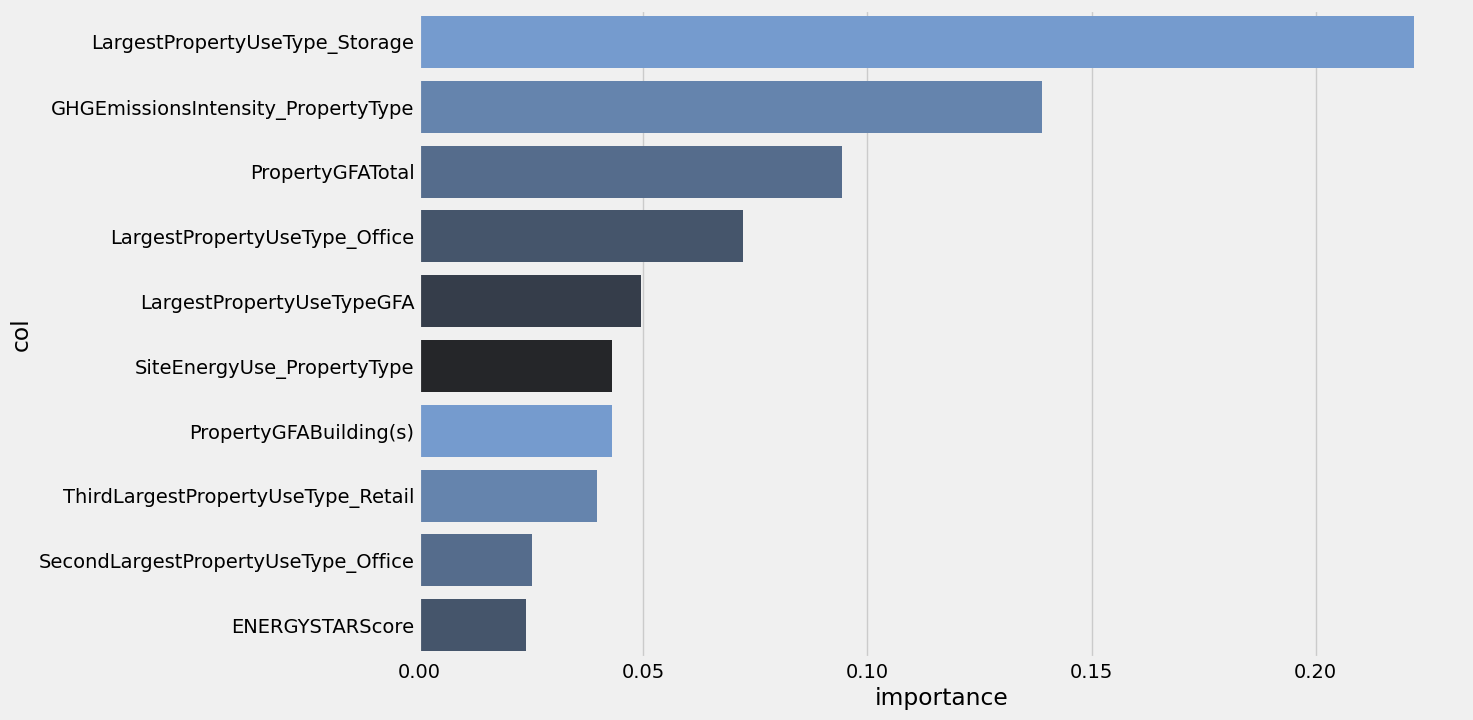

In [30]:
xgb_gh_star = xgb.XGBRegressor(random_state=42, max_depth=32, n_estimators=100, eta=0.4, gamma=1, reg_lambda=1)
xgb_gh_star.fit(X_train_star, y_train_gh_star)

to_disp = pd.DataFrame().from_dict({'col':X_train_star.columns, 'importance':xgb_gh_star.feature_importances_}).sort_values(by='importance',ascending=False).head(10)
sns.barplot(x=to_disp.importance,y=to_disp.col, palette=sns.dark_palette("#69d", reverse=True))

plt.show()

#### Conclusion quant au choix du modèle

In [60]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train_star, y_train_gh_star)

lin_m = linear_model.LinearRegression()
lin_m.fit(X_train_star, y_train_gh_star)

best_models_gh_star = {'DummyMean': dummy, 'Linear': lin_m, 'Ridge': grids_gh_star[0].best_estimator_, 'Lasso': grids_gh_star[1].best_estimator_, 'ElasticNet': grids_gh_star[2].best_estimator_, 'SVR': grids_gh_star[3].best_estimator_, 'RandomForest': rfe_gh_star, 'XGBoost': xgb_gh_star}

In [61]:
iterations = 500

dummy_start = time.time() 
for n in range(iterations):
    dummy.fit(X_train_star , y_train_gh_star )
dummy_time = (time.time() - dummy_start)/iterations 

lin_m_start = time.time() 
for n in range(iterations):
    lin_m.fit(X_train_star , y_train_gh_star )
lin_m_time = (time.time() - lin_m_start)/iterations 

fit_time_best_models_gh_star  = {'DummyMean': dummy_time, 'Linear': lin_m_time, 'Ridge': grids_gh_star[0].cv_results_['mean_fit_time'].mean(), 'Lasso': grids_gh_star[1].cv_results_['mean_fit_time'].mean(), 'ElasticNet': grids_gh_star[2].cv_results_['mean_fit_time'].mean(), 'SVR': grids_gh_star[3].cv_results_['mean_fit_time'].mean(), 'RandomForest': grid_rf_gh_star.cv_results_['mean_fit_time'].mean(), 'XGBoost': grid_xgb_gh_star.cv_results_['mean_fit_time'].mean()}

#### Sauvegarde des grids/modèles

In [88]:
# Ridge, Lasso, Elastic, SVR
pickle_out = open('.models_saved/grids_gh_star.pickle', 'wb')
pickle.dump(grids_gh_star, pickle_out)
pickle_out.close()

# RF
# Randomized
pickle_out = open('.models_saved/model_param_search_gh_star.pickle', 'wb')
pickle.dump(model_param_search_gh_star, pickle_out)
pickle_out.close()

pickle_out = open('.models_saved/grid_rf_gh_star.pickle', 'wb')
pickle.dump(grid_rf_gh_star, pickle_out)
pickle_out.close()

# XGB
# Randomized
pickle_out = open('.models_saved/model_param_search_xg_gh_star.pickle', 'wb')
pickle.dump(model_param_search_xg_gh_star, pickle_out)
pickle_out.close()

pickle_out = open('.models_saved/grid_xgb_gh_star.pickle', 'wb')
pickle.dump(grid_xgb_gh_star, pickle_out)
pickle_out.close()

### SiteEnergyUse

#### Linear - Ridge - Lasso - Elastic - SVR

RIDGE - Meilleurs params: {'alpha': 4.095}
LASSO - Meilleurs params: {'alpha': 0.001}
Elastic - Meilleurs params: {'alpha': 0.002, 'l1_ratio': 0.0}
SVR - Meilleurs params: {'C': 10, 'epsilon': 0.1, 'gamma': 0.008}


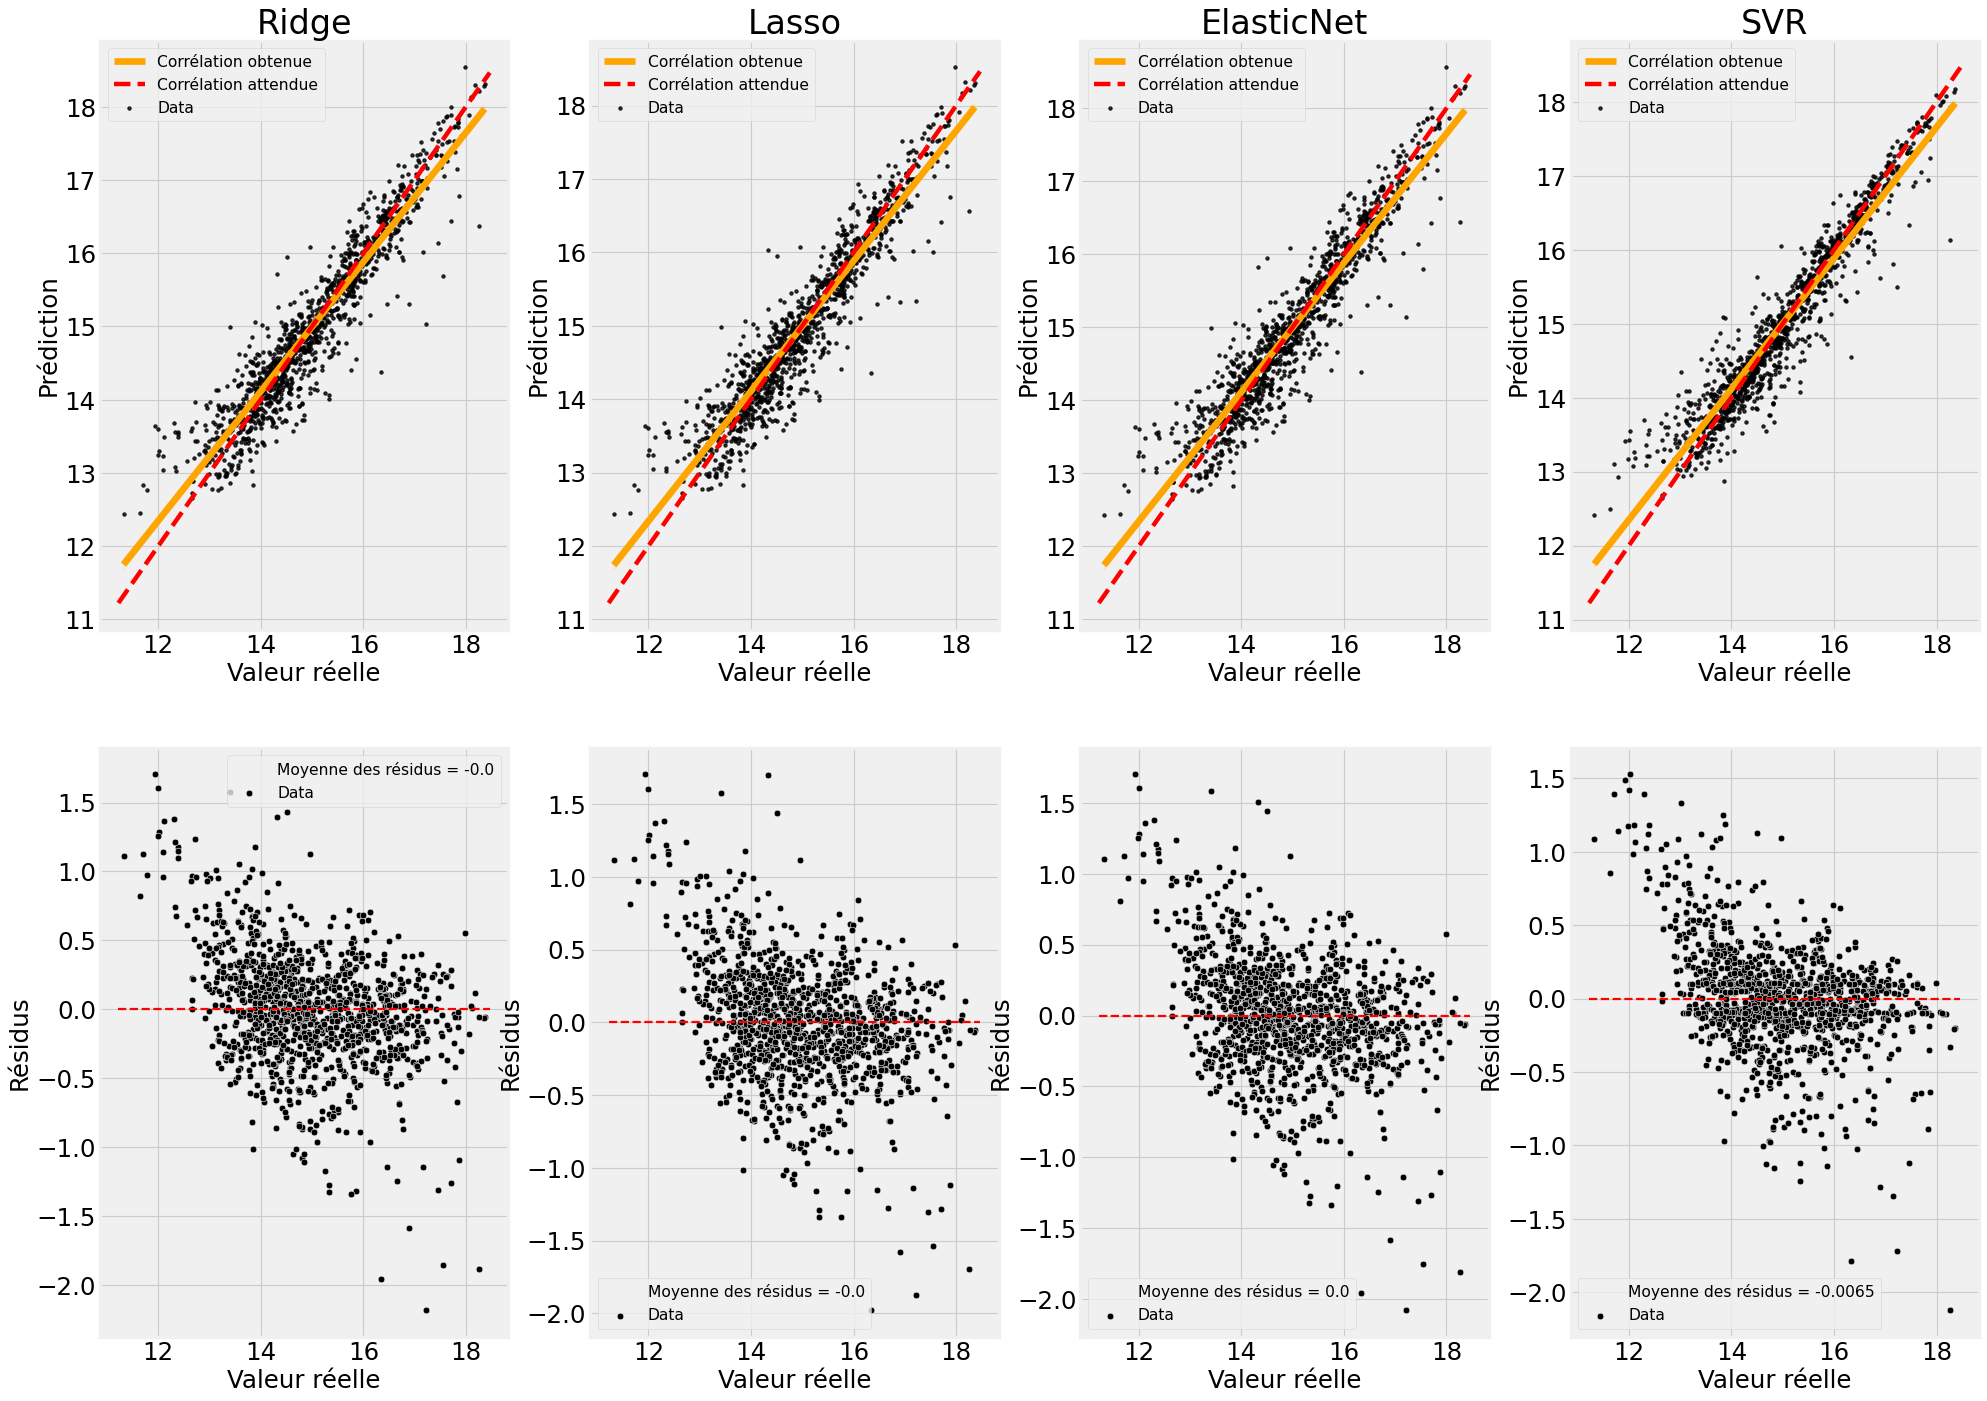

Wall time: 43.9 s


model target   RMSE    MSE    MAE     R2
0         DummyMean     EN -1.239 -1.537 -1.020 -0.008
0  LinearRegression     EN -0.434 -0.190 -0.308  0.875
0   RidgeRegression     EN -0.430 -0.186 -0.306  0.878
0   LassoRegression     EN -0.432 -0.188 -0.307  0.877
0       Elastic-net     EN -0.429 -0.186 -0.306  0.878
0               SVR     EN -0.422 -0.179 -0.294  0.882

In [29]:
%%time
r, grids_en_star = evaluate_estimators(X=X_train_star, y=y_train_en_star, name_target='EN', cv=5, random_state=42)
r

#### Random Forest

In [30]:
%%time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

param_grid = {
    'n_estimators': np.arange(1, 800, 1), # Nombre d'arbres dans notre forêt
    'max_leaf_nodes': np.arange(1, 1200, 1), # Le nombre max de feuilles par arbres
    'max_depth': np.arange(1, 200, 1), # La profondeur maximale d'un arbre
    'max_features' : ['auto', 'sqrt', 'log2'], # Le nombre de features à regarder pour construire un arbre
    }

scoring = {'MAE':'neg_mean_absolute_error',  "R2": 'r2'}

model_param_search_en_star = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), param_distributions=param_grid,
                                 n_jobs=-1, cv=10, n_iter=600, scoring=scoring, return_train_score=True, refit=False)

model_param_search_en_star.fit(X_train_star, y_train_en_star)

Wall time: 14min 43s


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_iter=600, n_jobs=-1,
                   param_distributions={'max_depth': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75...
       729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741,
       742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754,
       755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767,
       768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780,
       781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793,
       794, 795, 796, 797, 798, 799])},
          

In [89]:
cv_results =  pd.DataFrame(model_param_search_en_star.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_features', 'param_n_estimators', 'param_max_leaf_nodes', 'param_max_depth']].sort_values(by='mean_test_R2', ascending=False).head(15)

mean_test_R2  mean_train_R2  mean_test_MAE  mean_train_MAE  \
3        0.911648       0.987422      -0.233035       -0.087663   
495      0.911648       0.987422      -0.233035       -0.087663   
211      0.911646       0.987429      -0.233094       -0.087719   
282      0.911641       0.987439      -0.233070       -0.087627   
461      0.911632       0.987410      -0.233154       -0.087582   
571      0.911631       0.987426      -0.233041       -0.087696   
425      0.911627       0.987408      -0.233045       -0.087725   
222      0.911619       0.987414      -0.233217       -0.087591   
251      0.911594       0.987401      -0.233163       -0.087702   
28       0.911593       0.987418      -0.233167       -0.087803   
243      0.911582       0.987124      -0.233029       -0.088367   
273      0.911575       0.987391      -0.233150       -0.087698   
489      0.911572       0.986938      -0.233699       -0.090065   
163      0.911566       0.987319      -0.233263       -0.088635   
500      0.911566       0.987131      -0.233160       -0.088094   

    param_max_features param_n_estimators param_max_leaf_nodes param_max_depth  
3                 auto                333                  862             161  
495               auto                333                 1003              67  
211               auto                325                 1197             160  
282               auto                369                  871              77  
461               auto                395                  921             111  
571               auto                360                  633             152  
425               auto                346                 1060              66  
222               auto                399                 1073              44  
251               auto                380                  704             109  
28                auto                370                  575             139  
243               auto                159                  713              94  
273               auto                382                  777             199  
489               auto                175                  435             111  
163               auto                349                  485             194  
500               auto                190                  981              48

In [90]:
%%time

param_grid = {
    'n_estimators': [150,160,170,180], # Nombre d'arbres dans notre forêt
    'max_leaf_nodes': [700,710,720,730], # Le nombre max de feuilles par arbres
    'max_depth': [70,80,90,100], # La profondeur maximale d'un arbre
    'max_features' : ['auto'], # Le nombre de features à regarder pour construire un arbre
    }

scoring = {'MAE':'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error', "R2": 'r2'}

grid_rf_en_star = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid,
                                 n_jobs=-1, cv=5, scoring=scoring, return_train_score=True, refit=False, verbose=True)

grid_rf_en_star.fit(X_train_star, y_train_en_star)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Wall time: 40.3 s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [70, 80, 90, 100],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [700, 710, 720, 730],
                         'n_estimators': [150, 160, 170, 180]},
             refit=False, return_train_score=True,
             scoring={'MAE': 'neg_mean_absolute_error',
                      'MSE': 'neg_mean_squared_error', 'R2': 'r2'},
             verbose=True)

In [91]:
cv_results =  pd.DataFrame(grid_rf_en_star.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MSE', 'mean_train_MSE', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_features', 'param_n_estimators', 'param_max_leaf_nodes', 'param_max_depth']].sort_values(by='mean_test_R2',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_MSE  mean_train_MSE  mean_test_MAE  \
0       0.906329       0.986259      -0.143668       -0.021093      -0.242475   
16      0.906329       0.986259      -0.143668       -0.021093      -0.242475   
60      0.906329       0.986259      -0.143668       -0.021093      -0.242475   
56      0.906329       0.986259      -0.143668       -0.021093      -0.242475   
52      0.906329       0.986259      -0.143668       -0.021093      -0.242475   
48      0.906329       0.986259      -0.143668       -0.021093      -0.242475   
44      0.906329       0.986259      -0.143668       -0.021093      -0.242475   
40      0.906329       0.986259      -0.143668       -0.021093      -0.242475   
36      0.906329       0.986259      -0.143668       -0.021093      -0.242475   
28      0.906329       0.986259      -0.143668       -0.021093      -0.242475   

    mean_train_MAE param_max_features param_n_estimators param_max_leaf_nodes  \
0        -0.092269               auto                150                  700   
16       -0.092269               auto                150                  700   
60       -0.092269               auto                150                  730   
56       -0.092269               auto                150                  720   
52       -0.092269               auto                150                  710   
48       -0.092269               auto                150                  700   
44       -0.092269               auto                150                  730   
40       -0.092269               auto                150                  720   
36       -0.092269               auto                150                  710   
28       -0.092269               auto                150                  730   

   param_max_depth  
0               70  
16              80  
60             100  
56             100  
52             100  
48             100  
44              90  
40              90  
36              90  
28              80

...

<AxesSubplot:xlabel='importance', ylabel='col'>

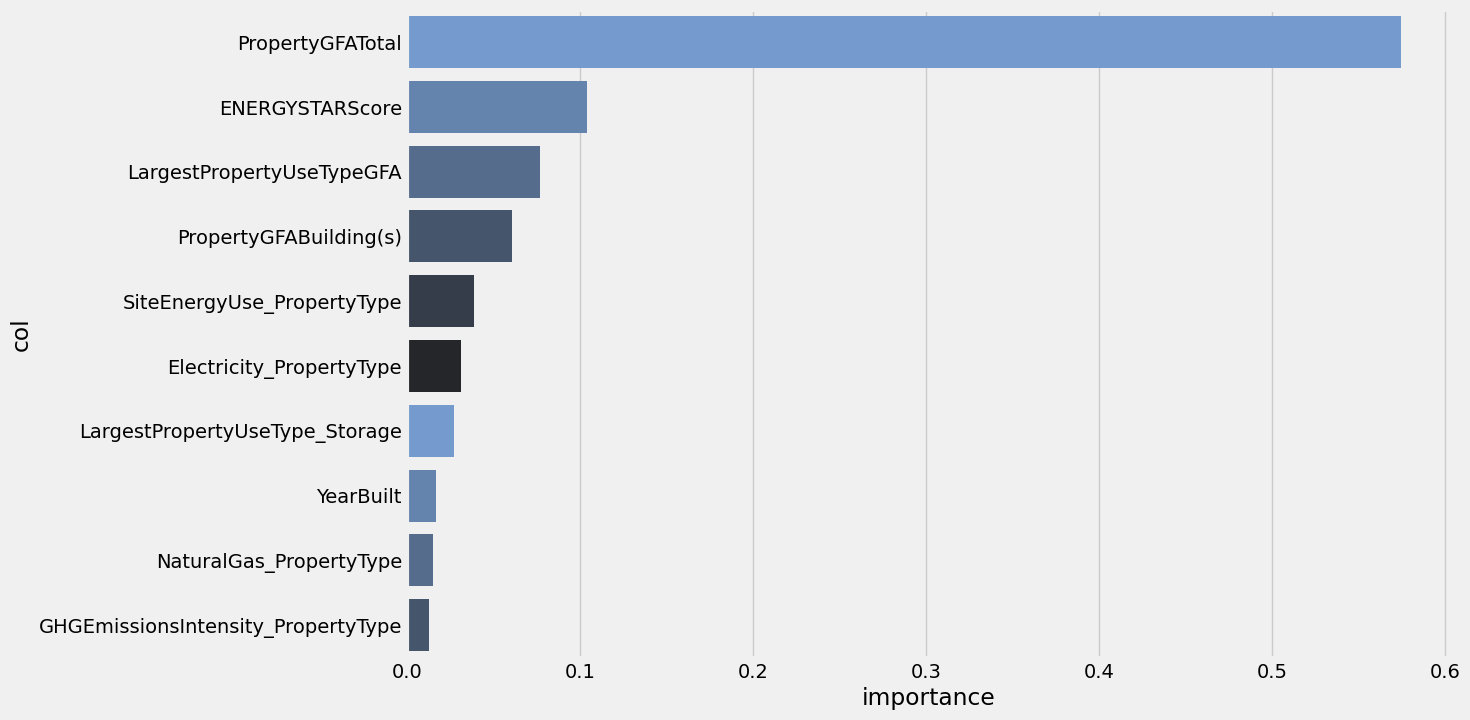

In [33]:
# Affichage importance features
rfe_en_star = RandomForestRegressor(max_features='auto', n_estimators=150, max_leaf_nodes=700, max_depth=70)
rfe_en_star.fit(X_train_star, y_train_en_star)

to_disp = pd.DataFrame().from_dict({'col':X_train_star.columns, 'importance':rfe_en_star.feature_importances_}).sort_values(by='importance',ascending=False).head(10)
sns.barplot(x=to_disp.importance,y=to_disp.col, palette=sns.dark_palette("#69d", reverse=True))

#### XGBoost

In [31]:
%%time
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

param_grid = {
    'max_depth': [8,16,32], # Max_depth of the trees
    'n_estimators': np.arange(1,800,5), # Nb of trees
    'eta': np.arange(0.01,0.51, 0.01), # Learning rate of our XGBoost trees
    'gamma': np.linspace(1, 3, 100),# Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'lambda': np.arange(1, 100, 1) # L2 regularization
    }


scoring = {'MAE':'neg_mean_absolute_error',  "R2": 'r2'}

model_param_search_xg_en_star = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=42), param_distributions=param_grid,
                                 n_jobs=-1, cv=5, n_iter=600, scoring=scoring, return_train_score=True, refit=False)

model_param_search_xg_en_star.fit(X_train_star,y_train_en_star)

Wall time: 22min 58s


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
       456, 461, 466, 471, 476, 481, 486, 491, 496, 501, 506, 511, 516,
       521, 526, 531, 536, 541, 546, 551, 556, 561, 566, 571, 576, 581,
       586, 591, 596, 601, 606, 611, 616, 621,

In [93]:
cv_results =  pd.DataFrame(model_param_search_xg_en_star.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_depth', 'param_n_estimators','param_eta', 'param_gamma', 'param_lambda']].sort_values(by='mean_test_R2',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_MAE  mean_train_MAE  \
531      0.890932       0.938715      -0.287616       -0.226231   
462      0.888653       0.938977      -0.292240       -0.224632   
414      0.886449       0.944621      -0.302277       -0.219388   
585      0.886327       0.930568      -0.292906       -0.236402   
171      0.884526       0.926461      -0.296698       -0.240883   
559      0.884517       0.928951      -0.296368       -0.242517   
50       0.883967       0.933199      -0.296987       -0.235865   
496      0.882862       0.942874      -0.304371       -0.224046   
536      0.881161       0.925233      -0.302089       -0.243642   
543      0.880707       0.925049      -0.301615       -0.242952   

    param_max_depth param_n_estimators param_eta param_gamma param_lambda  
531               8                321      0.12    1.020202            2  
462              16                131      0.15     1.10101            3  
414              16                186      0.39    1.222222            1  
585              16                431      0.04    1.060606            6  
171              16                691      0.11    1.020202           12  
559              32                716       0.1    1.484848            2  
50               32                776      0.19     1.30303            3  
496              16                186      0.42    1.262626            1  
536              32                 61      0.15     1.10101           11  
543              16                406      0.15    1.080808           12

In [94]:
%%time

param_grid = {
    'max_depth': [32], # Max_depth of the trees
    'n_estimators': [50,60,70,80,90], # Nb of trees
    'eta': [0.15], # Learning rate of our XGBoost trees
    'gamma': [1,1.5,2],# Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'lambda': [10,11,12,13] # L2 regularization
    }

scoring = {'RMSE': 'neg_root_mean_squared_error', 'MAE':'neg_mean_absolute_error', "R2": 'r2'}

grid_xgb_en_star = GridSearchCV(estimator=xgb.XGBRegressor(random_state=42), param_grid=param_grid,
                                 n_jobs=-1, cv=5, scoring=scoring, return_train_score=True, refit=False, verbose=3)

grid_xgb_en_star.fit(X_train_star,y_train_en_star)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Wall time: 32.3 s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=-1,
             param_grid={'eta': [0.15], 'gamma': [1, 1.5, 2]

In [95]:
cv_results =  pd.DataFrame(grid_xgb_en_star.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_depth', 'param_n_estimators', 'param_eta', 'param_gamma', 'param_lambda']].sort_values(by='mean_test_R2',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_MAE  mean_train_MAE  \
4       0.883262       0.929897      -0.296793       -0.235309   
3       0.883262       0.929897      -0.296792       -0.235307   
2       0.883261       0.929897      -0.296788       -0.235301   
9       0.883150       0.927778      -0.298472       -0.238763   
8       0.883150       0.927778      -0.298471       -0.238762   
7       0.883150       0.927778      -0.298466       -0.238755   
6       0.883145       0.927774      -0.298443       -0.238732   
1       0.882946       0.929606      -0.297212       -0.235702   
0       0.882790       0.929408      -0.297461       -0.235920   
14      0.882422       0.927043      -0.298895       -0.239320   

   param_max_depth param_n_estimators param_eta param_gamma param_lambda  
4               32                 90      0.15           1           10  
3               32                 80      0.15           1           10  
2               32                 70      0.15           1           10  
9               32                 90      0.15           1           11  
8               32                 80      0.15           1           11  
7               32                 70      0.15           1           11  
6               32                 60      0.15           1           11  
1               32                 60      0.15           1           10  
0               32                 50      0.15           1           10  
14              32                 90      0.15           1           12

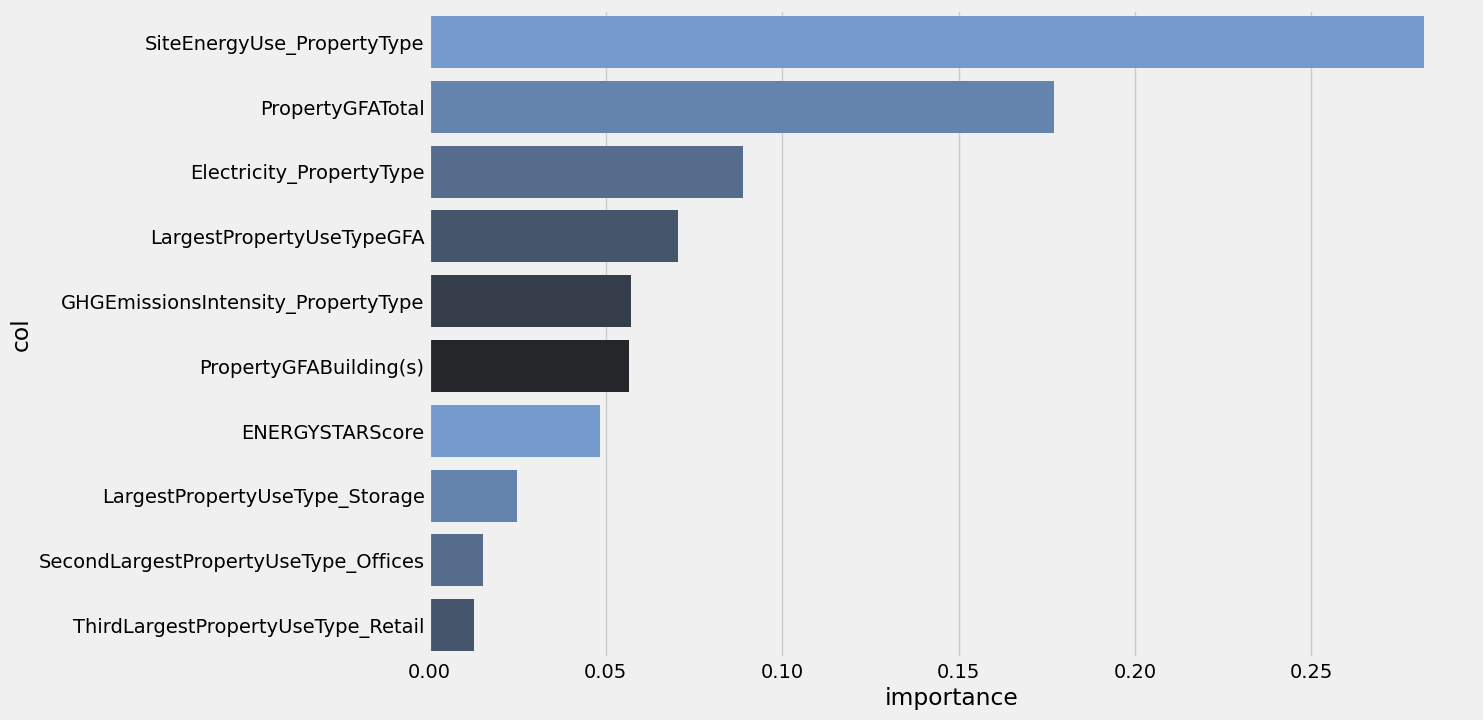

In [34]:
xgb_en_star = xgb.XGBRegressor(random_state=42, max_depth=32, n_estimators=70, eta=0.15, gamma=1, reg_lambda=10)
xgb_en_star.fit(X_train_star, y_train_en_star)

to_disp = pd.DataFrame().from_dict({'col':X_train_star.columns, 'importance':xgb_en_star.feature_importances_}).sort_values(by='importance',ascending=False).head(10)
sns.barplot(x=to_disp.importance,y=to_disp.col, palette=sns.dark_palette("#69d", reverse=True))

plt.show()

#### Conclusion quant au choix du modèle

In [35]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train_star, y_train_en_star)

lin_m = linear_model.LinearRegression()
lin_m.fit(X_train_star, y_train_en_star)

best_models_en_star = {'DummyMean': dummy, 'Linear': lin_m, 'Ridge': grids_en_star[0].best_estimator_, 'Lasso': grids_en_star[1].best_estimator_, 'ElasticNet': grids_en_star[2].best_estimator_, 'SVR': grids_en_star[3].best_estimator_, 'RandomForest': rfe_en_star, 'XGBoost': xgb_en_star}

In [36]:
iterations = 500

dummy_start = time.time() 
for n in range(iterations):
    dummy.fit(X_train_star , y_train_en_star )
dummy_time = (time.time() - dummy_start)/iterations 

lin_m_start = time.time() 
for n in range(iterations):
    lin_m.fit(X_train_star , y_train_en_star )
lin_m_time = (time.time() - lin_m_start)/iterations 

fit_time_best_models_en_star  = {'DummyMean': dummy_time, 'Linear': lin_m_time, 'Ridge': grids_en_star[0].cv_results_['mean_fit_time'].mean(), 'Lasso': grids_en_star[1].cv_results_['mean_fit_time'].mean(), 'ElasticNet': grids_en_star[2].cv_results_['mean_fit_time'].mean(), 'SVR': grids_en_star[3].cv_results_['mean_fit_time'].mean(), 'RandomForest': grid_rf_en_star.cv_results_['mean_fit_time'].mean(), 'XGBoost': grid_xgb_en_star.cv_results_['mean_fit_time'].mean()}

#### Sauvegarde des grids/modèles

In [99]:
# Ridge, Lasso, Elastic, SVR
pickle_out = open('.models_saved/grids_en_star.pickle', 'wb')
pickle.dump(grids_en_star, pickle_out)
pickle_out.close()

# RF
# Randomized
pickle_out = open('.models_saved/model_param_search_en_star.pickle', 'wb')
pickle.dump(model_param_search_en_star, pickle_out)
pickle_out.close()

pickle_out = open('.models_saved/grid_rf_en_star.pickle', 'wb')
pickle.dump(grid_rf_en_star, pickle_out)
pickle_out.close()

# XGB
# Randomized
pickle_out = open('.models_saved/model_param_search_xg_en_star.pickle', 'wb')
pickle.dump(model_param_search_xg_en_star, pickle_out)
pickle_out.close()

pickle_out = open('.models_saved/grid_xgb_en_star.pickle', 'wb')
pickle.dump(grid_xgb_en_star, pickle_out)
pickle_out.close()

# Tests

In [22]:
y_test_gh, y_test_en, X_test = preproc_test(test, col_high_var)

scaled = scaler_train.transform(X_test.select_dtypes(exclude=['object', 'category', 'bool']))
X_test[X_test.select_dtypes(exclude=['object', 'category', 'bool']).columns] = scaled

X_test = add_proportion(X_test)

X_test = pd.get_dummies(X_test, columns=X_test.select_dtypes(['object', 'category']).columns)
X_test = X_test.drop(labels=['ENERGYSTARScore'],axis='columns')

# Je vérifie que toutes les colonnes sont bien similaires dans le test et le train
print('\n')
print(set(X_train.columns) - set(X_test.columns))
print(set(X_test.columns) - set(X_train.columns))

print(X_test.shape)

Suppression de 89 lignes.
Suppression des valeurs négatives et nulles... (3 valeurs supprimées)
Suppression  LargestPropertyUseTypeGFA > PropertyGFATotal... (94 valeurs supprimées)
Suppression multi-batiments... (8 valeurs supprimées)
log_GHG
Outliers inf: 0; Outliers sup: 7 
Outliers inf: 0; Outliers sup: 1 
Outliers inf: 0; Outliers sup: 0 
log_EN
Outliers inf: 0; Outliers sup: 4 
Outliers inf: 0; Outliers sup: 0 
Suppression par z-score... (8 valeurs supprimées)
TOTAL: 113 valeurs aberrantes trouvées.
Passage au log de NumberofFloors
Passage au log de LargestPropertyUseTypeGFA
Passage au log de PropertyGFABuilding(s)
Passage au log de PropertyGFATotal
Passage au log de PropertyGFAParking
Passage au log de NumberofBuildings


set()
set()
(612, 60)


In [38]:
y_test_gh_star, y_test_en_star, X_test_star = preproc_test(test, col_high_var, starscore=True)

scaled_star = scaler_train_star.transform(X_test_star.select_dtypes(exclude=['object', 'category', 'bool']))
X_test_star[X_test_star.select_dtypes(exclude=['object', 'category', 'bool']).columns] = scaled_star

X_test_star = add_proportion(X_test_star)

X_test_star = pd.get_dummies(X_test_star, columns=X_test_star.select_dtypes(['object', 'category']).columns)


# Je vérifie que toutes les colonnes sont bien similaires dans le test et le train
print('\n')
print(set(X_train_star.columns) - set(X_test_star.columns))
print(set(X_test_star.columns) - set(X_train_star.columns))
X_test_star['ThirdLargestPropertyUseType_Education'] = 0
X_test_star['LargestPropertyUseType_Other'] = 0
X_test_star['ThirdLargestPropertyUseType_Residence/Hotel/Senior Care/Housing']=0

print(X_test_star.shape)

Suppression de 89 lignes.
Suppression des valeurs négatives et nulles... (2 valeurs supprimées)
Suppression  LargestPropertyUseTypeGFA > PropertyGFATotal... (61 valeurs supprimées)
Suppression multi-batiments... (0 valeurs supprimées)
log_GHG
Outliers inf: 0; Outliers sup: 4 
Outliers inf: 0; Outliers sup: 1 
Outliers inf: 0; Outliers sup: 0 
log_EN
Outliers inf: 0; Outliers sup: 2 
Outliers inf: 0; Outliers sup: 0 
Suppression par z-score... (5 valeurs supprimées)
TOTAL: 68 valeurs aberrantes trouvées.
Passage au log de NumberofFloors
Passage au log de LargestPropertyUseTypeGFA
Passage au log de PropertyGFABuilding(s)
Passage au log de PropertyGFATotal
Passage au log de PropertyGFAParking
Passage au log de NumberofBuildings


{'ThirdLargestPropertyUseType_Residence/Hotel/Senior Care/Housing', 'ThirdLargestPropertyUseType_Education', 'LargestPropertyUseType_Other'}
set()
(381, 61)


In [23]:
def test_models(estimator, name_estimator: str , X_test, y_test, name_target: str, iterations: int=100):
    '''
    Compute measures errors using the test_set.
    '''
    
    model_start = time.time()
    for n in range(iterations):
        estimator.predict(X_test)
    model_time = (time.time() - model_start)/iterations 
    
    y_pred = estimator.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MAE = mean_absolute_error(y_test, y_pred)
    
    d = {'model': [name_estimator],
         'target':[name_target], 
         'RMSE':[round(RMSE, 3)],
         'MAE':[round(MAE, 3)],
         'R2':[round(r2, 3)],
         'predict_time':model_time,
        }

    return pd.DataFrame.from_dict(d, orient='columns')

## Sans EnergyStarScore

### TotalGHGEmissions

In [107]:
d_results = {'model':[],
     'target':[], 
     'RMSE':[],
     'MAE':[],
     'R2':[],
    }

results = pd.DataFrame.from_dict(d_results,orient='columns')

for name, estimator in best_models_gh.items():
    results = results.append(test_models(estimator, name, X_test, y_test_gh, 'GHG'), ignore_index=True)
    
results_gh = pd.concat( [results.set_index('model'), pd.DataFrame.from_dict(fit_time_best_models_gh, orient='index', columns=['fit_time'])], axis=1)
results_gh

target   RMSE    MAE     R2  predict_time  fit_time
DummyMean       GHG  1.284  1.028 -0.000      0.000020  0.000100
Linear          GHG  0.901  0.710  0.507      0.001141  0.009056
Ridge           GHG  0.901  0.714  0.507      0.001091  0.005401
Lasso           GHG  0.906  0.719  0.502      0.001113  0.051753
ElasticNet      GHG  0.902  0.714  0.506      0.001091  0.054486
SVR             GHG  0.853  0.656  0.558      0.101563  0.211071
RandomForest    GHG  0.637  0.452  0.754      0.058278  5.107632
XGBoost         GHG  0.658  0.471  0.737      0.001907  3.027562

### SiteEnergyUse

In [42]:
d_results = {'model':[],
     'target':[], 
     'RMSE':[],
     'MAE':[],
     'R2':[],
    }

results = pd.DataFrame.from_dict(d_results,orient='columns')

for name, estimator in best_models_en.items():
    results = results.append(test_models(estimator, name, X_test, y_test_en, 'EN'), ignore_index=True)
    
results_en = pd.concat( [results.set_index('model'), pd.DataFrame.from_dict(fit_time_best_models_en, orient='index', columns=['fit_time'])], axis=1)
results_en

target   RMSE    MAE     R2  predict_time  fit_time
DummyMean        EN  1.192  0.958 -0.000      0.000030  0.000096
Linear           EN  0.626  0.476  0.724      0.001265  0.009102
Ridge            EN  0.624  0.473  0.726      0.001131  0.004989
Lasso            EN  0.624  0.473  0.726      0.001131  0.048140
ElasticNet       EN  0.624  0.473  0.726      0.001111  0.049934
SVR              EN  0.575  0.427  0.767      0.080322  0.162330
RandomForest     EN  0.427  0.299  0.871      0.066586  6.154795
XGBoost          EN  0.495  0.369  0.827      0.001942  5.767176

### Résultats

In [43]:
pd.concat([results_gh, results_en]).sort_index()

target   RMSE    MAE     R2  predict_time  fit_time
DummyMean       GHG  1.284  1.028 -0.000      0.000020  0.000100
DummyMean        EN  1.192  0.958 -0.000      0.000030  0.000096
ElasticNet      GHG  0.902  0.714  0.506      0.001131  0.054486
ElasticNet       EN  0.624  0.473  0.726      0.001111  0.049934
Lasso           GHG  0.906  0.719  0.502      0.001101  0.051753
Lasso            EN  0.624  0.473  0.726      0.001131  0.048140
Linear          GHG  0.901  0.710  0.507      0.001151  0.009056
Linear           EN  0.626  0.476  0.724      0.001265  0.009102
RandomForest    GHG  0.637  0.452  0.754      0.062055  5.107632
RandomForest     EN  0.427  0.299  0.871      0.066586  6.154795
Ridge           GHG  0.901  0.714  0.507      0.001131  0.005401
Ridge            EN  0.624  0.473  0.726      0.001131  0.004989
SVR             GHG  0.853  0.656  0.558      0.104955  0.211071
SVR              EN  0.575  0.427  0.767      0.080322  0.162330
XGBoost         GHG  0.658  0.471  0.737      0.001962  3.027562
XGBoost          EN  0.495  0.369  0.827      0.001942  5.767176

## Avec EnergyStarScore

### TotalGHGEmissions

In [63]:
d_results = {'model':[],
     'target':[], 
     'RMSE':[],
     'MAE':[],
     'R2':[],
    }

results = pd.DataFrame.from_dict(d_results,orient='columns')

for name, estimator in best_models_gh_star.items():
    results = results.append(test_models(estimator, name, X_test_star, y_test_gh_star, 'GHG'), ignore_index=True)
    
results_gh_star = pd.concat( [results.set_index('model'), pd.DataFrame.from_dict(fit_time_best_models_gh_star, orient='index', columns=['fit_time'])], axis=1)
results_gh_star

target   RMSE    MAE     R2  predict_time  fit_time
DummyMean       GHG  1.240  1.011 -0.003      0.000022  0.000084
Linear          GHG  0.922  0.747  0.445      0.001116  0.008011
Ridge           GHG  0.879  0.694  0.497      0.001081  0.003615
Lasso           GHG  0.909  0.724  0.461      0.001092  0.032277
ElasticNet      GHG  0.879  0.694  0.496      0.001081  0.033326
SVR             GHG  0.795  0.653  0.588      0.030178  0.090450
RandomForest    GHG  0.672  0.498  0.705      0.034096  2.832910
XGBoost         GHG  0.720  0.540  0.662      0.001802  2.923228

### SiteEnergyUse

In [46]:
d_results = {'model':[],
     'target':[], 
     'RMSE':[],
     'MAE':[],
     'R2':[],
    }

results = pd.DataFrame.from_dict(d_results,orient='columns')

for name, estimator in best_models_en_star.items():
    results = results.append(test_models(estimator, name, X_test_star, y_test_en_star, 'EN'), ignore_index=True)
    
results_en_star = pd.concat( [results.set_index('model'), pd.DataFrame.from_dict(fit_time_best_models_en_star, orient='index', columns=['fit_time'])], axis=1)
results_en_star

target   RMSE    MAE     R2  predict_time  fit_time
DummyMean        EN  1.178  0.965 -0.004      0.000020  0.000104
Linear           EN  0.627  0.456  0.716      0.001231  0.008332
Ridge            EN  0.619  0.438  0.723      0.001151  0.004222
Lasso            EN  0.626  0.445  0.717      0.001111  0.031555
ElasticNet       EN  0.617  0.440  0.725      0.001101  0.033124
SVR              EN  0.475  0.333  0.837      0.044053  0.058502
RandomForest     EN  0.431  0.289  0.866      0.016140  1.397883
XGBoost          EN  0.474  0.328  0.837      0.001762  1.238577

### Résultats

In [47]:
pd.concat([results_gh_star, results_en_star]).sort_index()

target   RMSE    MAE     R2  predict_time  fit_time
DummyMean       GHG  1.240  1.011 -0.003      0.000030  0.000094
DummyMean        EN  1.178  0.965 -0.004      0.000020  0.000104
ElasticNet      GHG  0.879  0.694  0.496      0.001121  0.033326
ElasticNet       EN  0.617  0.440  0.725      0.001101  0.033124
Lasso           GHG  0.909  0.724  0.461      0.001091  0.032277
Lasso            EN  0.626  0.445  0.717      0.001111  0.031555
Linear          GHG  0.922  0.747  0.445      0.001201  0.008399
Linear           EN  0.627  0.456  0.716      0.001231  0.008332
RandomForest    GHG  0.695  0.530  0.685      0.027740  2.832910
RandomForest     EN  0.431  0.289  0.866      0.016140  1.397883
Ridge           GHG  0.879  0.694  0.497      0.001091  0.003615
Ridge            EN  0.619  0.438  0.723      0.001151  0.004222
SVR             GHG  0.795  0.653  0.588      0.030002  0.090450
SVR              EN  0.475  0.333  0.837      0.044053  0.058502
XGBoost         GHG  0.720  0.540  0.662      0.001992  2.923228
XGBoost          EN  0.474  0.328  0.837      0.001762  1.238577

-----------

En étudiant les résultats, on peut observer que 2 modèles se démarquent XGBoost et Random Forest. <br>
Si le choix doit uniquement se faire sur la précision du modèle: **Le Random Forest est le meilleur**. <br>
Si le temps de prédiction est un critère important: **Le XGBoost est le meilleur**. <br>

# Amélioration envisageable

## Approfondissement EnergyStarScore

Mon intuition est que l'EnergyStarScore permet d'avoir de meilleurs performances, mais les valeurs manquantes et donc le jeu d'entrainement plus petit annule ce bénéfice. <br>

J'évalue ici la performance de ma RF, avec les mêmes batiments, mais une fois avec EnergyStarScore et une fois sans

In [73]:
X_train_star_2 = X_train_star.drop(labels=['ENERGYSTARScore'], axis='columns')
y_train_star_2 = y_train_gh_star

X_test_star_2 = X_test_star.drop(labels=['ENERGYSTARScore'], axis='columns')
y_test_star_2 = y_test_gh_star

In [75]:
%%time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

param_grid = {
    'n_estimators': np.arange(1, 800, 1), # Nombre d'arbres dans notre forêt
    'max_leaf_nodes': np.arange(1, 1200, 1), # Le nombre max de feuilles par arbres
    'max_depth': np.arange(1, 200, 1), # La profondeur maximale d'un arbre
    'max_features' : ['auto', 'sqrt', 'log2'], # Le nombre de features à regarder pour construire un arbre
    }

scoring = {'MAE':'neg_mean_absolute_error',  "R2": 'r2'}

model_param_search_gh_star2 = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), param_distributions=param_grid,
                                 n_jobs=-1, cv=5, n_iter=600, scoring=scoring, return_train_score=True, refit=False)

model_param_search_gh_star2.fit(X_train_star_2, y_train_star_2)

Wall time: 7min 18s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=600, n_jobs=-1,
                   param_distributions={'max_depth': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,...
       729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741,
       742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754,
       755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767,
       768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780,
       781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793,
       794, 795, 796, 797, 798, 799])},
          

In [76]:
cv_results =  pd.DataFrame(model_param_search_gh_star2.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_features', 'param_n_estimators', 'param_max_leaf_nodes', 'param_max_depth']].sort_values(by='mean_test_MAE', ascending=False).head(15)

mean_test_R2  mean_train_R2  mean_test_MAE  mean_train_MAE  \
534      0.729328       0.959238      -0.504685       -0.194874   
100      0.728737       0.960254      -0.504823       -0.193368   
32       0.728847       0.960172      -0.504841       -0.193713   
511      0.728718       0.960235      -0.504897       -0.193615   
434      0.728622       0.959985      -0.504957       -0.193838   
320      0.728738       0.960163      -0.504974       -0.193727   
54       0.728371       0.960188      -0.505002       -0.193423   
293      0.728602       0.960270      -0.505003       -0.193477   
264      0.728602       0.960270      -0.505003       -0.193477   
540      0.728573       0.959973      -0.505036       -0.193983   
402      0.729081       0.959329      -0.505076       -0.194552   
282      0.728616       0.960145      -0.505106       -0.193747   
427      0.728303       0.960238      -0.505124       -0.193261   
485      0.728301       0.960238      -0.505125       -0.193261   
219      0.728405       0.960278      -0.505186       -0.193226   

    param_max_features param_n_estimators param_max_leaf_nodes param_max_depth  
534               auto                 99                 1123             114  
100               auto                216                  537             193  
32                auto                233                  978              34  
511               auto                237                  569              46  
434               auto                169                  780              35  
320               auto                232                  994             176  
54                auto                193                  898             106  
293               auto                239                  793             176  
264               auto                239                  861              78  
540               auto                173                  903             169  
402               auto                103                 1169              71  
282               auto                235                  757             157  
427               auto                197                  749              52  
485               auto                197                  797              30  
219               auto                207                 1141             113

In [78]:
%%time

param_grid = {
    'n_estimators': [190,200,210,220,230], # Nombre d'arbres dans notre forêt
    'max_leaf_nodes': [790,800,810,820], # Le nombre max de feuilles par arbres
    'max_depth': [25,30,35,40,45], # La profondeur maximale d'un arbre
    'max_features' : ['auto'], # Le nombre de features à regarder pour construire un arbre
    }

scoring = {'MAE':'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error', "R2": 'r2'}

grid_rf_gh_star_2 = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid,
                                 n_jobs=-1, cv=5, scoring=scoring, return_train_score=True, refit=False, verbose=True)

grid_rf_gh_star_2.fit(X_train_star_2, y_train_star_2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 1min 16s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [25, 30, 35, 40, 45],
                         'max_features': ['auto'],
                         'max_leaf_nodes': [790, 800, 810, 820],
                         'n_estimators': [190, 200, 210, 220, 230]},
             refit=False, return_train_score=True,
             scoring={'MAE': 'neg_mean_absolute_error',
                      'MSE': 'neg_mean_squared_error', 'R2': 'r2'},
             verbose=True)

In [80]:
cv_results =  pd.DataFrame(grid_rf_gh_star_2.cv_results_)
cv_results[['mean_test_R2', 'mean_train_R2', 'mean_test_MSE', 'mean_train_MSE', 'mean_test_MAE', 'mean_train_MAE',
    'param_max_features', 'param_n_estimators', 'param_max_leaf_nodes', 'param_max_depth']].sort_values(by='mean_test_R2',ascending=False).head(10)

mean_test_R2  mean_train_R2  mean_test_MSE  mean_train_MSE  mean_test_MAE  \
99       0.72888       0.960177      -0.490811       -0.072425       -0.50499   
94       0.72888       0.960177      -0.490811       -0.072425       -0.50499   
44       0.72888       0.960177      -0.490811       -0.072425       -0.50499   
49       0.72888       0.960177      -0.490811       -0.072425       -0.50499   
89       0.72888       0.960177      -0.490811       -0.072425       -0.50499   
84       0.72888       0.960177      -0.490811       -0.072425       -0.50499   
54       0.72888       0.960177      -0.490811       -0.072425       -0.50499   
59       0.72888       0.960177      -0.490811       -0.072425       -0.50499   
79       0.72888       0.960177      -0.490811       -0.072425       -0.50499   
64       0.72888       0.960177      -0.490811       -0.072425       -0.50499   

    mean_train_MAE param_max_features param_n_estimators param_max_leaf_nodes  \
99       -0.193642               auto                230                  820   
94       -0.193642               auto                230                  810   
44       -0.193642               auto                230                  790   
49       -0.193642               auto                230                  800   
89       -0.193642               auto                230                  800   
84       -0.193642               auto                230                  790   
54       -0.193642               auto                230                  810   
59       -0.193642               auto                230                  820   
79       -0.193642               auto                230                  820   
64       -0.193642               auto                230                  790   

   param_max_depth  
99              45  
94              45  
44              35  
49              35  
89              45  
84              45  
54              35  
59              35  
79              40  
64              40

In [82]:
rfe_gh_star_2 = RandomForestRegressor(max_features='auto', n_estimators=230, max_leaf_nodes=790, max_depth=45)
rfe_gh_star_2.fit(X_train_star_2, y_train_star_2)

RandomForestRegressor(max_depth=45, max_leaf_nodes=790, n_estimators=230)

In [108]:
d_results = {'model':[],
     'target':[], 
     'RMSE':[],
     'MAE':[],
     'R2':[],
    }

results = pd.DataFrame.from_dict(d_results,orient='columns')

results = results.append(test_models(rfe_gh_star_2, 'Sans EnergyStar', X_test_star_2, y_test_star_2, 'GHG'))
results = results.append(test_models(rfe_gh_star, 'Avec EnergyStar', X_test_star, y_test_gh_star, 'GHG'))

results

model target   RMSE    MAE     R2  predict_time
0  Sans EnergyStar    GHG  0.705  0.514  0.676      0.024152
0  Avec EnergyStar    GHG  0.672  0.498  0.705      0.037284

L'EnergyStar améliore toutes mes métriques.

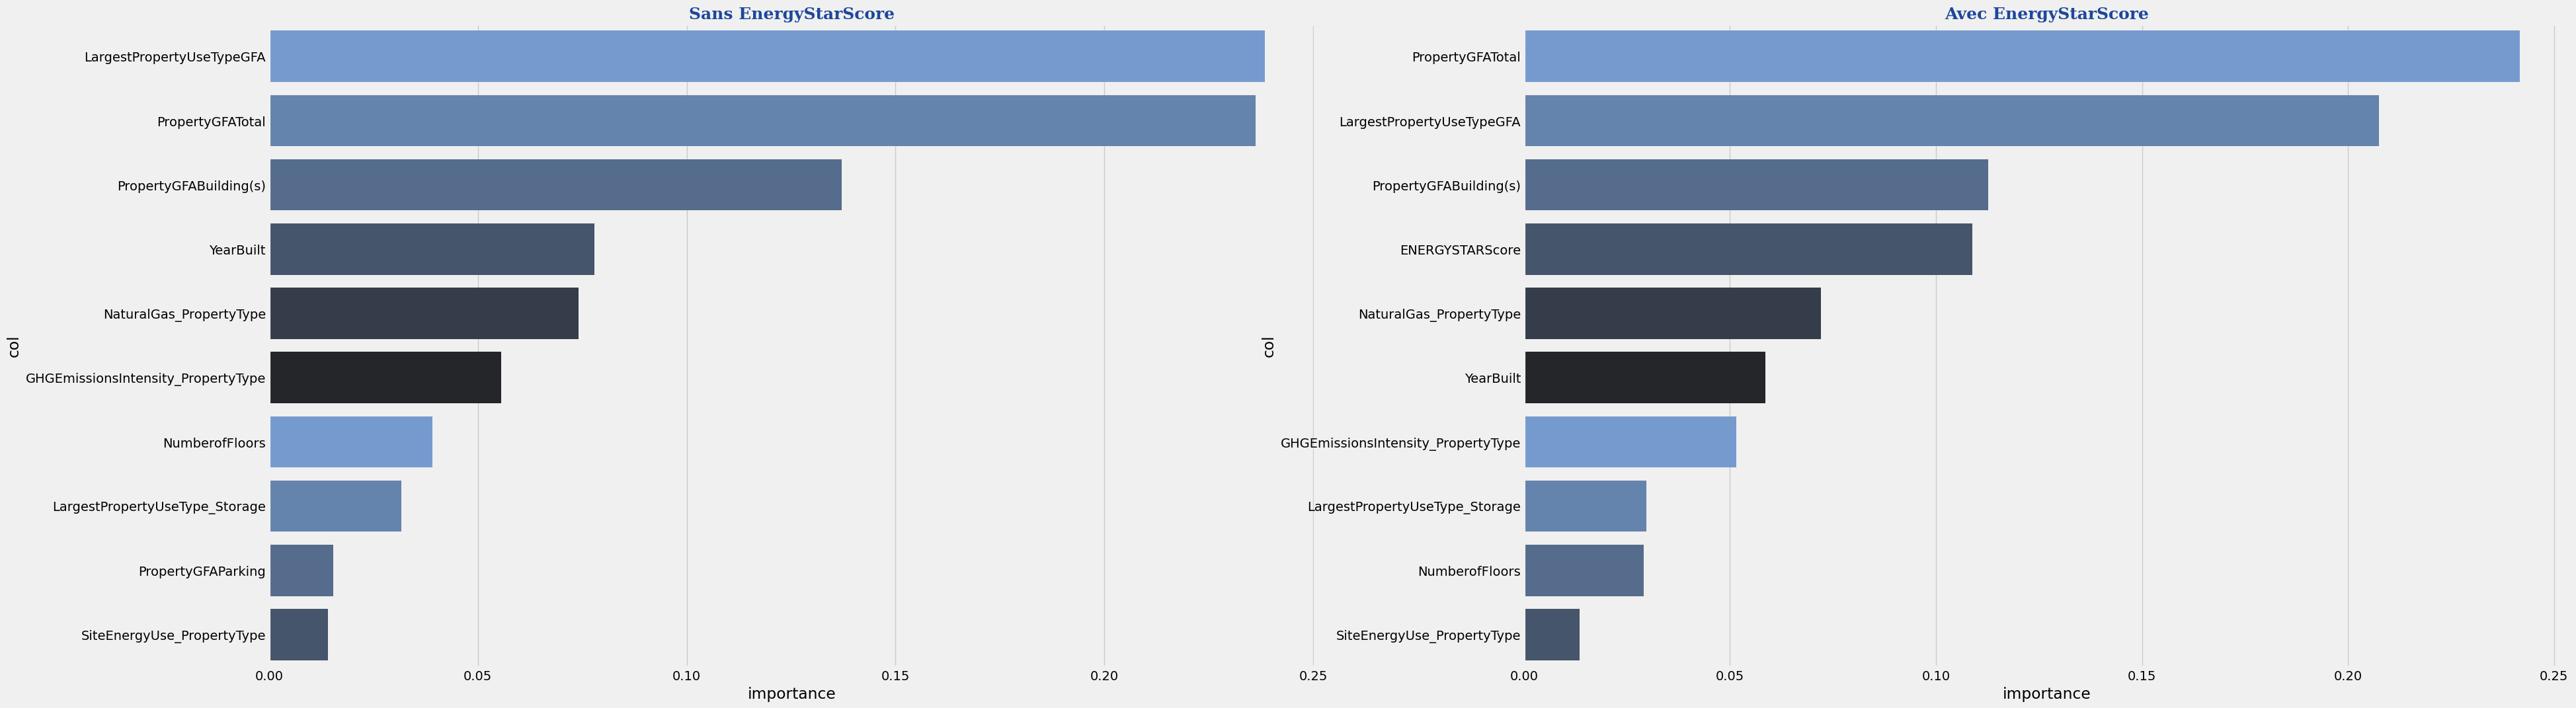

In [100]:
fig, axs = plt.subplots(1,2, figsize=(40,12))

to_disp = pd.DataFrame().from_dict({'col':X_train_star_2.columns, 'importance':rfe_gh_star_2.feature_importances_}).sort_values(by='importance',ascending=False).head(10)
sns.barplot(ax=axs[0], x=to_disp.importance,y=to_disp.col, palette=sns.dark_palette("#69d", reverse=True))
axs[0].set_title('Sans EnergyStarScore',  fontdict=font_title)

to_disp = pd.DataFrame().from_dict({'col':X_train_star.columns, 'importance':rfe_gh_star.feature_importances_}).sort_values(by='importance',ascending=False).head(10)
sns.barplot(ax=axs[1], x=to_disp.importance,y=to_disp.col, palette=sns.dark_palette("#69d", reverse=True))
axs[1].set_title('Avec EnergyStarScore', fontdict=font_title)


plt.show()

## Observation des erreurs

Je cherche ici à savoir: "En moyenne, pour l'ensemble de mes batiments, de combien se trompe mon modèle ?" <br>
Pour cela je calcule le pourcentage d'erreur du RMSE d'un coté et, de l'autre côté je passe mes résultats à l'exponentiel. <br>

Je n'ai plus qu'a calculer l'erreur pour chaque batiments grace à la formule: Pourcentage_Erreur x Valeur_Prédite

### SiteEnergyUse

In [24]:
y_pred_en = rfe_en.predict(X_test)

RMSPE = np.sqrt((y_pred_en-y_test_en)**2/y_test_en)
RMSE_exp = pd.Series(data=RMSPE*np.exp(y_pred_en))

print(f'En moyenne, ce modèle se trompe de : {round(RMSE_exp.mean()/3.412,2)} kWh')
print(f'La médiane des erreurs est : {round(RMSE_exp.median()/3.412,2)} kWh')

En moyenne, ce modèle se trompe de : 104533.84 kWh
La médiane des erreurs est : 36123.95 kWh


Je cherche ici à identifier quels sont mes batiments qui ont un impact négatif important sur mon RMSE avec mon modèle RF. <br>

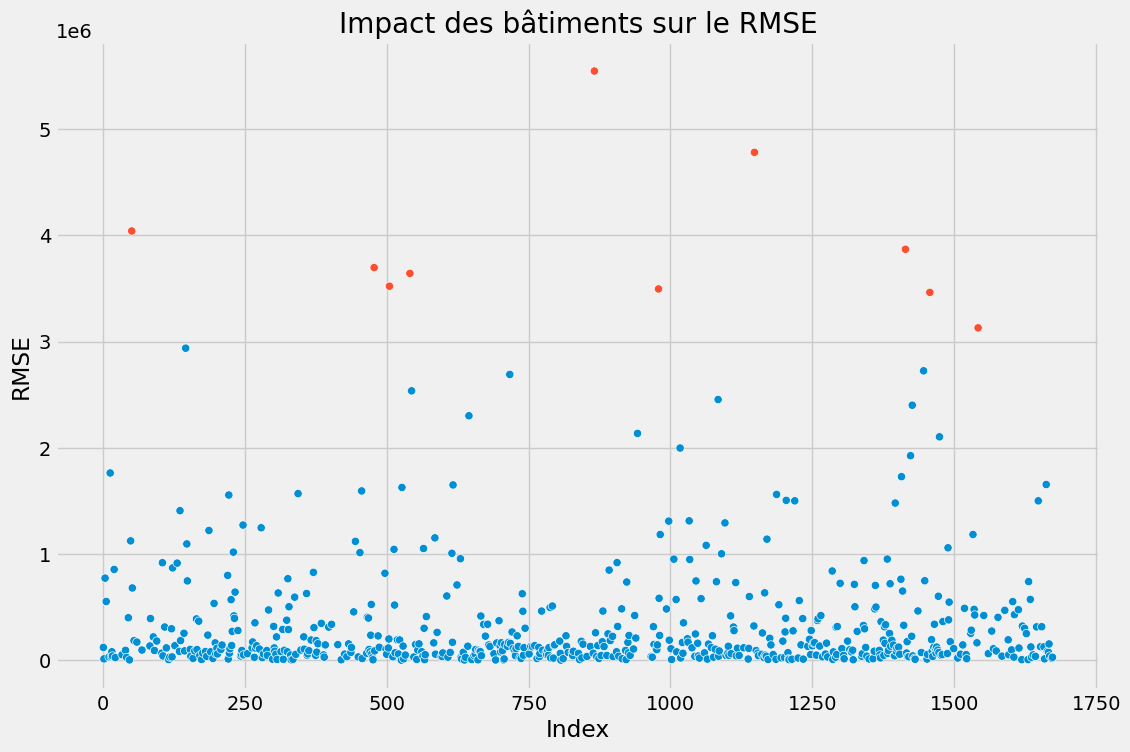

In [128]:
y_pred_en = rfe_en.predict(X_test)

RMSPE = np.sqrt((y_pred_en-y_test_en)**2/y_test_en)
RMSE_exp = pd.Series(data=RMSPE*np.exp(y_pred_en))
sns.scatterplot(x=RMSE_exp.index, y=RMSE_exp, hue=RMSE_exp.isin(RMSE_exp.sort_values(ascending=False).head(10)), legend=False)
plt.xlabel('Index')
plt.ylabel('RMSE')
plt.title('Impact des bâtiments sur le RMSE')

plt.show()

<AxesSubplot:xlabel='SiteEnergyUse(kBtu)', ylabel='Count'>

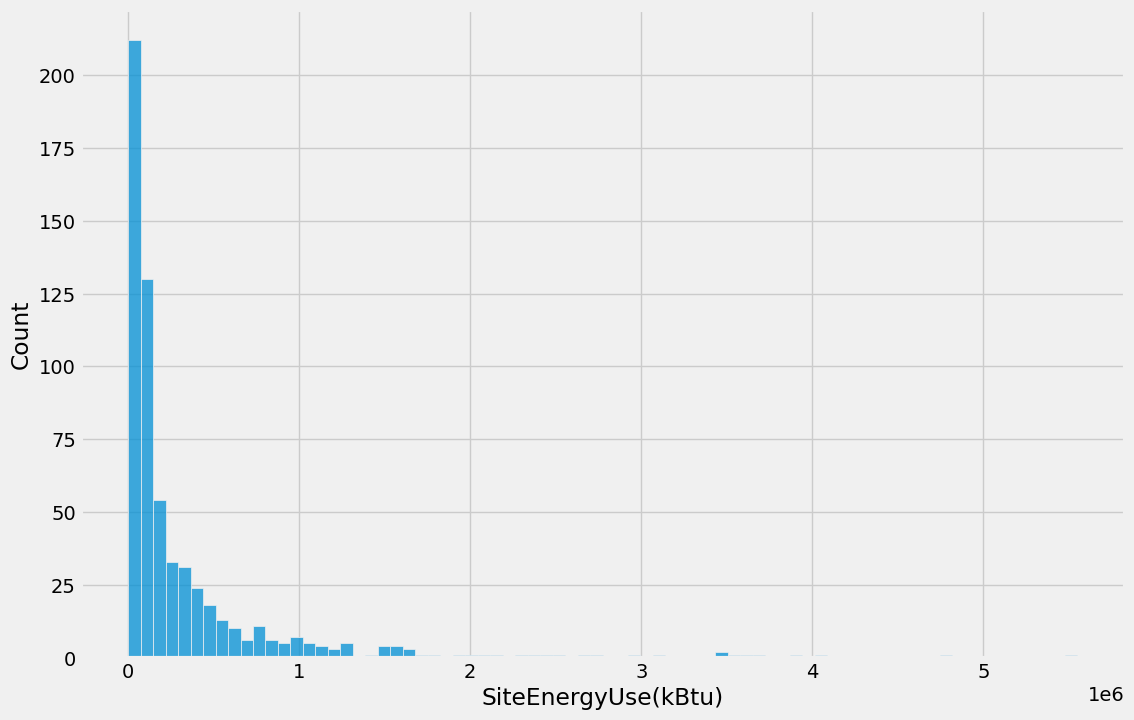

In [131]:
sns.histplot(RMSE_exp)

La majorité de mes erreurs sont faibles, j'ai cependant certaines erreurs très importantes.

### TotalGHGEmissions

In [26]:
y_pred_gh = rfe_gh.predict(X_test)

RMSPE = np.sqrt((y_pred_gh-y_test_gh)**2/y_test_gh)
RMSE_exp = pd.Series(data=RMSPE*np.exp(y_pred_gh))

print(f'En moyenne, ce modèle se trompe de : {round(RMSE_exp.mean(),2)} tonnes de C02')
print(f'La médiane des erreurs est : {round(RMSE_exp.median(),2)} tonnes de C02')

En moyenne, ce modèle se trompe de : 17.74 tonnes de C02
La médiane des erreurs est : 7.22 tonnes de C02


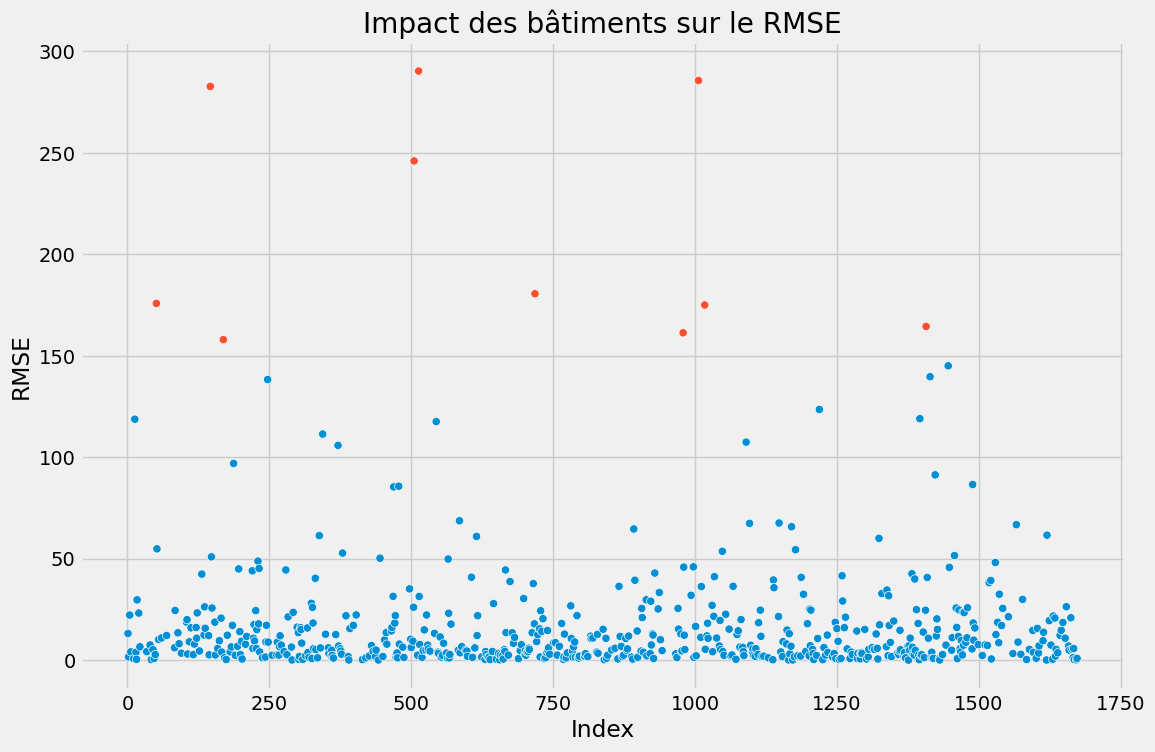

In [27]:
y_pred_gh = rfe_gh.predict(X_test)

RMSPE = np.sqrt((y_pred_gh-y_test_gh)**2/y_test_gh)
RMSE_exp = pd.Series(data=RMSPE*np.exp(y_pred_gh))
sns.scatterplot(x=RMSE_exp.index, y=RMSE_exp, hue=RMSE_exp.isin(RMSE_exp.sort_values(ascending=False).head(10)), legend=False)
plt.xlabel('Index')
plt.ylabel('RMSE')
plt.title('Impact des bâtiments sur le RMSE')

plt.show()

<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Count'>

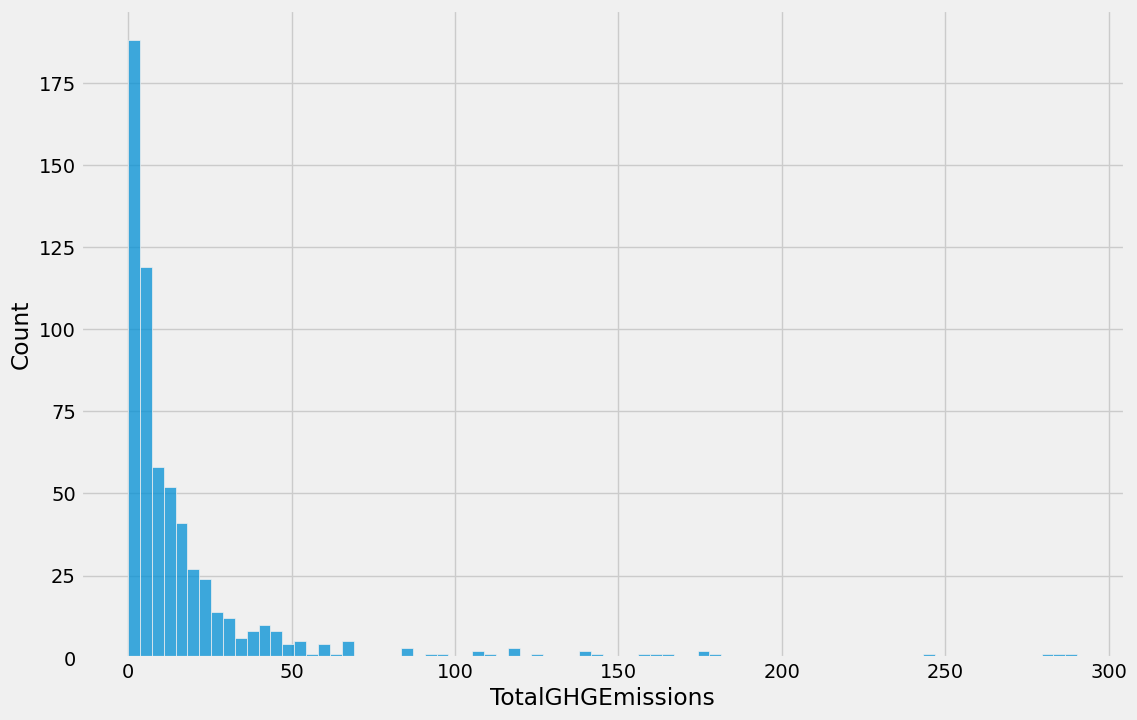

In [28]:
sns.histplot(RMSE_exp)

Les remarques faites précédemment s'appliquent aussi à cette target.